In [1]:
Double_t MVthr_VNS = 7.;
Double_t MVthr_DC = 7.;
Double_t Emin_fit = 700;
Double_t Emax_fit = 4500;

In [2]:
// Functions used to read data and simulations

In [3]:
//Standard deviation of a vector
Double_t Sigma(vector<Double_t> Vector){
    int num_val = Vector.size();
    Double_t Mean=0;
    for (int i=0; i<num_val; i++){
        Mean+=Vector[i];
    }
    Mean= Mean/num_val;
    
    Double_t sigma=0;
    for (int i=0; i<num_val; i++){
        sigma+=(Vector[i]-Mean)*(Vector[i]-Mean);
    }
    sigma= sigma/(num_val-1);
    sigma = sqrt(sigma);
    return sigma;
}

In [4]:
//Smooth Step function
//--------------------------------------------------------------
double cdf(double *x, double *par){
    double mean=par[0];
    double sigma = par[1];
    
    double xx =x[0];
    return ROOT::Math::normal_cdf(xx, sigma, mean);
}

In [5]:
TH1D* Put_data_in_histo(TString filename, double real_time, TString Title){
    ifstream in;
    in.open(filename, ios::in);
    cout<<"\n*******************************************************"<<endl;
    cout<<filename<<endl;
    Float_t time=real_time/(24*3600.);
    
    Int_t x,y, MCA_chan;
    TH1D* h1 = new TH1D(Title,Title,512,-0.5,511.5);
    h1->GetXaxis()->SetTitle("Pulse Height [MCA a.u.]");
    h1->GetYaxis()->SetTitle("Counts per day per MCA channel");
    
    while (1) {
        in >> x >> y;
        if (!in.good()) break;
        
        h1->SetBinContent(x+1, y);
        h1->SetBinError(x+1, sqrt(y));
    }
    MCA_chan=h1->GetBinWidth(1);
    h1->Scale(1./(MCA_chan*time));
    return h1;
}

In [6]:
//This function applies a quenching factor
TH1D* Put_simu_in_histo(TString filename, TString Title, int nBin, double Emin, double Emax, Double_t NEvt, Double_t Flux =0.0134, Double_t QF=3.5/5., Double_t MVthr=3., bool Veto=true, Double_t resol = 4.6){
    
    TFile* Nfile = new TFile(filename);

    Float_t ECr, EMV;
    TRandom gen(0);
    
    Double_t NTime = NEvt/40./40./Flux;     // s
    
    TTree *Nnp = (TTree*) Nfile->Get("NTupleAlgoDir/Pri_Ntuple");
    TTree *Nns = (TTree*) Nfile->Get("NTupleAlgoDir/Sec_Ntuple");

    Int_t Np_entries= Nnp->GetEntries();
    Int_t Ns_entries= Nns->GetEntries();
    printf("  Primary Entries:      %10d\n",Np_entries);
    printf("  Secondary Entries:    %10d\n",Ns_entries);
    printf("  Generated primaries:  %.0f\n",NEvt);
    printf("  Equivalent time:      %.0f s (%.3f d)\n",NTime,NTime/86400.);
    
    TH1D *neut = new TH1D(Title,Title,nBin,Emin,Emax);

    neut->GetXaxis()->SetTitle("Energy [keVee]");
    neut->GetYaxis()->SetTitle("Counts.d^{-1}.keVee^{-1}");

    Nnp->SetBranchAddress("EDep", &ECr);
    if (Veto){Nnp->SetBranchAddress("EMV0", &EMV);}

    Float_t NpNSec,NpDelay, NsPDG,NsPidM,NsPid;
    Nnp->SetBranchAddress(  "NSec", &NpNSec);
    Nnp->SetBranchAddress( "Delay", &NpDelay);
    Nns->SetBranchAddress(   "PDG", &NsPDG);
    Nns->SetBranchAddress(  "PidM", &NsPidM);
    Nns->SetBranchAddress(   "Pid", &NsPid);
    
    // Loop on primary particles pk
    Int_t pk=0, sk=0, npCheck=0, nsCheck=0, isQF=0, nQuenched=0;
    
    while (pk < Np_entries) {
        
        // Loop on secondary particles sk (defined as those particles entering in the LiI(Eu) crystal)
        if (sk < Ns_entries) Nns->GetEntry(sk);
        
        // Get the "id" of the primary particles associated to the secondary particle sk
        Int_t id = ((Int_t) (NsPidM+0.5))*1000000 + ((Int_t) (NsPid+0.5));
        
         // if the primary particles is pk (the one under examination in primary loop), set isQF=1 in the cases when the
        // secondary particle sk is a neutron or antineutron
        // ==> i.e., if the secondary particles entering in the LiI(Eu) crystal is a neutron, the deposited energy is due
        // to a neutron interaction in LiI(Eu) detector and the quenching factor has to be applied (isQF=1, --> true).
        if(id==pk && sk < Ns_entries) {
            if (NsPDG==2112 || NsPDG==-2112) isQF=1;
            sk++;
            nsCheck++;
        } 
        
        // otherwise, no further secondary particles are associated to pk, I can fill the spectrum with the deposited
        // energy in LiI(Eu) detector (branch EDep in primary ntuple), applying or not the quenching factor
        else {
            Nnp->GetEntry(pk);
            // it is only a consinstency check (verify that the number of analysed secondary particles is the expected one)
            // for the pk primary particle under examination
            if (NpNSec != nsCheck) printf(" Primary entry %d: NSec error NSec=%d, nsCheck=%d\n", pk, (int) NpNSec, nsCheck);
    
            // It happens sometime that the primary particles is not associated to any secondary particles (NpNSec=0);
            // Almost always, it is due to very slow neutrons that after entering the LiI(Eu) crystal need long time before
            // having an interaction, and therefore are classified as new, delayed events (NpDelay>0) and loose their correlation
            // with the secondary particle ntuple. Also these events have to be classified as neutron events ==> isQF=1
            // (this point is not easy to explain, maybe we can have a short discussion about it)
            if (NpNSec==0 && NpDelay>0) isQF=1;        // Sicuramente neutroni
            if (isQF == 1) nQuenched++;
            
            // the E deposition in the MV is spread accounting for energy resolution resolution
            Float_t Ep = EMV;
        
            if (Ep>0){
                Float_t sp = 0.1008*sqrt(1./Ep*(1.+1./Ep))/2.3548;      // (%)
                Ep *= (1. + sp*gen.Gaus())*1000.;
            }
            
            if (Veto){
                if (Ep < MVthr*1000) {
                    Float_t E = ECr*1000.;                                  // keV

                    if (isQF==1) E *= QF;
                    Double_t Enew = gen.Gaus(E, resol*sqrt(E));
                    neut->Fill(Enew);
                } // else printf("Ep = %f keV\n",EMV);
            }
            
            else {
                Float_t E = ECr*1000.;                                  // keV

                if (isQF==1) E *= QF;
                Double_t Enew = gen.Gaus(E, resol*sqrt(E));
                neut->Fill(Enew);
            }
            
            npCheck++;
            nsCheck=0;
            isQF=0;
            pk++;
        }
    }

    printf(" Nb of primary analysed: %d\n", npCheck);
    printf(" Nb of events quenched : %d\n", nQuenched);
    
    Double_t Ei = neut->GetBinWidth(1);
    neut->Scale(1./(NTime/86400.)/Ei);
    return neut;
}

In [7]:
// Residual histogram
TH1D* Residuals(TH1D* histo_data, TF1* Model, Double_t Min, Double_t Max, bool pc = true){
    TH1D* hRes = (TH1D*) histo_data->Clone();
    double Value_i, E_i, Diff_i, Error_i;
    double chi2=0;
    for (int i = 1; i<hRes->GetNbinsX(); i++){
        Value_i = hRes->GetBinContent(i);
        E_i = hRes->GetBinCenter(i);
        if (Value_i>0&&E_i>Min&&E_i<Max) {
            Diff_i = histo_data->GetBinContent(i)-Model->Eval(E_i);
            Error_i = histo_data->GetBinError(i);
            if (pc) {
                hRes->SetBinContent(i, Diff_i/Value_i*100);
                hRes->SetBinError(i, Error_i/Value_i*100);
            }
            else {
                hRes->SetBinContent(i, Diff_i/Error_i);
                hRes->SetBinError(i, 1);
            }
            chi2+=(Diff_i*Diff_i)/(Error_i*Error_i);
        }
        else hRes->SetBinContent(i, 0);
    }

    //cout<<"\nChi2/ndf = "<<chi2<<"/"<<Model->GetNDF()<<" = "<<chi2/Model->GetNDF()<<endl;
    hRes->SetLineColor(Model->GetLineColor());
    hRes->SetTitle("");
    if (pc) hRes->GetYaxis()->SetRangeUser(-100, 100);
    else hRes->GetYaxis()->SetRangeUser(-20, 20);
    return hRes;
}

In [8]:
// Residual histogram
std::vector<TH1D*> Residuals_vec(TH1D* histo_data, TF1* Model, Double_t Min, Double_t Max, bool pc = true){
    TH1D* hRes = (TH1D*) histo_data->Clone();
    TString Title = histo_data->GetTitle();
    TH1D* hReducedRes = new TH1D("Reduced_res_"+Title,"Reduced_res_"+Title, 50, -10, 10);
    
    double Value_i, E_i, Diff_i, Error_i;
    double chi2=0;
    for (int i = 1; i<hRes->GetNbinsX(); i++){
        Value_i = hRes->GetBinContent(i);
        E_i = hRes->GetBinCenter(i);
        if (Value_i>0&&E_i>Min&&E_i<Max) {
            Diff_i = histo_data->GetBinContent(i)-Model->Eval(E_i);
            Error_i = histo_data->GetBinError(i);
            hReducedRes->Fill(Diff_i/Error_i);
            if (pc) {
                hRes->SetBinContent(i, Diff_i/Value_i*100);
                hRes->SetBinError(i, Error_i/Value_i*100);
            }
            else {
                hRes->SetBinContent(i, Diff_i/Error_i);
                hRes->SetBinError(i, 1);
            }
            chi2+=(Diff_i*Diff_i)/(Error_i*Error_i);
        }
        else {
            hRes->SetBinContent(i, 0);
            hRes->SetBinError(i, 0);
        }
    }

    //cout<<"\nChi2/ndf = "<<chi2<<"/"<<Model->GetNDF()<<" = "<<chi2/Model->GetNDF()<<endl;
    hRes->SetLineColor(Model->GetLineColor());
    hRes->SetTitle("");
    
    hReducedRes->SetFillColor(Model->GetLineColor());
    hReducedRes->SetLineColor(Model->GetLineColor());
    hReducedRes->SetTitle("");
    
    if (pc) hRes->GetYaxis()->SetRangeUser(-100, 100);
    else hRes->GetYaxis()->SetRangeUser(-20, 20);
    hReducedRes->GetXaxis()->SetRangeUser(-5, 5);
    
    std::vector<TH1D*> histos;
    histos.push_back(hRes);
    histos.push_back(hReducedRes);
    return histos;
}

In [9]:
TH1D* Put_simu_in_histo_nq(TString filename, TString Title, int nBin, double Emin, double Emax, Double_t NumEv, Double_t Flux, Double_t MVthr=3.){
    TFile* Infile = new TFile(filename);
    
    Float_t ECr, EMV;
    TRandom gen(0);
    
    Double_t Plane_surf = 40.*40.; //cm2
    
    Double_t Time = NumEv/(Plane_surf*Flux); //s
    
    TTree *InTree = (TTree*) Infile->Get("NTupleAlgoDir/Pri_Ntuple");
    Int_t entries= InTree->GetEntries();
    printf(" Entries:      %10d\n",entries);
    printf(" Generated primaries:  %.0f\n",NumEv);
    printf(" Equivalent time:      %.0f s (%.3f d)\n",Time,Time/86400.);

    TH1D *histo = new TH1D(Title,Title,nBin,Emin,Emax);
    histo->GetXaxis()->SetTitle("Energy [keVee]");
    histo->GetYaxis()->SetTitle("Counts.d^{-1}.keVee^{-1}");

    InTree->SetBranchAddress("EDep", &ECr);
    InTree->SetBranchAddress("EMV0", &EMV);
    for (Int_t pk=0; pk<entries; pk++) {
        InTree->GetEntry(pk);
        
        Float_t Ep = EMV;
        
        if (Ep>0){
            Float_t sp = 0.1008*sqrt(1./Ep*(1.+1./Ep))/2.3548;      // (%)
            Ep *= (1. + sp*gen.Gaus())*1000.;
            if (Ep < MVthr*1000) continue;
        }
        
        Float_t E = ECr*1000.;                            // keV
        Float_t Enew = gen.Gaus(E, 0.084*sqrt(3500)*sqrt(E)); //Neutron peak assumed to be at 3500 keVee
        histo->Fill(Enew);
    }
    Double_t Ei = histo->GetBinWidth(1);
    histo->Scale(1./(Time/86400.)/Ei);
    
    return histo;
}

In [10]:
%jsroot off
#include <TFitResult.h>

# Analysis of the 9 inches sphere

Load the runs taken in the different locations with the 9inch sphere and the LII(Eu) detector. Those in the VNS, and the Double Chooz Hut (DC Hut) are taken with a muon veto panel in anti-coincidences.

## Data

### CryoLab

In [11]:
TH1D* h_CryoLab_9inch = Put_data_in_histo("Measures@TUM/02-21_BkgSpektrum_CryoLab_BS-EXT_72h.dat", 72*3600, "BS-EXT at Cryolab atm neutrons");
h_CryoLab_9inch->Rebin(4);
h_CryoLab_9inch->Scale(1/4.);


*******************************************************
Measures@TUM/02-21_BkgSpektrum_CryoLab_BS-EXT_72h.dat


In [12]:
TH1D* h_CryoLab_9inch_MV = Put_data_in_histo("Measures@TUM/03-28_BkgSpektrum_CryoLab_BS-EXT_19h.dat", 19*3600, "BS-EXT at Cryolab atm neutrons with MV");
h_CryoLab_9inch_MV->Rebin(4);
h_CryoLab_9inch_MV->Scale(1/4.);


*******************************************************
Measures@TUM/03-28_BkgSpektrum_CryoLab_BS-EXT_19h.dat


### CrystalLab

In [13]:
TH1D* h_Crystal_9inch = Put_data_in_histo("Measures@TUM/03-03_BkgSpektrum_CrystalLab_BS-EXT_141h.dat", 141*3600, "9inch at CrystalLab atm neutrons");
h_Crystal_9inch->Rebin(4);
h_Crystal_9inch->Scale(1/4.);


*******************************************************
Measures@TUM/03-03_BkgSpektrum_CrystalLab_BS-EXT_141h.dat


### VNS 

In [14]:
TH1D* h_VNS_9inch_1 = Put_data_in_histo("Measures@VNS/2022-04-27_BS-EXT_RT_1122274.88_LV_1121904.17.dat", 1122274., "9inch at VNS - 1");
h_VNS_9inch_1->Rebin(4);
h_VNS_9inch_1->Scale(1/4.);

TH1D* h_VNS_9inch_2 = Put_data_in_histo("Measures@VNS/2022-06-07_BS-EXT_RT_1140078.50_LV_1139756.64.dat", 1140078, "9inch at VNS - 2");
h_VNS_9inch_2->Rebin(4);
h_VNS_9inch_2->Scale(1/4.);

TH1D* h_VNS_9inch_3 = Put_data_in_histo("Measures@VNS/2022-07-19_BS-EXT_RT_2242568.15_LV_2241965.42.dat", 2242568, "9inch at VNS - 3");
h_VNS_9inch_3->Rebin(4);
h_VNS_9inch_3->Scale(1/4.);


*******************************************************
Measures@VNS/2022-04-27_BS-EXT_RT_1122274.88_LV_1121904.17.dat

*******************************************************
Measures@VNS/2022-06-07_BS-EXT_RT_1140078.50_LV_1139756.64.dat

*******************************************************
Measures@VNS/2022-07-19_BS-EXT_RT_2242568.15_LV_2241965.42.dat


In [15]:
TH1D* h_VNS_9inch_sum = (TH1D*) h_VNS_9inch_1->Clone();
h_VNS_9inch_sum->Add(h_VNS_9inch_sum, h_VNS_9inch_2, 1/3., 1/3.); 
h_VNS_9inch_sum->Add(h_VNS_9inch_sum, h_VNS_9inch_3, 1, 1/3.);
h_VNS_9inch_sum->SetTitle("9inch at VNS - sum");

The 3 runs taken in the VNS are sumed, without any shift or recalibration, we are considering that the gain didn't change during the whole period of data taking. Here the 3 spectra and the sum are superimposed to check the stability of the measurements.

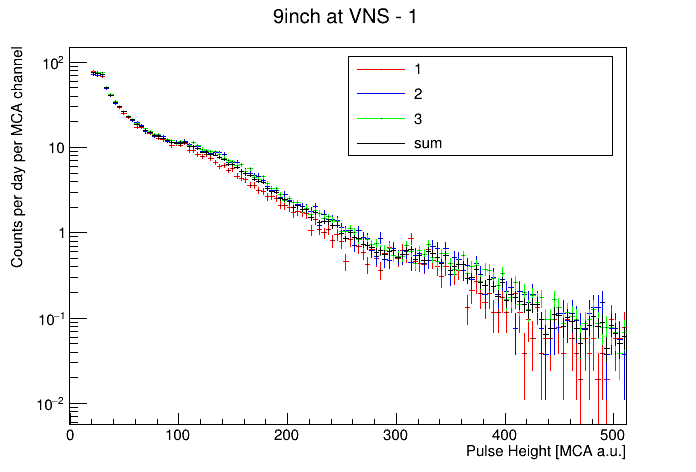

In [16]:
TCanvas* C3 = new TCanvas();
C3->Draw();
C3->SetLogy();
//h_CryoLab_8inch->GetYaxis()->SetRangeUser(0, 500);
h_VNS_9inch_1->SetLineColor(kRed);
h_VNS_9inch_1->Draw("");
h_VNS_9inch_2->SetLineColor(kBlue);
h_VNS_9inch_2->Draw("Same");
h_VNS_9inch_3->SetLineColor(kGreen);
h_VNS_9inch_3->Draw("Same");
h_VNS_9inch_sum->SetLineColor(kBlack);
h_VNS_9inch_sum->Draw("SAME");
gStyle->SetOptStat(0);
TLegend* leg = new TLegend(0.8, 0.8);
leg->AddEntry(h_VNS_9inch_1, "1");
leg->AddEntry(h_VNS_9inch_2, "2");
leg->AddEntry(h_VNS_9inch_3, "3");
leg->AddEntry(h_VNS_9inch_sum, "sum");
leg->Draw("same");

### DCHut

The two runs taken in the DCHut are sumed. No shift, no calibration.

In [17]:
TH1D* h_DC_9inch_1 = Put_data_in_histo("Measures@DCHut/2022-08-25_BS-EXT_RT_1282905.28_LV_1282579.20.dat", 1282579., "9inch at DChut - 1");
h_DC_9inch_1->Rebin(4);
h_DC_9inch_1->Scale(1/4.);

TH1D* h_DC_9inch_2 = Put_data_in_histo("Measures@DCHut/2022-10-04_BS-EXT_RT_1748999.66_LV_1748473.16.dat", 1748473., "9inch at DChut - 2");
h_DC_9inch_2->Rebin(4);
h_DC_9inch_2->Scale(1/4.);


*******************************************************
Measures@DCHut/2022-08-25_BS-EXT_RT_1282905.28_LV_1282579.20.dat

*******************************************************
Measures@DCHut/2022-10-04_BS-EXT_RT_1748999.66_LV_1748473.16.dat


In [18]:
TH1D* h_DC_9inch_sum = (TH1D*) h_DC_9inch_1->Clone();
h_DC_9inch_sum->Add(h_DC_9inch_sum, h_DC_9inch_2, 1/2., 1/2.); 
h_DC_9inch_sum->SetTitle("9inch at DCHut - sum");

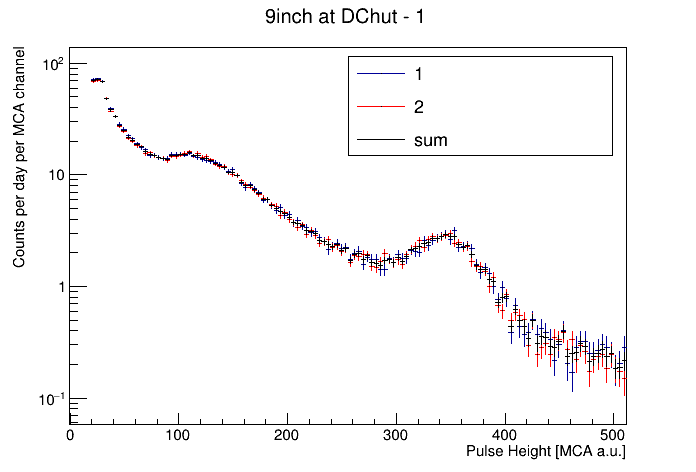

In [19]:
TCanvas* C4 = new TCanvas();
C4->Draw();
C4->SetLogy();
h_DC_9inch_1->Draw();
h_DC_9inch_2->SetLineColor(kRed);
h_DC_9inch_2->Draw("SAME");
h_DC_9inch_sum->SetLineColor(kBlack);
h_DC_9inch_sum->Draw("SAME");

gStyle->SetOptStat(0);
TLegend* leg = new TLegend(0.9, 0.9);
leg->AddEntry(h_DC_9inch_1, "1");
leg->AddEntry(h_DC_9inch_2, "2");
leg->AddEntry(h_DC_9inch_sum, "sum");
leg->Draw("same");

### Cf run

In [20]:
TH1D* h_Cal_9inch = Put_data_in_histo("Measures@TUM/03-14_Cf252_LMU_BS-EXT_3h.dat", 3*24*3600., "9inch with Cf252 n source");
h_Cal_9inch->Rebin(4);
h_Cal_9inch->Scale(1/4.);


*******************************************************
Measures@TUM/03-14_Cf252_LMU_BS-EXT_3h.dat


## Calibration

In [21]:
// from BS_Calibration

double Offset = 3.3;
double Gain = 9.0;

cout<<"The calibration slope is MCA = "<<Gain<<"xE + "<<Offset<<endl;

double Resol = 4.;

The calibration slope is MCA = 9xE + 3.3


In [22]:
TH1D* Calibrate_histo(TH1D* histo, Double_t CalibVal, TString NewTitle, Double_t Offset=0){
    Int_t NBins = histo->GetNbinsX();
    Int_t MCA_min = histo->GetBinCenter(1);
    Int_t MCA_max = histo->GetBinCenter(NBins);
    
    TH1D* Calib_histo = new TH1D(NewTitle, Form("%s_keVee", histo->GetTitle()), NBins, (MCA_min-Offset)*CalibVal, (MCA_max-Offset)*CalibVal);
    Int_t MCA_i;
    Double_t E_cal, MCA_i_content, MCA_i_Error;
    for(int i=0; i<NBins; i++){
        MCA_i = histo->GetBinCenter(i);
        MCA_i_content = histo->GetBinContent(i)*histo->GetBinWidth(i);
        MCA_i_Error = histo->GetBinError(i)*histo->GetBinWidth(i);
        E_cal = (MCA_i-Offset)*CalibVal;
        int Bin_Ecal = Calib_histo->FindBin(E_cal);
        Double_t prev_val_Ecal = Calib_histo->GetBinContent(Bin_Ecal);
        Double_t prev_err_Ecal = Calib_histo->GetBinError(Bin_Ecal);
        Calib_histo->SetBinContent(Bin_Ecal, prev_val_Ecal+MCA_i_content/Calib_histo->GetBinWidth(i));
        Calib_histo->SetBinError(Bin_Ecal, sqrt(prev_err_Ecal*prev_err_Ecal+(MCA_i_Error/Calib_histo->GetBinWidth(i))*(MCA_i_Error/Calib_histo->GetBinWidth(i))));
    }
    Calib_histo->GetXaxis()->SetTitle("Calibrated Energy [keVee]");
    Calib_histo->GetYaxis()->SetTitle("Differential rate (ev.d^{-1}.keVee^{-1})");

    return Calib_histo;
}

In [23]:
//Cryolab
TH1D* hCal_CryoLab_9inch = Calibrate_histo(h_CryoLab_9inch, Gain, Form("%s_keVee", h_CryoLab_9inch->GetTitle()), Offset);
TH1D* hCal_CryoLab_9inch_MV = Calibrate_histo(h_CryoLab_9inch_MV, Gain, Form("%s_keVee", h_CryoLab_9inch_MV->GetTitle()), Offset);

In [24]:
//Crystal Lab
TH1D* hCal_Crystal_9inch = Calibrate_histo(h_Crystal_9inch, Gain, Form("%s_keVee", h_Crystal_9inch->GetTitle()), Offset);

In [25]:
//VNS
TH1D* hCal_VNS_9inch = Calibrate_histo(h_VNS_9inch_sum, Gain, Form("%s_keVee", h_VNS_9inch_sum->GetTitle()), Offset);

In [26]:
//DCHut
TH1D* hCal_DC_9inch = Calibrate_histo(h_DC_9inch_sum, Gain, Form("%s_keVee", h_DC_9inch_sum->GetTitle()), Offset);

In [27]:
//Cf
TH1D* h_Cf_Saclay_8inch = Put_data_in_histo("Measures@Saclay/2022-11-08_BS-A-06_RT_777.23_LV_776.57_Cf252.dat", 777.23, "8inch with Cf252 n source");
h_Cf_Saclay_8inch->Rebin(4);
h_Cf_Saclay_8inch->Scale(1/4.);


*******************************************************
Measures@Saclay/2022-11-08_BS-A-06_RT_777.23_LV_776.57_Cf252.dat


## Quenching Factor

The simulation of atmospheric neutrons (unquenched) is used to determine the true energy deposition in the crystal. The quenching factor will be calculated from the ratio of the postion of the peak in the calibrated data and the true energy deposition obtianed from the simulation

In [28]:
TH1D* h_SimuNeutrons_9inch_nq = Put_simu_in_histo_nq("Simulations/Atm_Neutr/BS_D09/Analyzer_T_run01-15.root", "9 inches - atmospheric neutrons (with MV)", 512, 0, 8000, 1.50e9, 0.0134, MVthr_DC);

 Entries:          385573
 Generated primaries:  1500000000
 Equivalent time:      69962687 s (809.753 d)


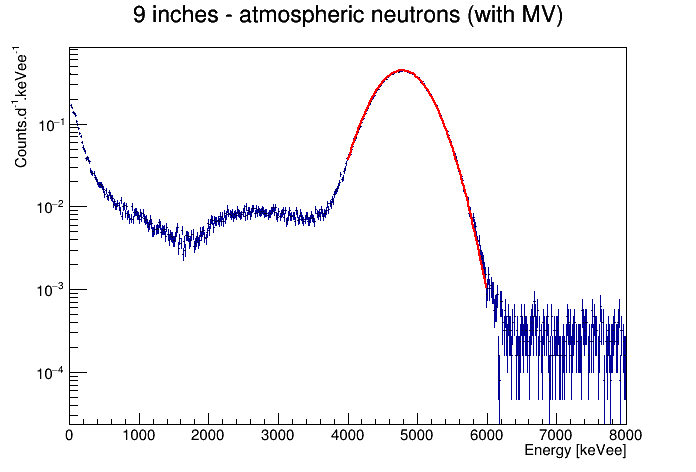

 FCN=130.661 FROM MIGRAD    STATUS=CONVERGED     115 CALLS         116 TOTAL
                     EDM=4.02145e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Amplitude [Counts/E]   4.42579e-01   1.00330e-03   4.46685e-06   5.53075e-02
   2  #mu [keV]    4.78420e+03   6.58904e-01   3.64280e-03  -9.55400e-04
   3  #sigma [keV]   3.47266e+02   5.19263e-01   2.28827e-03  -1.36750e-03


In [29]:
TCanvas* C8 = new TCanvas();
C8->Draw();
C8->SetLogy();

TF1* Neutron_peak_Gaus_E = new TF1("Neutron_peak_Gaus_E", "[0]*TMath::Gaus(x, [1], [2])", 1000, 6000); //Gaussian function to fit the neutron peak
Neutron_peak_Gaus_E->SetParNames("Amplitude [Counts/E]", "#mu [keV]", "#sigma [keV]");
Neutron_peak_Gaus_E->SetParameter(0, 0.1);
Neutron_peak_Gaus_E->SetParameter(1, 5000);
Neutron_peak_Gaus_E->SetParameter(2, 500);

h_SimuNeutrons_9inch_nq->Fit("Neutron_peak_Gaus_E", "R", "",  4000, 6000);
h_SimuNeutrons_9inch_nq->Draw();

double E_NP_nq = Neutron_peak_Gaus_E->GetParameter(1);  

### Peak position from neutron calibration run with Cf

In order to calibrate the data, the peak position from the source run performed at TUM is fittted to obtain a calibration factor.

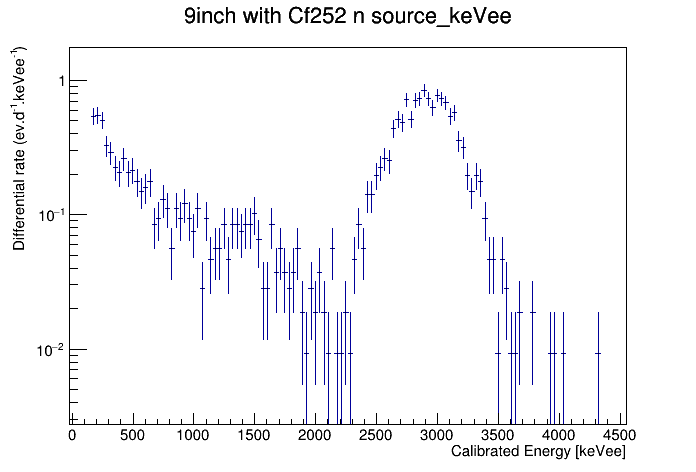

In [30]:
//Cf
TCanvas* C8 = new TCanvas();
C8->Draw();
C8->SetLogy();

//h_Cal_9inch->Draw();
TH1D* hCal_Cf_9inch = Calibrate_histo(h_Cal_9inch, Gain, Form("%s_keVee", h_Cal_9inch->GetTitle()), Offset);
hCal_Cf_9inch->Draw();

In [31]:
Neutron_peak_Gaus_E->SetParameter(0, 1.);
Neutron_peak_Gaus_E->SetParameter(1, 3000);
Neutron_peak_Gaus_E->SetParameter(2, 500);

hCal_Cf_9inch->Fit("Neutron_peak_Gaus_E", "R", "", 2000, 5000);
double E_NP_q = Neutron_peak_Gaus_E->GetParameter(1);  
double Resol_NP = Neutron_peak_Gaus_E->GetParameter(2);  

 FCN=60.7266 FROM MIGRAD    STATUS=CONVERGED     107 CALLS         108 TOTAL
                     EDM=1.30412e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Amplitude [Counts/E]   7.56732e-01   2.58439e-02   7.97734e-05  -7.46184e-04
   2  #mu [keV]    2.90316e+03   6.44441e+00   2.45954e-02   2.26232e-06
   3  #sigma [keV]   2.32796e+02   4.74030e+00   1.45836e-02  -1.19037e-05


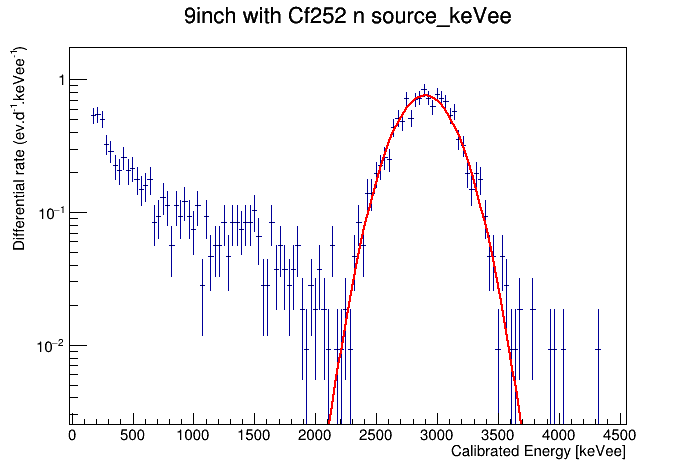

In [32]:
TCanvas* C8 = new TCanvas();
C8->Draw();
C8->SetLogy();
hCal_Cf_9inch->Draw();

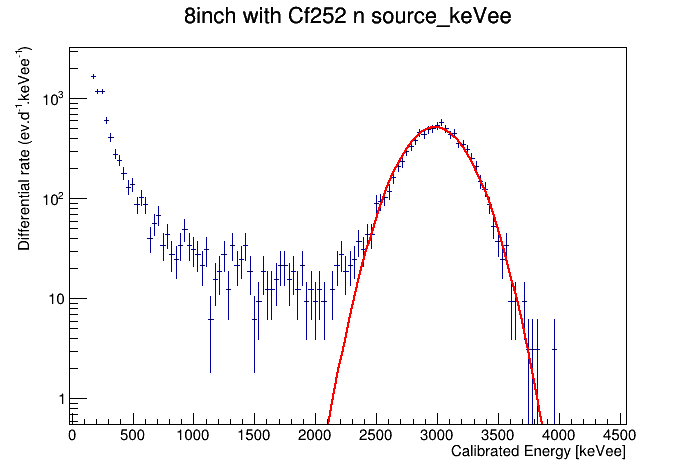

 FCN=66.6138 FROM MIGRAD    STATUS=CONVERGED     205 CALLS         206 TOTAL
                     EDM=3.94935e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Amplitude [Counts/E]   5.14689e+02   1.26160e+01   3.93657e-02  -2.32423e-06
   2  #mu [keV]    2.98566e+03   4.67768e+00   1.82715e-02  -1.12576e-05
   3  #sigma [keV]   2.37683e+02   3.69878e+00   1.13536e-02   1.03449e-05


In [33]:
TH1D* hCal_CfSaclay_9inch = Calibrate_histo(h_Cf_Saclay_8inch, Gain, Form("%s_keVee", h_Cf_Saclay_8inch->GetTitle()), Offset);

hCal_CfSaclay_9inch->Fit("Neutron_peak_Gaus_E", "R", "", 2000, 5000);

TCanvas* C8 = new TCanvas();
C8->Draw();
C8->SetLogy();
hCal_CfSaclay_9inch->Draw();

double E_NP_q = Neutron_peak_Gaus_E->GetParameter(1);  
double Resol_NP = Neutron_peak_Gaus_E->GetParameter(2);  

In [34]:
double QF_neutrons = E_NP_q/E_NP_nq;

In [35]:
QF_neutrons

(double) 0.62406669


In [36]:
sqrt((4.68*4.68)/(E_NP_nq*E_NP_nq)+(6.44*6.44)/(E_NP_q*E_NP_q))*QF_neutrons

(double) 0.0014780600


## Simulation results

Load the simulations of ambient gammas, atmospheric muons and neutrons with the 9inch sphere, performed by Fabio. Analyzed with the Ntuple algo. The corresponding histograms are calculated from Fabio's method in BS_BkgModel.C : the Muon veto panel is taken into account with a 3 MeV cut. The quenching factor for neutron energy deposition is calculated in order to have a neutron capture peak at 3.5 MeVee. An arbitrary resolution is applied bu will not be considered for the fitting procedure.

### Gammas

In [37]:
int nbins = hCal_DC_9inch->GetNbinsX();
double hEmin = hCal_DC_9inch->GetBinLowEdge(1);
double hEmax = hCal_DC_9inch->GetBinLowEdge(nbins)+hCal_DC_9inch->GetBinWidth(nbins);
TH1D* h_SimuGamma_9inch = Put_simu_in_histo("Simulations/Env_Gammas/BS_D09/Analyzer_T_run01-09.root", "9 inches environmental gammas", nbins, hEmin, hEmax, 1.20e10, 3.3, QF_neutrons, MVthr_DC, false, Resol);

  Primary Entries:          158126
  Secondary Entries:        163150
  Generated primaries:  12000000000
  Equivalent time:      2272727 s (26.305 d)
 Nb of primary analysed: 158126
 Nb of events quenched : 0


### Muons

With secondary neutrons quenched

In [38]:
TH1D* h_SimuMuons_9inch_DC = Put_simu_in_histo("Simulations/Atm_Muons/BS_D09/Analyzer_T_run01-09.root", Form("9 inches - atmospheric muons (with MV %0.f MeV thr)", MVthr_DC), nbins, hEmin, hEmax, 5.6e7, 0.019, QF_neutrons, MVthr_DC, true, Resol);

  Primary Entries:          400797
  Secondary Entries:        468366
  Generated primaries:  56000000
  Equivalent time:      1842105 s (21.321 d)
 Nb of primary analysed: 400797
 Nb of events quenched : 1124


In [39]:
TH1D* h_SimuMuons_9inch_VNS = Put_simu_in_histo("Simulations/Atm_Muons/BS_D09/Analyzer_T_run01-09.root", Form("9 inches - atmospheric muons (with MV %0.f MeV thr)", MVthr_VNS), nbins, hEmin, hEmax, 5.6e7, 0.019, QF_neutrons, MVthr_VNS, true, Resol);

  Primary Entries:          400797
  Secondary Entries:        468366
  Generated primaries:  56000000
  Equivalent time:      1842105 s (21.321 d)
 Nb of primary analysed: 400797
 Nb of events quenched : 1124


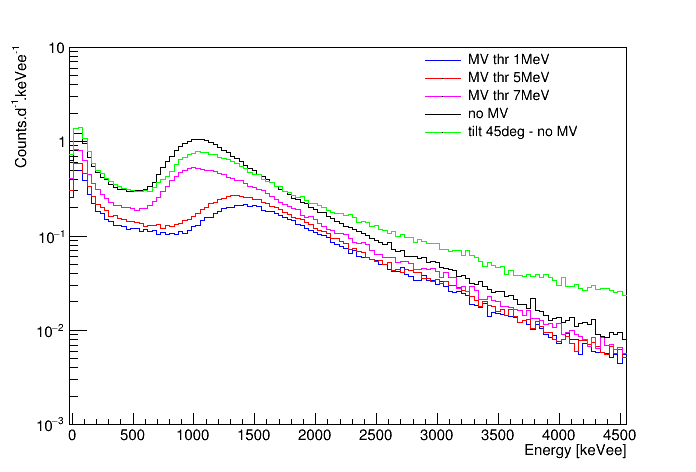

  Primary Entries:          400797
  Secondary Entries:        468366
  Generated primaries:  720000000
  Equivalent time:      23684211 s (274.123 d)
 Nb of primary analysed: 400797
 Nb of events quenched : 1124
 FCN=56.2747 FROM MIGRAD    STATUS=CONVERGED     123 CALLS         124 TOTAL
                     EDM=8.66678e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.17717e+00   7.87536e-03   1.93790e-05  -5.75324e-02
   2  MPV          1.42600e+03   3.28402e+00   1.17898e-02  -1.09095e-04
   3  Sigma        2.41782e+02   2.83214e+00   8.36125e-06  -1.11485e-01
  Primary Entries:          400797
  Secondary Entries:        468366
  Generated primaries:  720000000
  Equivalent time:      23684211 s (274.123 d)
 Nb of primary analysed: 400797
 Nb of events quenched : 1124
  Primary Entries:          400797
  Secondary Entries

In [40]:
TH1D* h_SimuMuons_9inch_1MeV = Put_simu_in_histo("Simulations/Atm_Muons/BS_D09/Analyzer_T_run01-09.root", "9 inches - atmospheric muons (with MV 1 MeV thr)", nbins, hEmin, hEmax, 7.20e8, 0.019, QF_neutrons, 1., true, Resol);
h_SimuMuons_9inch_1MeV->Fit("landau", "R0", "", 1100, 2300);

TH1D* h_SimuMuons_9inch_5MeV = Put_simu_in_histo("Simulations/Atm_Muons/BS_D09/Analyzer_T_run01-09.root", "9 inches - atmospheric muons (with MV 5 MeV thr)", nbins, hEmin, hEmax, 7.20e8, 0.019, QF_neutrons, 5., true, Resol);

TH1D* h_SimuMuons_9inch_7MeV = Put_simu_in_histo("Simulations/Atm_Muons/BS_D09/Analyzer_T_run01-09.root", "9 inches - atmospheric muons (with MV 7 MeV thr)", nbins, hEmin, hEmax, 7.20e8, 0.019, QF_neutrons, 7., true, Resol);
h_SimuMuons_9inch_7MeV->Fit("landau", "R0", "", 800, 2000);

TH1D* h_SimuMuons_9inch_noMV = Put_simu_in_histo("Simulations/Atm_Muons/BS_D09/Analyzer_T_run01-09.root", "9 inches - atmospheric muons (without MV)", nbins, hEmin, hEmax, 7.20e8, 0.019, QF_neutrons, 10., true, Resol);
h_SimuMuons_9inch_noMV->Fit("landau", "R0", "", 800, 1900);

TH1D* h_SimuMuons_9inch45deg_noMV = Put_simu_in_histo("Simulations/Atm_Muons/BS_D09/Analyzer_T_BS9_45deg.root", "9 inches tilt 45deg - atmospheric muons (without MV)", nbins, hEmin, hEmax, 5.0e8, 0.019, QF_neutrons, 10., false, Resol);
h_SimuMuons_9inch45deg_noMV->Fit("landau", "R0", "", 800, 1900);

TCanvas *C = new TCanvas();
C->Draw();
C->SetLogy();
h_SimuMuons_9inch_1MeV->GetYaxis()->SetRangeUser(1e-3, 10);
h_SimuMuons_9inch_1MeV->SetLineColor(kBlue);
h_SimuMuons_9inch_5MeV->SetLineColor(kRed);
h_SimuMuons_9inch_7MeV->SetLineColor(kMagenta);
h_SimuMuons_9inch_noMV->SetLineColor(kBlack);
h_SimuMuons_9inch45deg_noMV->SetLineColor(kGreen);
h_SimuMuons_9inch_1MeV->Draw("HIST");
h_SimuMuons_9inch_5MeV->Draw("HIST SAME");
h_SimuMuons_9inch_7MeV->Draw("HIST SAME");
h_SimuMuons_9inch_noMV->Draw("HIST SAME");
h_SimuMuons_9inch45deg_noMV->Draw("HIST SAME");


h_SimuMuons_9inch_1MeV->SetTitle("");
TLegend* leg0 = new TLegend(0.6, 0.7, 0.89, 0.89);
leg0->AddEntry(h_SimuMuons_9inch_1MeV, "MV thr 1MeV");
leg0->AddEntry(h_SimuMuons_9inch_5MeV, "MV thr 5MeV");
leg0->AddEntry(h_SimuMuons_9inch_7MeV, "MV thr 7MeV");
leg0->AddEntry(h_SimuMuons_9inch_noMV, "no MV");
leg0->AddEntry(h_SimuMuons_9inch45deg_noMV, "tilt 45deg - no MV");
leg0->Draw("SAME");
leg0->SetLineWidth(0);

Without quenching

In [41]:
TH1D* h_SimuMuons_9inch_nq = Put_simu_in_histo_nq("Simulations/Atm_Muons/BS_D09/Analyzer_T_run01-09.root", Form("9 inches - atmospheric muons (with MV %0.f MeV thr)", MVthr_DC), nbins, hEmin, hEmax, 7.20e8, 0.019, MVthr_DC);

 Entries:          400797
 Generated primaries:  720000000
 Equivalent time:      23684211 s (274.123 d)


### Atmospheric neutrons 

With quenching

In [42]:
TH1D* h_SimuNeutrons_9inch = Put_simu_in_histo("Simulations/Atm_Neutr/BS_D09/Analyzer_T_run01-15.root", "9 inches - atmospheric neutrons (with MV)", nbins, hEmin, hEmax, 1.50e9, 0.0134, QF_neutrons, MVthr_DC, true, Resol);

  Primary Entries:          385573
  Secondary Entries:         87314
  Generated primaries:  1500000000
  Equivalent time:      69962687 s (809.753 d)
 Nb of primary analysed: 385573
 Nb of events quenched : 353346


## Background models

Use the simulations to constrain the shape of the background model which will be used to fit the measurements.

### Gamma Background 

The gamma background is fitted with the sum of two exponentials linked by a smooth step function. 

1- First exponential fitted between 1200 and 5000 keVee

In [43]:
TF1* Gamma_background_1 = new TF1("Gamma_background_1", "expo", 1000, 5000); 
Gamma_background_1->SetParNames("Constant []", "Slope [keVee^{-1}]");
Gamma_background_1->SetParameter(0,1);
Gamma_background_1->SetParameter(1,100);
h_SimuGamma_9inch->Fit("Gamma_background_1", "MR", "", 1100, 2800); //Decreasing exponentialin the ROI [1.2; 2.8] MeVee

Gamma_background_1->FixParameter(0, Gamma_background_1->GetParameter(0));
Gamma_background_1->FixParameter(1, Gamma_background_1->GetParameter(1));

 FCN=76.1213 FROM HESSE     STATUS=OK             10 CALLS        1284 TOTAL
                     EDM=2.76975e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant []   2.91423e+00   7.08037e-02   1.32065e-05   4.83216e-02
   2  Slope [keVee^{-1}]  -3.27167e-03   4.98798e-05   9.29787e-09   6.67441e+01


2- Second exponential fitted between 200 and 1000 keVee

In [44]:
TF1* Gamma_background_2 = new TF1("Gamma_background_2", "expo", 100, 1000); 
Gamma_background_2->SetParNames("Constant []", "Slope [keVee^{-1}]");
Gamma_background_2->SetParameter(0,1);
Gamma_background_2->SetParameter(1,100);
h_SimuGamma_9inch->Fit("Gamma_background_2", "MR", "", 300, 1100); 

Gamma_background_2->FixParameter(0, Gamma_background_2->GetParameter(0));
Gamma_background_2->FixParameter(1, Gamma_background_2->GetParameter(1));

 FCN=139.557 FROM HESSE     STATUS=OK             10 CALLS          94 TOTAL
                     EDM=4.38466e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant []   2.39938e+00   1.63954e-02   6.15039e-06   5.56126e-02
   2  Slope [keVee^{-1}]  -3.00077e-03   2.80878e-05   1.05359e-08   3.14470e+01


The global function for the gamma background model is a sum of those two exponentials, linked by a smooth step function (cdf) with two parameters: its position and its width.

In [45]:
Double_t Gammas(Double_t* x, Double_t *par){
    Double_t par_cdf[2]= {par[2], par[3]};
    return (1-cdf(x, par_cdf))*par[0]*Gamma_background_2->Eval(x[0])+cdf(x, par_cdf)*par[1]*Gamma_background_1->Eval(x[0]);
}

In [46]:
TF1* Gamma_shape_9inch = new TF1("Gamma_shape_9inch", Gammas, 300, 5000, 4);
Gamma_shape_9inch->SetParNames("Norm_expo1", "Norm_expo2", "pos cdf", "sigma cdf");
Gamma_shape_9inch->SetParameter(1, 0.98);
Gamma_shape_9inch->SetParameter(2, 0.97);
Gamma_shape_9inch->SetParameter(3, 1000);
Gamma_shape_9inch->SetParameter(4, 81);
Gamma_shape_9inch->SetParLimits(3, 10, 1200);
h_SimuGamma_9inch->Fit("Gamma_shape_9inch", "MR");

std::cout<<"Chi2/NDF = "<<Gamma_shape_9inch->GetChisquare()<<"/"<<Gamma_shape_9inch->GetNDF()-4<<" = "<<Gamma_shape_9inch->GetChisquare()/(Gamma_shape_9inch->GetNDF()-4)<<endl;

 FCN=167.437 FROM HESSE     STATUS=OK             23 CALLS         682 TOTAL
                     EDM=7.57242e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Norm_expo1   9.94051e-01   5.40472e-03   6.81591e-06   1.88455e-02
   2  Norm_expo2   1.00052e+00   1.45300e-02   1.73732e-05  -3.50507e-03
   3  pos cdf      1.00935e+03   1.29332e+01   1.95243e-03  -4.94584e-06
   4  sigma cdf    1.29897e+01   1.40277e+01   3.31077e-05   4.74096e-04
Chi2/NDF = 167.437/65 = 2.57595


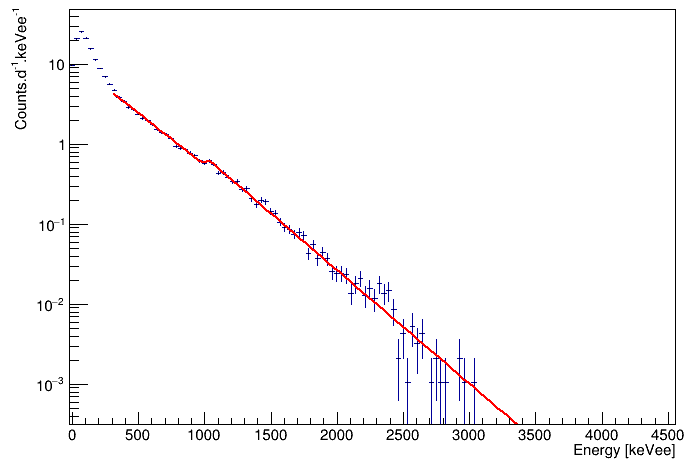

Info in <TCanvas::Print>: png file /Users/cg264002/research/Redaction_These/Figures/Chap3/Neutrons/Gammas_9inch.png has been created


In [47]:
TCanvas* C10 = new TCanvas();
C10->Draw();
C10->SetLogy();

gPad->SetLeftMargin(0.1);
gPad->SetRightMargin(0.03);
gPad->SetBottomMargin(0.1);
gPad->SetTopMargin(0.02);

h_SimuGamma_9inch->SetTitle("");
h_SimuGamma_9inch->Draw("");

C10->SaveAs("/Users/cg264002/research/Redaction_These/Figures/Chap3/Neutrons/Gammas_9inch.png");

### Muon background

The muon background model is made of three components: a Landau for the peak, a pol2 for the plateau region and another Landau for the queue at high energies.

1- Muon Peak with a landau

In [48]:
TF1* Muon_peak_9inch_DC = new TF1("Muon_peak_9inch_DC", "landau", 900, 2000); //Landau in muon peak region
Muon_peak_9inch_DC->SetParNames("Amplitude_mu []", "MPV [keVee]", "[Sigma [keVee]]");
Muon_peak_9inch_DC->SetParameters(1,1100,100);
h_SimuMuons_9inch_DC->Fit("Muon_peak_9inch_DC", "R");

Muon_peak_9inch_DC->FixParameter(0,Muon_peak_9inch_DC->GetParameter(0));
Muon_peak_9inch_DC->FixParameter(1,Muon_peak_9inch_DC->GetParameter(1));
Muon_peak_9inch_DC->FixParameter(2,Muon_peak_9inch_DC->GetParameter(2));

TF1* Muon_peak_9inch_VNS = new TF1("Muon_peak_9inch_VNS", "landau", 800, 2000); //Landau in muon peak region
Muon_peak_9inch_VNS->SetParNames("Amplitude_mu []", "MPV [keVee]", "[Sigma [keVee]]");
Muon_peak_9inch_VNS->SetParameters(1,1100,100);
h_SimuMuons_9inch_VNS->Fit("Muon_peak_9inch_VNS", "R");

Muon_peak_9inch_VNS->FixParameter(0,Muon_peak_9inch_VNS->GetParameter(0));
Muon_peak_9inch_VNS->FixParameter(1,Muon_peak_9inch_VNS->GetParameter(1));
Muon_peak_9inch_VNS->FixParameter(2,Muon_peak_9inch_VNS->GetParameter(2));

 FCN=64.4019 FROM MIGRAD    STATUS=CONVERGED     135 CALLS         136 TOTAL
                     EDM=2.66506e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Amplitude_mu []   3.69913e+01   1.80996e-01   4.52611e-04   5.09081e-05
   2  MPV [keVee]   1.07737e+03   5.43243e+00   1.05257e-02   1.83274e-06
   3  [Sigma [keVee]]   2.28744e+02   2.30481e+00   6.08440e-06   4.40026e-03
 FCN=64.5171 FROM MIGRAD    STATUS=CONVERGED     125 CALLS         126 TOTAL
                     EDM=1.14447e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Amplitude_mu []   3.68561e+01   1.61861e-01   4.26755e-04  -3.43992e-03
   2  MPV [keVee]   1.08860e+03   2.29145e+00   8.25830e-03   3.64578e-06
   3  [Sigma [ke

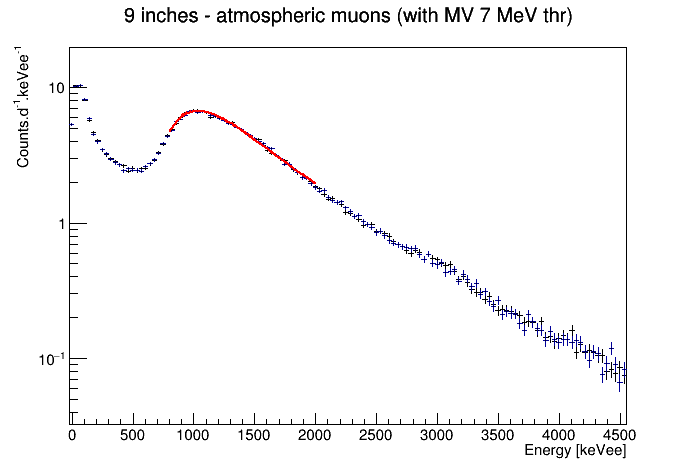

In [49]:
TCanvas* C11 = new TCanvas();
C11->Draw();
C11->SetLogy();
h_SimuMuons_9inch_DC->SetLineColor(kBlack);
h_SimuMuons_9inch_DC->Draw("");
h_SimuMuons_9inch_VNS->Draw("same");

2- Muon Plateau with a pol2 between 400 and 1200 keVee

In [50]:
TF1* Muon_plateau_9inch_DC = new TF1("Muon_plateau_9inch_DC", "pol2", 200, 900); 
Muon_plateau_9inch_DC->SetParNames("a", "b", "c");
h_SimuMuons_9inch_DC->Fit("Muon_plateau_9inch_DC", "R");

Muon_plateau_9inch_DC->FixParameter(0,Muon_plateau_9inch_DC->GetParameter(0));
Muon_plateau_9inch_DC->FixParameter(1,Muon_plateau_9inch_DC->GetParameter(1));
Muon_plateau_9inch_DC->FixParameter(2,Muon_plateau_9inch_DC->GetParameter(2));

TF1* Muon_plateau_9inch_VNS = new TF1("Muon_plateau_9inch_VNS", "pol2", 200, 900); 
Muon_plateau_9inch_VNS->SetParNames("a", "b", "c");
h_SimuMuons_9inch_VNS->Fit("Muon_plateau_9inch_VNS", "R");

Muon_plateau_9inch_VNS->FixParameter(0,Muon_plateau_9inch_VNS->GetParameter(0));
Muon_plateau_9inch_VNS->FixParameter(1,Muon_plateau_9inch_VNS->GetParameter(1));
Muon_plateau_9inch_VNS->FixParameter(2,Muon_plateau_9inch_VNS->GetParameter(2));


****************************************
Minimizer is Linear / Migrad
Chi2                      =      72.2644
NDf                       =           17
a                         =      7.56995   +/-   0.114363    
b                         =   -0.0213292   +/-   0.000452191 
c                         =  2.18525e-05   +/-   4.13629e-07 

****************************************
Minimizer is Linear / Migrad
Chi2                      =      59.1263
NDf                       =           17
a                         =      7.52591   +/-   0.114078    
b                         =   -0.0212433   +/-   0.000450912 
c                         =  2.18066e-05   +/-   4.1236e-07  


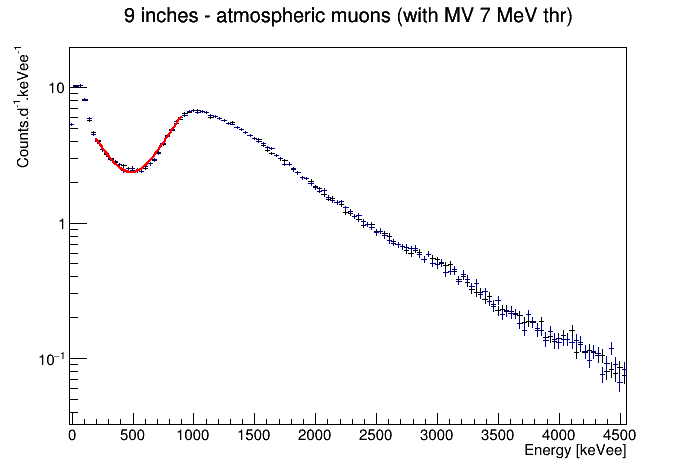

In [51]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
h_SimuMuons_9inch_DC->Draw("");
h_SimuMuons_9inch_VNS->Draw("same");

3- Function for the queue at high energies betweenn 2700 and 4400 keVee. It is the sum of two exponential functions with a gaussian in the middle for the neutron peak.

In [52]:
TF1* Muon_queue_9inch_DC_start = new TF1("Muon_queue_9inch_DC_start", "expo(0)", 1800, 2700); 
Muon_queue_9inch_DC_start->SetParameter(0, -10);
Muon_queue_9inch_DC_start->SetParameter(1, -0.003);
h_SimuMuons_9inch_DC->Fit("Muon_queue_9inch_DC_start", "R");

TF1* Muon_queue_9inch_DC_end = new TF1("Muon_queue_9inch_DC_end", "expo(0)", 3800, 5500); 
Muon_queue_9inch_DC_end->SetParameter(0, -10);
Muon_queue_9inch_DC_end->SetParameter(1, -0.003);
h_SimuMuons_9inch_DC->Fit("Muon_queue_9inch_DC_end", "R");

TF1* Muon_queue_secn_9inch_DC = new TF1("Muon_queue_secn_9inch_DC", "expo(0)+gaus(2)+expo(5)", 1800, 5500); 
//Muon_queue_9inch->SetParNames("Norm", "slope", "Norm_NP", "mean_NP", "sigma_NP");
Muon_queue_secn_9inch_DC->SetParameter(0, Muon_queue_9inch_DC_start->GetParameter(0));
Muon_queue_secn_9inch_DC->SetParameter(1, Muon_queue_9inch_DC_start->GetParameter(1));
Muon_queue_secn_9inch_DC->SetParameter(2, 0.011);
Muon_queue_secn_9inch_DC->SetParameter(3, 3500);
Muon_queue_secn_9inch_DC->SetParameter(4, 300);
Muon_queue_secn_9inch_DC->SetParameter(5, Muon_queue_9inch_DC_end->GetParameter(0));
Muon_queue_secn_9inch_DC->SetParameter(6, Muon_queue_9inch_DC_end->GetParameter(1));

Muon_queue_secn_9inch_DC->SetParLimits(3, 3000, 3800);
Muon_queue_secn_9inch_DC->SetParLimits(2, 0., 1000);
Muon_queue_secn_9inch_DC->SetParLimits(4, 100, 600);
h_SimuMuons_9inch_DC->Fit("Muon_queue_secn_9inch_DC", "R");

Muon_queue_secn_9inch_DC->FixParameter(0, Muon_queue_secn_9inch_DC->GetParameter(0));
Muon_queue_secn_9inch_DC->FixParameter(1, Muon_queue_secn_9inch_DC->GetParameter(1));
Muon_queue_secn_9inch_DC->FixParameter(2, Muon_queue_secn_9inch_DC->GetParameter(2));
Muon_queue_secn_9inch_DC->FixParameter(3, Muon_queue_secn_9inch_DC->GetParameter(3));
Muon_queue_secn_9inch_DC->FixParameter(4, Muon_queue_secn_9inch_DC->GetParameter(4));
Muon_queue_secn_9inch_DC->FixParameter(5, Muon_queue_secn_9inch_DC->GetParameter(5));
Muon_queue_secn_9inch_DC->FixParameter(6, Muon_queue_secn_9inch_DC->GetParameter(6));

 FCN=28.7412 FROM MIGRAD    STATUS=CONVERGED      43 CALLS          44 TOTAL
                     EDM=7.25705e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.62278e+00   5.53807e-02   1.64396e-05  -1.40730e-01
   2  Slope       -1.50230e-03   2.55889e-05   7.58838e-09  -2.70068e+02
 FCN=17.397 FROM MIGRAD    STATUS=CONVERGED      51 CALLS          52 TOTAL
                     EDM=2.72623e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.34529e+00   4.53709e-01   4.79508e-05  -1.13276e-03
   2  Slope       -1.07591e-03   1.09796e-04   1.16023e-08  -1.13961e+01
 FCN=53.2801 FROM HESSE     STATUS=OK             50 CALLS        1459 TOTAL
                     EDM=2.504

In [53]:
TF1* Muon_queue_9inch_VNS_start = new TF1("Muon_queue_9inch_VNS_start", "expo(0)", 1800, 2700);
Muon_queue_9inch_VNS_start->SetParameter(0, -10);
Muon_queue_9inch_VNS_start->SetParameter(1, -0.003);
h_SimuMuons_9inch_VNS->Fit("Muon_queue_9inch_VNS_start", "R");

TF1* Muon_queue_9inch_VNS_end = new TF1("Muon_queue_9inch_VNS_end", "expo(0)", 3800, 5500);
Muon_queue_9inch_VNS_end->SetParameter(0, -10);
Muon_queue_9inch_VNS_end->SetParameter(1, -0.003);
h_SimuMuons_9inch_VNS->Fit("Muon_queue_9inch_VNS_end", "R");

TF1* Muon_queue_secn_9inch_VNS = new TF1("Muon_queue_secn_9inch_VNS", "expo(0)+gaus(2)+expo(5)", 1800, 5500);
//Muon_queue_9inch->SetParNames("Norm", "slope", "Norm_NP", "mean_NP", "sigma_NP");
Muon_queue_secn_9inch_VNS->SetParameter(0, Muon_queue_9inch_VNS_start->GetParameter(0));
Muon_queue_secn_9inch_VNS->SetParameter(1, Muon_queue_9inch_VNS_start->GetParameter(1));
Muon_queue_secn_9inch_VNS->SetParameter(2, 0.011);
Muon_queue_secn_9inch_VNS->SetParameter(3, 3500);
Muon_queue_secn_9inch_VNS->SetParameter(4, 300);
Muon_queue_secn_9inch_VNS->SetParameter(5, Muon_queue_9inch_VNS_end->GetParameter(0));
Muon_queue_secn_9inch_VNS->SetParameter(6, Muon_queue_9inch_VNS_end->GetParameter(1));

Muon_queue_secn_9inch_VNS->SetParLimits(3, 3000, 3800);
Muon_queue_secn_9inch_VNS->SetParLimits(2, 0., 1000);
Muon_queue_secn_9inch_VNS->SetParLimits(4, 100, 600);
h_SimuMuons_9inch_VNS->Fit("Muon_queue_secn_9inch_VNS", "R");

Muon_queue_secn_9inch_VNS->FixParameter(0, Muon_queue_secn_9inch_VNS->GetParameter(0));
Muon_queue_secn_9inch_VNS->FixParameter(1, Muon_queue_secn_9inch_VNS->GetParameter(1));
Muon_queue_secn_9inch_VNS->FixParameter(2, Muon_queue_secn_9inch_VNS->GetParameter(2));
Muon_queue_secn_9inch_VNS->FixParameter(3, Muon_queue_secn_9inch_VNS->GetParameter(3));
Muon_queue_secn_9inch_VNS->FixParameter(4, Muon_queue_secn_9inch_VNS->GetParameter(4));
Muon_queue_secn_9inch_VNS->FixParameter(5, Muon_queue_secn_9inch_VNS->GetParameter(5));
Muon_queue_secn_9inch_VNS->FixParameter(6, Muon_queue_secn_9inch_VNS->GetParameter(6));

 FCN=17.2112 FROM MIGRAD    STATUS=CONVERGED      49 CALLS          50 TOTAL
                     EDM=4.3232e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.63839e+00   5.46077e-02   1.28455e-05   1.34785e-04
   2  Slope       -1.50798e-03   2.52321e-05   5.93540e-09   4.01627e-01
 FCN=21.4401 FROM MIGRAD    STATUS=CONVERGED      47 CALLS          48 TOTAL
                     EDM=1.6472e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.04000e+00   4.61455e-01   5.30146e-05   2.34320e-03
   2  Slope       -1.00374e-03   1.11584e-04   1.28193e-08   9.85982e+00
 FCN=74.7543 FROM HESSE     STATUS=OK             50 CALLS        1164 TOTAL
                     EDM=1.7749

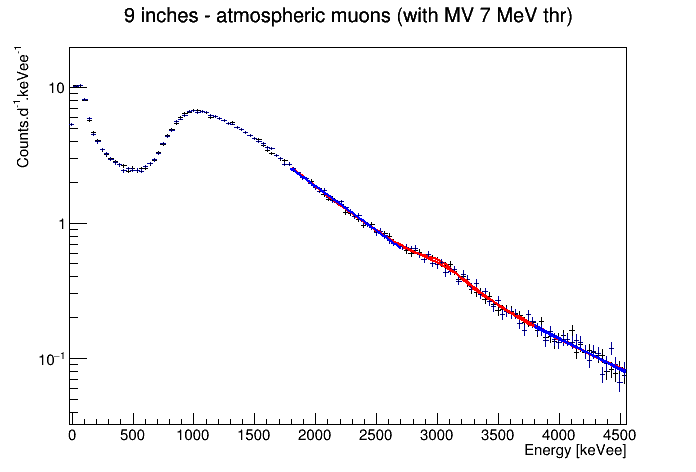

In [54]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
h_SimuMuons_9inch_DC->Draw("");
Muon_queue_secn_9inch_DC->Draw("SAME");
Muon_queue_9inch_DC_end->SetLineColor(kBlue);
Muon_queue_9inch_DC_end->Draw("SAME");
Muon_queue_9inch_DC_start->SetLineColor(kBlue);
Muon_queue_9inch_DC_start->Draw("SAME");
h_SimuMuons_9inch_VNS->Draw("SAME");
Muon_queue_secn_9inch_VNS->Draw("SAME");
Muon_queue_9inch_VNS_end->SetLineColor(kBlue);
Muon_queue_9inch_VNS_end->Draw("SAME");
Muon_queue_9inch_VNS_start->SetLineColor(kBlue);
Muon_queue_9inch_VNS_start->Draw("SAME");

The final function is the sum of those three contributions linked by two step functions (cdf) one at low energy to link the plateau with the muon peak and one at high energies to link the muon peak to the queue.

In [55]:
Double_t Muons_9inch_DC(Double_t* x, Double_t *par){
    Double_t par_cdf[2]= {par[3], par[4]};
    Double_t par_cdf2[2]= {par[5], par[6]};
    return (1-cdf(x, par_cdf))*par[0]*Muon_plateau_9inch_DC->Eval(x[0])+cdf(x, par_cdf)*(1-cdf(x, par_cdf2))*par[1]*Muon_peak_9inch_DC->Eval(x[0])+cdf(x, par_cdf2)*par[2]*Muon_queue_secn_9inch_DC->Eval(x[0]);
}

In [56]:
Double_t Muons_9inch_VNS(Double_t* x, Double_t *par){
    Double_t par_cdf[2]= {par[3], par[4]};
    Double_t par_cdf2[2]= {par[5], par[6]};
    return (1-cdf(x, par_cdf))*par[0]*Muon_plateau_9inch_VNS->Eval(x[0])+cdf(x, par_cdf)*(1-cdf(x, par_cdf2))*par[1]*Muon_peak_9inch_VNS->Eval(x[0])+cdf(x, par_cdf2)*par[2]*Muon_queue_secn_9inch_VNS->Eval(x[0]);
}

In [57]:
TF1* Muon_shape_9inch_DC = new TF1("Muon_shape_9inch_DC", Muons_9inch_DC, 150, 5500, 7);
Muon_shape_9inch_DC->SetParNames("Norm_plateau", "Norm_muonpeak", "Norm_muonqueue", "pos cdf", "sigma cdf", "pos cdf2", "sigma cdf2");

Muon_shape_9inch_DC->SetParameter(0, 1);
Muon_shape_9inch_DC->SetParameter(1, 1);
Muon_shape_9inch_DC->SetParameter(2, 1);

Muon_shape_9inch_DC->SetParameter(3, 1000);
Muon_shape_9inch_DC->SetParameter(4, 400);
Muon_shape_9inch_DC->SetParLimits(4, 0, 500);
Muon_shape_9inch_DC->SetParLimits(3, 800, 1400);
Muon_shape_9inch_DC->SetParameter(5, 2900);
Muon_shape_9inch_DC->SetParLimits(5, 2000, 6000);
Muon_shape_9inch_DC->SetParameter(6, 400);
Muon_shape_9inch_DC->SetParLimits(6, 0, 500);
h_SimuMuons_9inch_DC->Fit("Muon_shape_9inch_DC", "R0");

 FCN=165.937 FROM MIGRAD    STATUS=CONVERGED     705 CALLS         706 TOTAL
                     EDM=1.12017e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Norm_plateau   9.99553e-01   5.49623e-03   3.23552e-05  -1.28261e-01
   2  Norm_muonpeak   9.96707e-01   3.18730e-03   1.92894e-05  -3.03305e-02
   3  Norm_muonqueue   9.97061e-01   6.13185e-03   3.82101e-05   1.64217e-01
   4  pos cdf      8.00000e+02   3.23562e+01   2.95758e-03** at limit **
   5  sigma cdf    1.18107e+02   1.01484e+01   2.76792e-04   1.19675e-02
   6  pos cdf2     2.00000e+03   2.58889e+01   1.01612e-03** at limit **
   7  sigma cdf2   3.94726e+01   3.35943e+01   1.56734e-03   1.45647e-03


In [58]:
TF1* Muon_shape_9inch_VNS = new TF1("Muon_shape_9inch_VNS", Muons_9inch_VNS, 150, 5500, 7);
Muon_shape_9inch_VNS->SetParNames("Norm_plateau", "Norm_muonpeak", "Norm_muonqueue", "pos cdf", "sigma cdf", "pos cdf2", "sigma cdf2");

Muon_shape_9inch_VNS->SetParameter(0, 1);
Muon_shape_9inch_VNS->SetParameter(1, 1);
Muon_shape_9inch_VNS->SetParameter(2, 1);

Muon_shape_9inch_VNS->SetParameter(3, 1000);
Muon_shape_9inch_VNS->SetParameter(4, 400);
Muon_shape_9inch_VNS->SetParLimits(4, 0, 500);
Muon_shape_9inch_VNS->SetParLimits(3, 800, 1400);
Muon_shape_9inch_VNS->SetParameter(5, 2900);
Muon_shape_9inch_VNS->SetParLimits(5, 2000, 6000);
Muon_shape_9inch_VNS->SetParameter(6, 400);
Muon_shape_9inch_VNS->SetParLimits(6, 0, 500);
h_SimuMuons_9inch_VNS->Fit("Muon_shape_9inch_VNS", "R0");

 FCN=158.383 FROM MIGRAD    STATUS=CONVERGED     626 CALLS         627 TOTAL
                     EDM=2.53402e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   6.4 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Norm_plateau   1.00498e+00   5.56657e-03   1.44909e-06   3.80740e-04
   2  Norm_muonpeak   1.00014e+00   3.31692e-03   2.72851e-06   3.25379e-02
   3  Norm_muonqueue   9.92932e-01   6.99992e-03  -3.23444e-06  -1.08990e-02
   4  pos cdf      8.00000e+02   6.61837e+00  -4.19950e-05** at limit **
   5  sigma cdf    1.14323e+02   9.92729e+00  -3.79890e-05   5.10182e-03
   6  pos cdf2     2.00000e+03   3.35474e+01   2.18118e-04** at limit **
   7  sigma cdf2   2.41323e+02   8.94095e+01   1.22465e-04   2.25653e-03


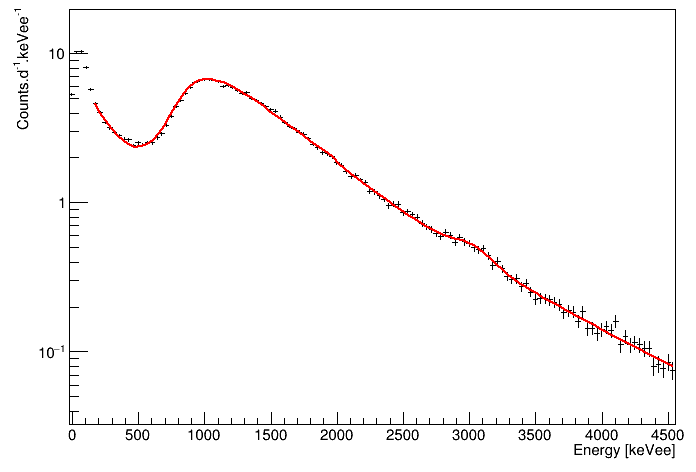

Chi2/NDF = 158.383/112 = 1.41413


Info in <TCanvas::Print>: png file /Users/cg264002/research/Redaction_These/Figures/Chap3/Neutrons/Muons_9inch.png has been created


In [59]:
TCanvas* C11 = new TCanvas();
C11->Draw();
C11->SetLogy();
gPad->SetLeftMargin(0.1);
gPad->SetRightMargin(0.03);
gPad->SetBottomMargin(0.1);
gPad->SetTopMargin(0.02);

h_SimuMuons_9inch_DC->SetTitle("");
h_SimuMuons_9inch_DC->Draw("");
Muon_shape_9inch_DC->Draw("SAME");

//h_SimuMuons_9inch_VNS->Draw("SAME");
//Muon_shape_9inch_VNS->Draw("SAME");

C->SaveAs("/Users/cg264002/research/Redaction_These/Figures/Chap3/Neutrons/Muons_9inch.png");

std::cout<<"Chi2/NDF = "<<Muon_shape_9inch_VNS->GetChisquare()<<"/"<<Muon_shape_9inch_VNS->GetNDF()-4<<" = "<<Muon_shape_9inch_VNS->GetChisquare()/(Muon_shape_9inch_VNS->GetNDF()-4)<<endl;

The shapes of gammas and muons background contributions are fixed. The global background function is the sum of the two contributions with their weight as parameters.

In [60]:
Gamma_shape_9inch->FixParameter(1, Gamma_shape_9inch->GetParameter(1));
Gamma_shape_9inch->FixParameter(0, Gamma_shape_9inch->GetParameter(0));
Muon_shape_9inch_DC->FixParameter(0, Muon_shape_9inch_DC->GetParameter(0));
Muon_shape_9inch_DC->FixParameter(1, Muon_shape_9inch_DC->GetParameter(1));
Muon_shape_9inch_DC->FixParameter(2, Muon_shape_9inch_DC->GetParameter(2));
Muon_shape_9inch_DC->FixParameter(3, Muon_shape_9inch_DC->GetParameter(3));
Muon_shape_9inch_DC->FixParameter(4, Muon_shape_9inch_DC->GetParameter(4));
Muon_shape_9inch_DC->FixParameter(5, Muon_shape_9inch_DC->GetParameter(5));
Muon_shape_9inch_DC->FixParameter(6, Muon_shape_9inch_DC->GetParameter(6));

Muon_shape_9inch_VNS->FixParameter(0, Muon_shape_9inch_VNS->GetParameter(0));
Muon_shape_9inch_VNS->FixParameter(1, Muon_shape_9inch_VNS->GetParameter(1));
Muon_shape_9inch_VNS->FixParameter(2, Muon_shape_9inch_VNS->GetParameter(2));
Muon_shape_9inch_VNS->FixParameter(3, Muon_shape_9inch_VNS->GetParameter(3));
Muon_shape_9inch_VNS->FixParameter(4, Muon_shape_9inch_VNS->GetParameter(4));
Muon_shape_9inch_VNS->FixParameter(5, Muon_shape_9inch_VNS->GetParameter(5));
Muon_shape_9inch_VNS->FixParameter(6, Muon_shape_9inch_VNS->GetParameter(6));

In [61]:
Double_t MuonsplusGammas_9inch_DC(Double_t* x, Double_t *par){
    return par[0]*Muon_shape_9inch_DC->Eval(x[0])+par[1]*Gamma_shape_9inch->Eval(x[0]);
}

In [62]:
Double_t MuonsplusGammas_9inch_VNS(Double_t* x, Double_t *par){
    return par[0]*Muon_shape_9inch_VNS->Eval(x[0])+par[1]*Gamma_shape_9inch->Eval(x[0]);
}

Then, the signal is added to the background. 

### Neutron Peak

Fit of the neutron peak obtained in the simulation (cross check but not used to constrain the signal model). 

In [63]:
TF1* Neutron_peak_Gaus = new TF1("Neutron_peak_Gaus", "[0]*TMath::Gaus(x, [1], [2])", 2500, 5000);
Neutron_peak_Gaus->SetParNames("Amplitude [Counts/d/keVee]", "#mu [keVee]", "#sigma [keVee]");
Neutron_peak_Gaus->SetParameter(0, 0.1);
Neutron_peak_Gaus->SetParameter(1, 3500);
Neutron_peak_Gaus->SetParameter(2, 300);

h_SimuNeutrons_9inch->Fit("Neutron_peak_Gaus", "R");

 FCN=452.501 FROM MIGRAD    STATUS=CONVERGED     160 CALLS         161 TOTAL
                     EDM=9.50802e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Amplitude [Counts/d/keVee]   7.14518e-01   1.60279e-03   1.32121e-05  -1.05368e-02
   2  #mu [keVee]   2.98502e+03   4.23355e-01   4.30245e-03  -8.23813e-05
   3  #sigma [keVee]   2.21818e+02   3.37276e-01   2.73135e-03  -1.24432e-04


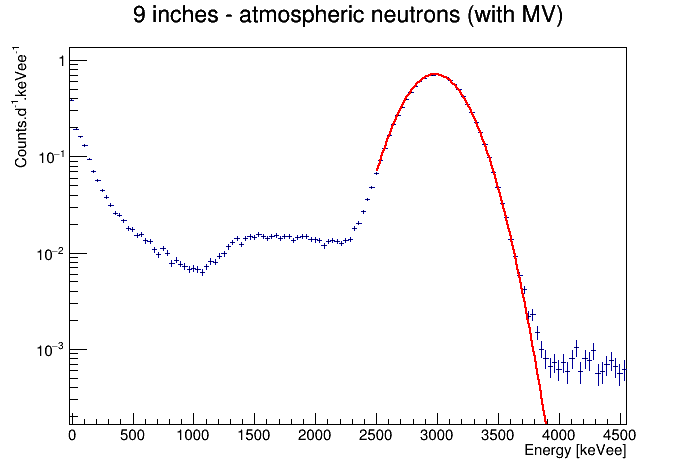

In [64]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
h_SimuNeutrons_9inch->Draw("");

In [65]:
TF1* plateau_Neutron = new TF1("plateau_Neutron", "[0]*x +[1]", 4800, 5800);
plateau_Neutron->SetParameter(0, 1e-2);
plateau_Neutron->SetParameter(1, 5500);

h_SimuNeutrons_9inch->Fit("plateau_Neutron", "R");

plateau_Neutron->FixParameter(0, plateau_Neutron->GetParameter(0));
plateau_Neutron->FixParameter(1, plateau_Neutron->GetParameter(1));

Warning in <ROOT::Fit::FillData>: fit range is outside histogram range, no fit data for xaxis
Warning in <Fit>: Fit data is empty 


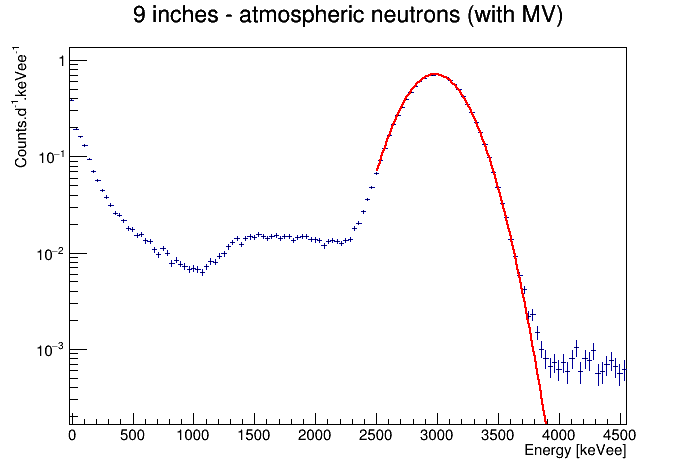

In [66]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
h_SimuNeutrons_9inch->Draw("");

In [67]:
Double_t Neutron_PeakAndHighE_9inch(Double_t* x, Double_t *par){
    Double_t par_cdf[2]= {par[4], par[5]};
    return par[0]*TMath::Gaus(x[0], par[1], par[2])+cdf(x, par_cdf)*par[3]*plateau_Neutron->Eval(x[0]);
}

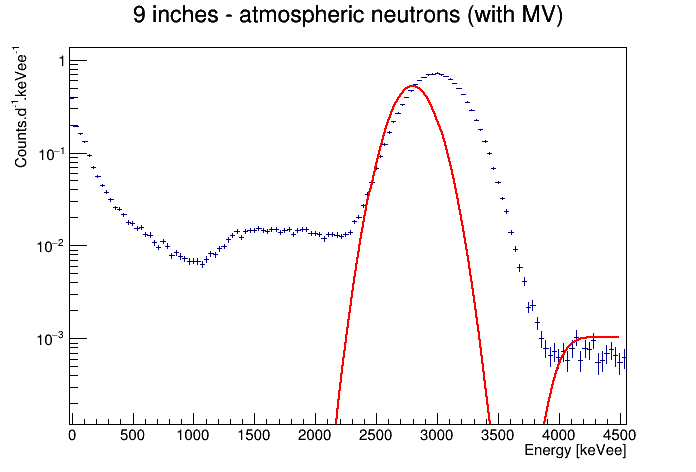

 FCN=150681 FROM MIGRAD    STATUS=FAILED        181 CALLS         182 TOTAL
                     EDM=1.84645e+07    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.22128e-01   1.29228e+00   0.00000e+00  -4.25183e+04
   2  p1           2.80136e+03   1.00000e+00   0.00000e+00  -7.34096e+02
   3  p2           1.54660e+02   1.29437e+00   0.00000e+00  -5.78019e+02
   4  p3           1.86088e-07   1.29228e+00  -0.00000e+00   1.53187e+09
   5  p4           4.00000e+03     fixed    
   6  p5           1.00000e+02     fixed    


Warning in <Fit>: Abnormal termination of minimization.


In [68]:
TF1* Neutron_shape = new TF1("Neutron_shape", "Neutron_PeakAndHighE_9inch", 1000, 4500, 6);
Neutron_shape->SetParameter(0, Neutron_peak_Gaus->GetParameter(0));
Neutron_shape->SetParameter(1, Neutron_peak_Gaus->GetParameter(1));
Neutron_shape->SetParameter(2, Neutron_peak_Gaus->GetParameter(2));
Neutron_shape->SetParameter(3, 1);
Neutron_shape->FixParameter(4, 4000);
Neutron_shape->FixParameter(5, 100);

h_SimuNeutrons_9inch->Fit("Neutron_shape", "R", "", 2000, 4500);

TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
h_SimuNeutrons_9inch->Draw("");

Neutron_shape->FixParameter(0, Neutron_shape->GetParameter(0));
Neutron_shape->FixParameter(3, Neutron_shape->GetParameter(3));
Neutron_shape->FixParameter(4, Neutron_shape->GetParameter(4));
Neutron_shape->FixParameter(5, Neutron_shape->GetParameter(5));

The signal model is the sum of the two background contributions (gammas and muons) and a gaussian. It has 5 parameters : gamma weight, muon weight, neutron weight, neutron peak position and neutron peak width. 

Remark: given the contribution of neutrons at low energies and the kind of plateau before the neutron capture peak, it could be interesting to improve the model by including those parts of the neutron spectrum in the signal model function. 

In [69]:
Double_t SignalPlusBackground_9inch_DC(Double_t* x, Double_t *par){
    Neutron_shape->SetParameter(1, par[3]);
    Neutron_shape->SetParameter(2, par[4]);
    return par[0]*Muon_shape_9inch_DC->Eval(x[0])+par[1]*Gamma_shape_9inch->Eval(x[0])+par[2]*Neutron_shape->Eval(x[0]);
}

In [70]:
Double_t SignalPlusBackground_9inch_VNS(Double_t* x, Double_t *par){
    Neutron_shape->SetParameter(1, par[3]);
    Neutron_shape->SetParameter(2, par[4]);
    return par[0]*Muon_shape_9inch_VNS->Eval(x[0])+par[1]*Gamma_shape_9inch->Eval(x[0])+par[2]*Neutron_shape->Eval(x[0]);
}

In [71]:
Double_t Gammas_9inch(Double_t* x, Double_t *par){
    return par[0]*Gamma_shape_9inch->Eval(x[0]);
}

In [72]:
Double_t Muons_9inch_DC(Double_t* x, Double_t *par){
    return par[0]*Muon_shape_9inch_DC->Eval(x[0]);
}

In [73]:
Double_t Muons_9inch_VNS(Double_t* x, Double_t *par){
    return par[0]*Muon_shape_9inch_VNS->Eval(x[0]);
}

In [74]:
Double_t Neutrons_9inch(Double_t* x, Double_t *par){
    Neutron_shape->SetParameter(1, par[1]);
    Neutron_shape->SetParameter(2, par[2]);
    return par[0]*Neutron_shape->Eval(x[0]);
}

In [75]:
TF1* Sum_background_9inch_DC = new TF1("Sum_background_9inch_DC", MuonsplusGammas_9inch_DC, Emin_fit, Emax_fit, 2);
Sum_background_9inch_DC->SetParNames("Norm_muons", "Norm_gammas");

TF1* Sum_background_9inch_VNS = new TF1("Sum_background_9inch_VNS", MuonsplusGammas_9inch_VNS, Emin_fit, Emax_fit, 2);
Sum_background_9inch_VNS->SetParNames("Norm_muons", "Norm_gammas");

In [76]:
TF1* Muon_background_9inch_DC = new TF1("Muon_background_9inch_DC", Muons_9inch_DC, Emin_fit, Emax_fit, 1);
Muon_background_9inch_DC->SetParNames("Norm_muons");

TF1* Muon_background_9inch_VNS = new TF1("Muon_background_9inch_VNS", Muons_9inch_VNS, Emin_fit, Emax_fit, 1);
Muon_background_9inch_VNS->SetParNames("Norm_muons");

In [77]:
TF1* Gamma_background_9inch = new TF1("Gamma_background_9inch", Gammas_9inch, Emin_fit, Emax_fit, 1);
Gamma_background_9inch->SetParNames("Norm_gammas");

In [78]:
TF1* Neutron_signal_9inch = new TF1("Neutron_signal_9inch", Neutrons_9inch, Emin_fit, Emax_fit, 3);
Gamma_background_9inch->SetParNames("Norm_Neutrons");

In [79]:
TF1* SignalandBackground_9inch_DC = new TF1("SignalandBackground_9inch_DC", SignalPlusBackground_9inch_DC, Emin_fit, Emax_fit, 5);
SignalandBackground_9inch_DC->SetParNames("Norm_muons", "Norm_gammas", "Norm_Neutr", "Mean_gauss", "Sigma_gauss");

TF1* SignalandBackground_9inch_VNS = new TF1("SignalandBackground_9inch_VNS", SignalPlusBackground_9inch_VNS, Emin_fit, Emax_fit, 5);
SignalandBackground_9inch_VNS->SetParNames("Norm_muons", "Norm_gammas", "Norm_Neutr", "Mean_gauss", "Sigma_gauss");

## Fit

Fitting procedure : the shapes of background contributions have been constrained by the fit of the simulations before. The weight of each contribution is fitted as well as the neutron peak (in shape and norm). <br>  <br> 
The number of events in the neutron peak are calculated as follow: <br>
<b>N_ev_tot</b> = The total number of events in the histogram in the peak region [2500, 4500 keVee]. The uncertainty is statistical only. <br>
<b>N_ev_bckg</b> = The integral of the background from fit result in the peak region. The uncertainty is obtained from the fit parameters errors on muon and gamma normalization.  <br>
<b>N_ev_in_neutron_peak</b> = N_ev_tot-N_ev_bckg with the error propagation from the two previous errors quoted.

### DCHut
Fit of the data at surface.

In [80]:
SignalandBackground_9inch_DC->SetParameter(3, 3000);
SignalandBackground_9inch_DC->SetParLimits(3, 2800, 3500);
SignalandBackground_9inch_DC->SetParameter(2, 1);

if (SignalandBackground_9inch_DC->GetParameter(4)==0) SignalandBackground_9inch_DC->SetParameter(4, Resol_NP);


TFitResultPtr r = hCal_DC_9inch->Fit(SignalandBackground_9inch_DC, "S0", "", 600, 6000);


TMatrixD CovMat_DC = r->GetCovarianceMatrix();

//CovMat_DC.Print();

Double_t err_norm_NP_DC = sqrt(CovMat_DC(2,2));
Double_t norm_NP_DC = SignalandBackground_9inch_DC->GetParameter(2);

Double_t err_norm_Bkg_DC = sqrt(CovMat_DC(0,0)+CovMat_DC(1,1)+2*CovMat_DC(0,1));
Double_t norm_Bckg_DC = SignalandBackground_9inch_DC->GetParameter(0)+SignalandBackground_9inch_DC->GetParameter(1);

Double_t Norm_mu_9_DC = SignalandBackground_9inch_DC->GetParameter(0);
Double_t err_Norm_mu_9_DC = SignalandBackground_9inch_DC->GetParError(0);

Sum_background_9inch_DC->SetParameter(0, SignalandBackground_9inch_DC->GetParameter(0));
Sum_background_9inch_DC->SetParameter(1, SignalandBackground_9inch_DC->GetParameter(1));

Muon_background_9inch_DC->SetParameter(0, SignalandBackground_9inch_DC->GetParameter(0));
Gamma_background_9inch->SetParameter(0, SignalandBackground_9inch_DC->GetParameter(1));

Neutron_signal_9inch->SetParameter(0, SignalandBackground_9inch_DC->GetParameter(2));
Neutron_signal_9inch->SetParameter(1, SignalandBackground_9inch_DC->GetParameter(3));
Neutron_signal_9inch->SetParameter(2, SignalandBackground_9inch_DC->GetParameter(4));

double Emin=2500;
double Emax = 3900;

Double_t N_ev_tot_DC = SignalandBackground_9inch_DC->Integral(Emin, Emax);
Double_t N_ev_NP_DC = Neutron_signal_9inch->Integral(Emin, Emax);
Double_t err_N_ev_NP_DC = (err_norm_NP_DC/norm_NP_DC)*Neutron_signal_9inch->Integral(Emin, Emax);
Double_t N_ev_BKG_DC = Sum_background_9inch_DC->Integral(Emin, Emax);
Double_t err_N_ev_BKG_DC = (err_norm_Bkg_DC/norm_Bckg_DC)*Sum_background_9inch_DC->Integral(Emin, Emax);

Double_t err_N_ev_data_DC;
Double_t N_ev_data_DC = hCal_DC_9inch->IntegralAndError(hCal_DC_9inch->FindBin(Emin), hCal_DC_9inch->FindBin(Emax), err_N_ev_data_DC, "width");

Double_t err_N_ev_data_NP_DC = sqrt(err_N_ev_data_DC*err_N_ev_data_DC + err_N_ev_BKG_DC*err_N_ev_BKG_DC);
Double_t N_ev_data_NP_DC = N_ev_data_DC-N_ev_BKG_DC;

cout<<"\nChi2/ndf = "<<SignalandBackground_9inch_DC->GetChisquare()<<"/"<<SignalandBackground_9inch_DC->GetNDF()<<" = "<<SignalandBackground_9inch_DC->GetChisquare()/SignalandBackground_9inch_DC->GetNDF()<<endl;
cout<<"\nTotal N_ev in peak region = "<<N_ev_data_DC<<" ev/d +- "<<err_N_ev_data_DC<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from fit = "<<N_ev_NP_DC<<" ev/d +- "<<err_N_ev_NP_DC<<" ev/d (error from normalization error only!)"<<endl;
cout<<"N_ev in background = "<<N_ev_BKG_DC<<" ev/d +- "<<err_N_ev_BKG_DC<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from data - bckg = "<<N_ev_data_NP_DC<<" ev/d +- "<<err_N_ev_data_NP_DC<<" ev/d"<<endl;

SignalandBackground_9inch_VNS->FixParameter(4, SignalandBackground_9inch_DC->GetParameter(4)); //Fix the sigma value of the neutron peak

 FCN=251.393 FROM MIGRAD    STATUS=CONVERGED     157 CALLS         158 TOTAL
                     EDM=4.04977e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Norm_muons   1.73685e-01   1.26792e-03   7.44158e-06   2.69826e-01
   2  Norm_gammas   7.95576e-01   1.12535e-02   6.84847e-05   1.32282e-02
   3  Norm_Neutr   4.20253e-01   9.81751e-03   5.84291e-05   1.11508e-02
   4  Mean_gauss   3.06555e+03   5.87735e+00   1.28060e-04   3.06252e-03
   5  Sigma_gauss   2.64129e+02   5.82804e+00   3.28676e-02   3.83293e-05

Chi2/ndf = 251.393/105 = 2.39422

Total N_ev in peak region = 253.492 ev/d +- 2.72085 ev/d
N_ev in neutron peak from fit = 142.821 ev/d +- 3.33645 ev/d (error from normalization error only!)
N_ev in background = 104.538 ev/d +- 1.13402 ev/d
N_ev in neutron peak from data - bckg = 148.954 ev/d +- 2.94772 ev/d


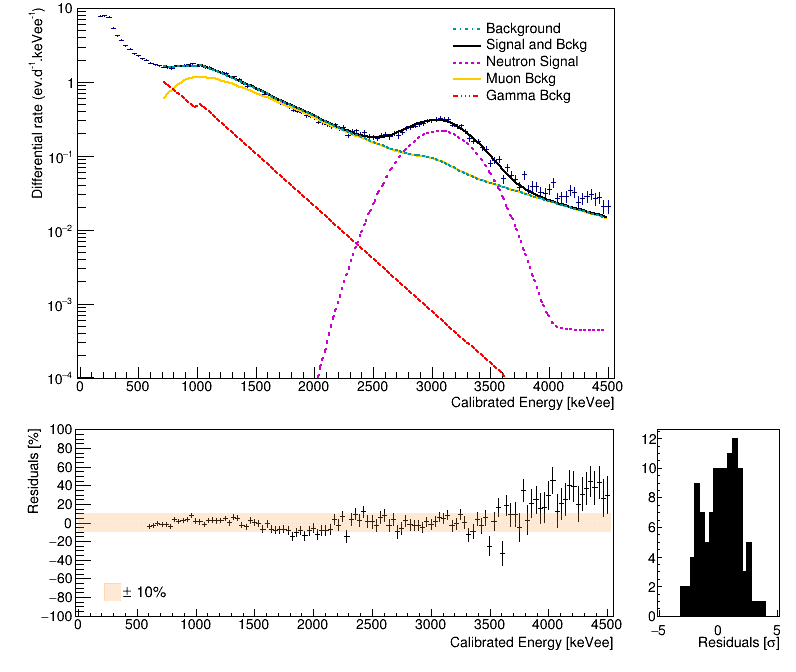

Info in <TCanvas::Print>: pdf file Figs/Finals/Fit_DC_9inch.pdf has been created


In [81]:
TCanvas* C = new TCanvas("cDC_9inch", "cDC_9inch", 800, 700);
C->Draw();
TPad *p0 = new TPad("p0","p0",0.02,0.375,0.795,1.);
p0->Draw();
p0->cd();
p0->SetLeftMargin(0.1);
p0->SetRightMargin(0.03);
p0->SetBottomMargin(0.1);
p0->SetTopMargin(0.02);

p0->SetLogy();
hCal_DC_9inch->Draw("");
hCal_DC_9inch->GetXaxis()->SetTitleOffset(1.1);
hCal_DC_9inch->GetYaxis()->SetTitleOffset(1.2);
hCal_DC_9inch->SetTitle(0);
SignalandBackground_9inch_DC->SetLineColor(kBlack);
hCal_DC_9inch->GetYaxis()->SetRangeUser(1e-4, 10);
Sum_background_9inch_DC->SetLineColor(kBlue);
Sum_background_9inch_DC->Draw("SAME");
Muon_background_9inch_DC->SetLineColor(kOrange);
Gamma_background_9inch->SetLineColor(kRed);
Muon_background_9inch_DC->Draw("SAME");
Gamma_background_9inch->Draw("SAME");
Gamma_background_9inch->SetLineStyle(6);
Sum_background_9inch_DC->Draw("SAME");
SignalandBackground_9inch_DC->Draw("SAME");
Neutron_signal_9inch->SetLineColor(kMagenta+1);
Neutron_signal_9inch->SetLineStyle(2);
Neutron_signal_9inch->Draw("SAME");
Sum_background_9inch_DC->SetLineStyle(4);
Sum_background_9inch_DC->SetLineColor(kCyan+2);
Sum_background_9inch_DC->Draw("SAME");

TLegend* leg0 = new TLegend(0.7, 0.75, 0.95, 0.95);
leg0->AddEntry(Sum_background_9inch_DC, "Background", "l");
leg0->AddEntry(SignalandBackground_9inch_DC, "Signal and Bckg", "l");
leg0->AddEntry(Neutron_signal_9inch, "Neutron Signal", "l");
leg0->AddEntry(Muon_background_9inch_DC, "Muon Bckg", "l");
leg0->AddEntry(Gamma_background_9inch, "Gamma Bckg","l");
leg0->Draw("SAME");
leg0->SetLineWidth(0);

//TCanvas* C2 = new TCanvas("cRes_DC_9inch", "cRes_DC_9inch", 1.175*C->GetWw(), 0.6*C->GetWh());
//C2->Draw();
C->cd();
TPad *p1 = new TPad("p1","p1",0.,0.01,0.795,0.375);
p1->Draw();
p1->cd();
p1->SetLeftMargin(0.12);
p1->SetRightMargin(0.03);
p1->SetBottomMargin(0.2);
p1->SetTopMargin(0.04);

histosRes_DC_9inch = Residuals_vec(hCal_DC_9inch, SignalandBackground_9inch_DC, 600, 6000, true);
hRes_DC_9inch=histosRes_DC_9inch[0];
hRes_DC_9inch->GetYaxis()->SetTitle("Residuals [%]");
hRes_DC_9inch->GetYaxis()->SetTitleOffset(0.65);
hRes_DC_9inch->GetYaxis()->SetTitleSize(1.8*hCal_DC_9inch->GetYaxis()->GetTitleSize());
hRes_DC_9inch->GetXaxis()->SetTitleSize(1.8*hCal_DC_9inch->GetXaxis()->GetTitleSize());
hRes_DC_9inch->GetYaxis()->SetLabelSize(1.8*hCal_DC_9inch->GetYaxis()->GetLabelSize());
hRes_DC_9inch->GetXaxis()->SetLabelSize(1.8*hCal_DC_9inch->GetXaxis()->GetLabelSize());
hRes_DC_9inch->Draw("");

h_10pc = (TH1D*) hRes_DC_9inch->Clone();
for (int i =1; i<=h_10pc->GetNbinsX(); i++){
    h_10pc->SetBinContent(i, 0);
    h_10pc->SetBinError(i, 10);
}
h_10pc->SetLineColorAlpha(kOrange+1, 0.2);
h_10pc->SetMarkerColorAlpha(kOrange+1, 0.2);
h_10pc->SetFillColorAlpha(kOrange+1, 0.2);
h_10pc->Draw("E3SAME");

TLegend* leg = new TLegend(0.16, 0.25, 0.3, 0.35);
leg->AddEntry(h_10pc, "#pm 10%", "f");
leg->Draw("SAME");
leg->SetLineWidth(0);


C->cd();
TPad *p2 = new TPad("p2","p2",0.795,0.01,1.,0.375);
p2->Draw();
p2->cd();
p2->SetLeftMargin(0.15);
p2->SetBottomMargin(0.2);
p2->SetTopMargin(0.04);

hRedRes_DC_9inch=histosRes_DC_9inch[1];
hRedRes_DC_9inch->Draw("");
hRedRes_DC_9inch->GetXaxis()->SetTitle("Residuals [#sigma]");
hRedRes_DC_9inch->GetYaxis()->SetTitleSize(3.*hCal_DC_9inch->GetYaxis()->GetTitleSize());
hRedRes_DC_9inch->GetXaxis()->SetTitleSize(2.7*hCal_DC_9inch->GetXaxis()->GetTitleSize());
hRedRes_DC_9inch->GetXaxis()->SetTitleOffset(0.7);
hRedRes_DC_9inch->GetYaxis()->SetLabelSize(2.7*hCal_DC_9inch->GetYaxis()->GetLabelSize());
hRedRes_DC_9inch->GetXaxis()->SetLabelSize(2.7*hCal_DC_9inch->GetXaxis()->GetLabelSize());
hRedRes_DC_9inch->GetXaxis()->SetNdivisions(5);

C->SaveAs("Figs/Finals/Fit_DC_9inch.pdf");

Good agreement in shape of the fit, but the muon peak seems to not be exactly at the same position as in the simulation... (quenching?, not good calibration?) 

### VNS
Fit of the data in the VNS. <br>
For the VNS, the width of the neutron peak is fixed.

In [82]:
SignalandBackground_9inch_VNS->SetParameter(3, 3000);
SignalandBackground_9inch_VNS->SetParLimits(3, 2800, 3500);
SignalandBackground_9inch_VNS->SetParameter(2, 1);

TFitResultPtr r_9_VNS = hCal_VNS_9inch->Fit(SignalandBackground_9inch_VNS, "SR0", "", Emin_fit, Emax_fit);
r_9_VNS = hCal_VNS_9inch->Fit(SignalandBackground_9inch_VNS, "SR0", "", Emin_fit, Emax_fit);

TMatrixD CovMat_VNS = r_9_VNS->GetCovarianceMatrix();

//CovMat_VNS.Print();

Double_t err_norm_NP_VNS = sqrt(CovMat_VNS(2,2));
Double_t norm_NP_VNS = SignalandBackground_9inch_VNS->GetParameter(2);

Double_t err_norm_Bkg_VNS = sqrt(CovMat_VNS(0,0)+CovMat_VNS(1,1)+2*CovMat_VNS(0,1));
Double_t norm_Bckg_VNS = SignalandBackground_9inch_VNS->GetParameter(0)+SignalandBackground_9inch_VNS->GetParameter(1);

Double_t Norm_mu_9_VNS = SignalandBackground_9inch_VNS->GetParameter(0);
Double_t err_Norm_mu_9_VNS = SignalandBackground_9inch_VNS->GetParError(0);

Sum_background_9inch_VNS->SetParameter(0, SignalandBackground_9inch_VNS->GetParameter(0));
Sum_background_9inch_VNS->SetParameter(1, SignalandBackground_9inch_VNS->GetParameter(1));

Muon_background_9inch_VNS->SetParameter(0, SignalandBackground_9inch_VNS->GetParameter(0));
Gamma_background_9inch->SetParameter(0, SignalandBackground_9inch_VNS->GetParameter(1));

Neutron_signal_9inch->SetParameter(0, SignalandBackground_9inch_VNS->GetParameter(2));
Neutron_signal_9inch->SetParameter(1, SignalandBackground_9inch_VNS->GetParameter(3));
Neutron_signal_9inch->SetParameter(2, SignalandBackground_9inch_VNS->GetParameter(4));


Double_t N_ev_tot_VNS = SignalandBackground_9inch_VNS->Integral(Emin, Emax);
Double_t N_ev_NP_VNS = Neutron_signal_9inch->Integral(Emin, Emax);
Double_t err_N_ev_NP_VNS = (err_norm_NP_VNS/norm_NP_VNS)*Neutron_signal_9inch->Integral(Emin, Emax);
Double_t N_ev_BKG_VNS = Sum_background_9inch_VNS->Integral(Emin, Emax);
Double_t err_N_ev_BKG_VNS = (err_norm_Bkg_VNS/norm_Bckg_VNS)*Sum_background_9inch_VNS->Integral(Emin, Emax);

Double_t err_N_ev_data_VNS;
Double_t N_ev_data_VNS = hCal_VNS_9inch->IntegralAndError(hCal_VNS_9inch->FindBin(Emin), hCal_VNS_9inch->FindBin(Emax), err_N_ev_data_VNS, "width");

Double_t err_N_ev_data_NP_VNS = sqrt(err_N_ev_data_VNS*err_N_ev_data_VNS + err_N_ev_BKG_VNS*err_N_ev_BKG_VNS);
Double_t N_ev_data_NP_VNS = N_ev_data_VNS-N_ev_BKG_VNS;

cout<<"\nChi2/ndf = "<<SignalandBackground_9inch_VNS->GetChisquare()<<"/"<<SignalandBackground_9inch_VNS->GetNDF()<<" = "<<SignalandBackground_9inch_VNS->GetChisquare()/SignalandBackground_9inch_VNS->GetNDF()<<endl;
cout<<"\nTotal N_ev in peak region = "<<N_ev_tot_VNS<<" ev/d +- "<<err_N_ev_data_VNS<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from fit = "<<N_ev_NP_VNS<<" ev/d +- "<<err_N_ev_NP_VNS<<" ev/d (error from normalization error only!)"<<endl;
cout<<"N_ev in background = "<<N_ev_BKG_VNS<<" ev/d +- "<<err_N_ev_BKG_VNS<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from data - bckg = "<<N_ev_data_NP_VNS<<" ev/d +- "<<err_N_ev_data_NP_VNS<<" ev/d"<<endl;

 FCN=170.268 FROM MIGRAD    STATUS=CONVERGED     152 CALLS         153 TOTAL
                     EDM=9.20828e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Norm_muons   7.97680e-02   8.84479e-04   3.90419e-06   1.56009e+00
   2  Norm_gammas   9.92156e-01   1.20802e-02   5.56362e-05   8.27246e-02
   3  Norm_Neutr   2.73881e-02   3.11649e-03   1.79884e-05   5.95326e-03
   4  Mean_gauss   3.04150e+03   3.59354e+01   6.70517e-04  -9.19080e-03
   5  Sigma_gauss   2.64129e+02     fixed    
 FCN=170.268 FROM MIGRAD    STATUS=CONVERGED      49 CALLS          50 TOTAL
                     EDM=7.74626e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Norm_muons   7.97678e-02   8.84479e-04   3.90419e-06 

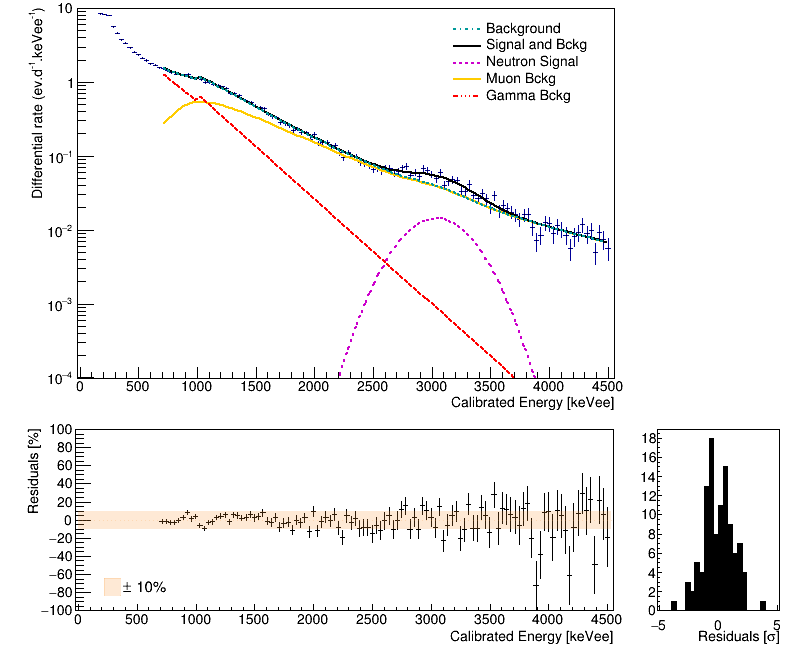

Warning in <TFile::Append>: Replacing existing TH1: Reduced_res_ (Potential memory leak).
Info in <TCanvas::Print>: pdf file Figs/Finals/Fit_VNS_9inch.pdf has been created


In [83]:
TCanvas* C = new TCanvas("cVNS_9inch", "cVNS_9inch", 800, 700);
C->Draw();
TPad *p0 = new TPad("p0","p0",0.02,0.375,0.795,1.);
p0->Draw();
p0->cd();
p0->SetLeftMargin(0.1);
p0->SetRightMargin(0.03);
p0->SetBottomMargin(0.1);
p0->SetTopMargin(0.02);

p0->SetLogy();
hCal_VNS_9inch->Draw("");
hCal_VNS_9inch->GetXaxis()->SetTitleOffset(1.1);
hCal_VNS_9inch->GetYaxis()->SetTitleOffset(1.2);
hCal_VNS_9inch->SetTitle(0);
hCal_VNS_9inch->GetYaxis()->SetRangeUser(1e-4, 10);
SignalandBackground_9inch_VNS->SetLineColor(kBlack);
Sum_background_9inch_VNS->SetLineColor(kBlue);
Sum_background_9inch_VNS->Draw("SAME");
Muon_background_9inch_VNS->SetLineColor(kOrange);
Gamma_background_9inch->SetLineColor(kRed);
Muon_background_9inch_VNS->Draw("SAME");
Gamma_background_9inch->Draw("SAME");
Gamma_background_9inch->SetLineStyle(6);
Sum_background_9inch_VNS->Draw("SAME");
SignalandBackground_9inch_VNS->Draw("SAME");
Neutron_signal_9inch->SetLineColor(kMagenta+1);
Neutron_signal_9inch->SetLineStyle(2);
Neutron_signal_9inch->Draw("SAME");
Sum_background_9inch_VNS->SetLineStyle(4);
Sum_background_9inch_VNS->SetLineColor(kCyan+2);
Sum_background_9inch_VNS->Draw("SAME");

TLegend* leg0 = new TLegend(0.7, 0.75, 0.95, 0.95);
leg0->AddEntry(Sum_background_9inch_VNS, "Background", "l");
leg0->AddEntry(SignalandBackground_9inch_VNS, "Signal and Bckg", "l");
leg0->AddEntry(Neutron_signal_9inch, "Neutron Signal", "l");
leg0->AddEntry(Muon_background_9inch_VNS, "Muon Bckg", "l");
leg0->AddEntry(Gamma_background_9inch, "Gamma Bckg", "l");
leg0->Draw("SAME");
leg0->SetLineWidth(0);

C->cd();
TPad *p1 = new TPad("p1","p1",0.,0.02,0.795,0.375);
p1->Draw();
p1->cd();
p1->SetLeftMargin(0.12);
p1->SetRightMargin(0.03);
p1->SetBottomMargin(0.2);
p1->SetTopMargin(0.04);

histosRes_VNS_9inch = Residuals_vec(hCal_VNS_9inch, SignalandBackground_9inch_VNS, Emin_fit, Emax_fit, true);
hRes_VNS_9inch=histosRes_VNS_9inch[0];
hRes_VNS_9inch->GetYaxis()->SetTitle("Residuals [%]");
hRes_VNS_9inch->GetYaxis()->SetTitleOffset(0.65);
hRes_VNS_9inch->GetYaxis()->SetTitleSize(1.8*hCal_VNS_9inch->GetYaxis()->GetTitleSize());
hRes_VNS_9inch->GetXaxis()->SetTitleSize(1.8*hCal_VNS_9inch->GetXaxis()->GetTitleSize());
hRes_VNS_9inch->GetYaxis()->SetLabelSize(1.8*hCal_VNS_9inch->GetYaxis()->GetLabelSize());
hRes_VNS_9inch->GetXaxis()->SetLabelSize(1.8*hCal_VNS_9inch->GetXaxis()->GetLabelSize());
hRes_VNS_9inch->Draw("");

h_10pc->Draw("E3SAME");

TLegend* leg = new TLegend(0.16, 0.25, 0.3, 0.35);
leg->AddEntry(h_10pc, "#pm 10%", "f");
leg->Draw("SAME");
leg->SetLineWidth(0);


C->cd();
TPad *p2 = new TPad("p2","p2",0.795,0.02,1.,0.375);
p2->Draw();
p2->cd();
p2->SetLeftMargin(0.15);
p2->SetBottomMargin(0.2);
p2->SetTopMargin(0.04);

hRedRes_VNS_9inch=histosRes_VNS_9inch[1];
hRedRes_VNS_9inch->Draw("");
hRedRes_VNS_9inch->GetXaxis()->SetTitle("Residuals [#sigma]");
hRedRes_VNS_9inch->GetYaxis()->SetTitleSize(3.*hCal_VNS_9inch->GetYaxis()->GetTitleSize());
hRedRes_VNS_9inch->GetXaxis()->SetTitleSize(2.7*hCal_VNS_9inch->GetXaxis()->GetTitleSize());
hRedRes_VNS_9inch->GetXaxis()->SetTitleOffset(0.7);
hRedRes_VNS_9inch->GetYaxis()->SetLabelSize(2.7*hCal_VNS_9inch->GetYaxis()->GetLabelSize());
hRedRes_VNS_9inch->GetXaxis()->SetLabelSize(2.7*hCal_VNS_9inch->GetXaxis()->GetLabelSize());
hRedRes_VNS_9inch->GetXaxis()->SetNdivisions(5);

C->SaveAs("Figs/Finals/Fit_VNS_9inch.pdf");

# Analysis of the 8 inches sphere

An analogous procedure is applied to the 8 inches sphere data

## Calibration

The neutron capture peak positions with the 8 inches and the 9 inches sphere was noticed to not be exactly the same. So another calibration factor is defined for the 8 inches data. 

In [84]:
TH1D* h_Cal_8inch = Put_data_in_histo("Measures@TUM/03-14_Cf252_LMU_BS-A-08_2h.dat", 2*24*3600., "8inch with Cf252 n source");
h_Cal_8inch->Rebin(4);
h_Cal_8inch->Scale(1/4.);


*******************************************************
Measures@TUM/03-14_Cf252_LMU_BS-A-08_2h.dat


h_Cal_8inch->Fit("Neutron_peak_MCA", "R");

Double_t Cal_factor_8inch = 3500./(Neutron_peak_Gaus_MCA->GetParameter(1)); //Neutron peak assumed to be at 3500keVee
Double_t err_Cal_factor_8inch = (Neutron_peak_Gaus_MCA->GetParError(1))/(Neutron_peak_Gaus_MCA->GetParameter(1))*Cal_factor_8inch; //Neutron peak assumed to be at 3500keVee

cout<<"\nCalibration for the 9inch sphere = "<<Cal_factor<<" +- "<< err_Cal_factor<<" keV/MCA"<<endl;
cout<<"Calibration for the 8inch sphere = "<<Cal_factor_8inch<<" +- "<< err_Cal_factor_8inch<<" keV/MCA"<<endl;

The calibration factors seems not so differents, but are still not compatible => Check if it is expected from simulation?

TCanvas* C8 = new TCanvas();
C8->Draw();
C8->SetLogy();
h_Cal_8inch->Draw();

## Simulation and background model

### Gammas Background

In [85]:
TH1D* h_SimuGamma_8inch = Put_simu_in_histo("Simulations/Env_Gammas/BS_D08/Analyzer_T_run01-06.root", "8 inches environmental gammas", nbins, hEmin, hEmax, 1.20e10, 3.3, QF_neutrons, MVthr_DC, true, Resol);

  Primary Entries:         1790299
  Secondary Entries:       1806637
  Generated primaries:  12000000000
  Equivalent time:      2272727 s (26.305 d)
 Nb of primary analysed: 1790299
 Nb of events quenched : 0


Gamma background with the two exponentials

In [86]:
TF1* Gamma_shape_8inch = new TF1("Gamma_shape_8inch", Gammas, 500, 4000, 4);
Gamma_shape_8inch->SetParNames("Norm_expo1", "Norm_expo2", "pos cdf", "sigma cdf");
Gamma_shape_8inch->SetParameter(2, 1200);
Gamma_shape_8inch->SetParLimits(2, 500, 1500);
Gamma_shape_8inch->SetParameter(3, 200);
Gamma_shape_8inch->SetParLimits(3, 50, 500);
h_SimuGamma_8inch->Fit("Gamma_shape_8inch", "", "", 500, 4000);

Gamma_shape_8inch->FixParameter(0, Gamma_shape_8inch->GetParameter(0));
Gamma_shape_8inch->FixParameter(1, Gamma_shape_8inch->GetParameter(1));
Gamma_shape_8inch->FixParameter(2, Gamma_shape_8inch->GetParameter(2));
Gamma_shape_8inch->FixParameter(3, Gamma_shape_8inch->GetParameter(3));

 FCN=111.347 FROM MIGRAD    STATUS=CONVERGED     462 CALLS         463 TOTAL
                     EDM=6.6517e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Norm_expo1   1.35485e+00   9.20892e-03   4.64873e-05  -7.07181e-02
   2  Norm_expo2   1.22157e+00   2.46276e-02   9.73441e-05  -2.76005e-02
   3  pos cdf      1.11942e+03   6.47716e+01   3.70240e-04   9.11506e-03
   4  sigma cdf    6.03616e+01   4.80557e+01   2.01982e-03  -2.46888e-04


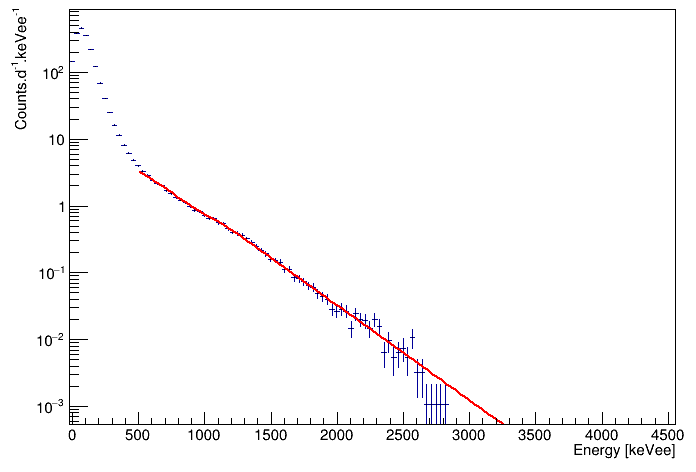

Info in <TCanvas::Print>: png file /Users/cg264002/research/Redaction_These/Figures/Chap3/Neutrons/Gammas_8inch.png has been created


In [87]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
gPad->SetLeftMargin(0.1);
gPad->SetRightMargin(0.03);
gPad->SetBottomMargin(0.1);
gPad->SetTopMargin(0.02);
h_SimuGamma_8inch->Draw();
h_SimuGamma_8inch->SetTitle("");
C->SaveAs("/Users/cg264002/research/Redaction_These/Figures/Chap3/Neutrons/Gammas_8inch.png");

### Muons background

In [88]:
TH1D* h_SimuMuons_8inch_DC = Put_simu_in_histo("Simulations/Atm_Muons/BS_D08/Analyzer_T_run01-12.root", "8 inches atmospheric muons DC", nbins, hEmin, hEmax, 8e7, 0.019, QF_neutrons, MVthr_DC, true, Resol);

  Primary Entries:          502660
  Secondary Entries:        567025
  Generated primaries:  80000000
  Equivalent time:      2631579 s (30.458 d)
 Nb of primary analysed: 502660
 Nb of events quenched : 13


In [89]:
TH1D* h_SimuMuons_8inch_VNS = Put_simu_in_histo("Simulations/Atm_Muons/BS_D08/Analyzer_T_run01-12.root", "8 inches atmospheric muons VNS",nbins, hEmin, hEmax, 8e7, 0.019, QF_neutrons, MVthr_VNS, true, Resol);

  Primary Entries:          502660
  Secondary Entries:        567025
  Generated primaries:  80000000
  Equivalent time:      2631579 s (30.458 d)
 Nb of primary analysed: 502660
 Nb of events quenched : 13


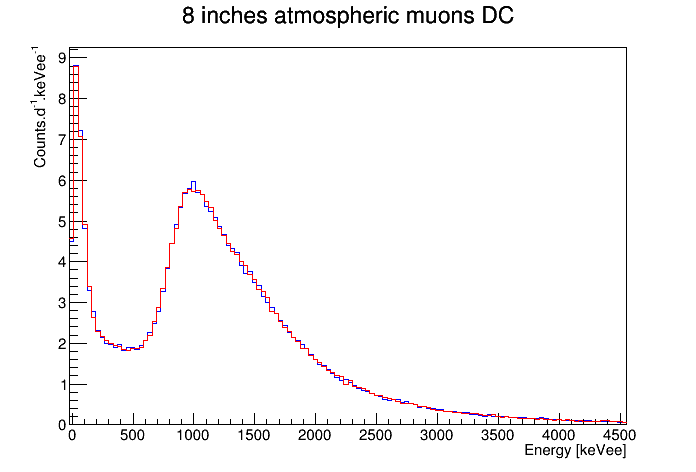

In [90]:
TCanvas *C = new TCanvas();
C->Draw();
h_SimuMuons_8inch_DC->SetLineColor(kBlue);
h_SimuMuons_8inch_VNS->SetLineColor(kRed);
h_SimuMuons_8inch_DC->Draw("HIST");
h_SimuMuons_8inch_VNS->Draw("HIST SAME");

Muon Background: 1- Muons Peak

In [91]:
TF1* Muon_peak_8inch_DC = new TF1("Muon_peak_8inch_DC", "landau", 800, 2000); //Landau in muon peak region
Muon_peak_8inch_DC->SetParNames("Amplitude_mu []", "MPV [keVee]", "[Sigma [keVee]]");
Muon_peak_8inch_DC->SetParameters(1,1200,100);
h_SimuMuons_8inch_DC->Fit("Muon_peak_8inch_DC", "R");

Muon_peak_8inch_DC->FixParameter(0,Muon_peak_8inch_DC->GetParameter(0));
Muon_peak_8inch_DC->FixParameter(1,Muon_peak_8inch_DC->GetParameter(1));
Muon_peak_8inch_DC->FixParameter(2,Muon_peak_8inch_DC->GetParameter(2));

 FCN=112.85 FROM MIGRAD    STATUS=CONVERGED     126 CALLS         127 TOTAL
                     EDM=8.65043e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Amplitude_mu []   3.12663e+01   1.24031e-01   4.32663e-04   3.45875e-03
   2  MPV [keVee]   1.06174e+03   2.67274e+00   1.11583e-02   1.34930e-04
   3  [Sigma [keVee]]   2.35366e+02   1.81071e+00   6.95053e-06   7.92292e-02


In [92]:
TF1* Muon_peak_8inch_VNS = new TF1("Muon_peak_8inch_VNS", "landau", 800, 2000); //Landau in muon peak region
Muon_peak_8inch_VNS->SetParNames("Amplitude_mu []", "MPV [keVee]", "[Sigma [keVee]]");
Muon_peak_8inch_VNS->SetParameters(1,1200,100);
h_SimuMuons_8inch_VNS->Fit("Muon_peak_8inch_VNS", "R");

Muon_peak_8inch_VNS->FixParameter(0,Muon_peak_8inch_VNS->GetParameter(0));
Muon_peak_8inch_VNS->FixParameter(1,Muon_peak_8inch_VNS->GetParameter(1));
Muon_peak_8inch_VNS->FixParameter(2,Muon_peak_8inch_VNS->GetParameter(2));

 FCN=113.001 FROM MIGRAD    STATUS=CONVERGED     134 CALLS         135 TOTAL
                     EDM=3.77068e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Amplitude_mu []   3.12549e+01   1.23814e-01   4.33002e-04  -1.18962e-06
   2  MPV [keVee]   1.06350e+03   2.62567e+00   1.10861e-02  -6.41395e-07
   3  [Sigma [keVee]]   2.34433e+02   1.78243e+00   6.91558e-06  -1.42551e-03


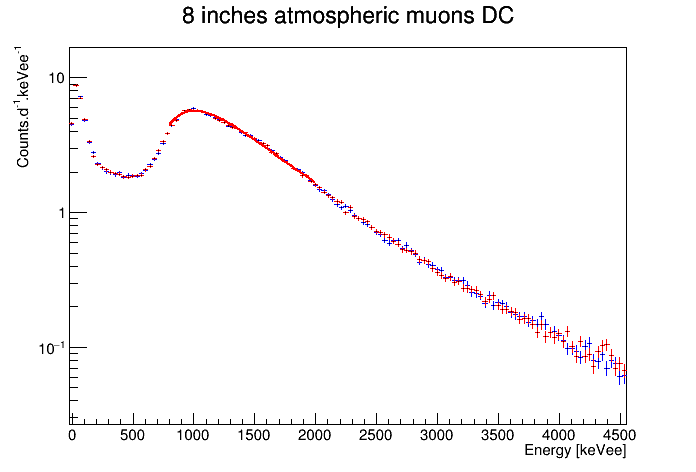

In [93]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
h_SimuMuons_8inch_DC->Draw();
h_SimuMuons_8inch_VNS->Draw("Same");

2- Muon Plateau

In [94]:
TF1* Muon_plateau_8inch_DC = new TF1("Muon_plateau_8inch_DC", "expo+pol2(2)", 300,800); 
Muon_plateau_8inch_DC->SetParNames("a", "b", "c", "d", "e");
h_SimuMuons_8inch_DC->Fit("Muon_plateau_8inch_DC", "R");

 FCN=70.9198 FROM HESSE     STATUS=NOT POSDEF     31 CALLS        1021 TOTAL
                     EDM=1.70926e-07    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  a            1.19810e+00   3.87488e-02   2.99626e-06   7.04658e-02
   2  b           -8.65382e-06   8.14399e-05   5.50761e-09   1.67240e+01
   3  c            2.03784e+00   1.28131e-01   9.88488e-06   2.13085e-02
   4  d           -1.56266e-02   2.68457e-04   1.81598e-08   5.15745e+00
   5  e            1.71189e-05   2.81850e-07   2.98911e-11   3.63800e+02


In [95]:
TF1* Muon_plateau_8inch_VNS = new TF1("Muon_plateau_8inch_VNS", "expo+pol2(2)", 300,900); 
Muon_plateau_8inch_VNS->SetParNames("a", "b", "c", "d", "e");
h_SimuMuons_8inch_VNS->Fit("Muon_plateau_8inch_VNS", "R");

 FCN=71.8379 FROM HESSE     STATUS=NOT POSDEF     31 CALLS         868 TOTAL
                     EDM=9.93978e-07    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  a            9.42932e-01   4.77430e-02   3.73038e-06   2.68578e-01
   2  b           -1.13750e-05   9.37044e-05   6.47112e-09   1.74777e+02
   3  c            3.50192e+00   1.22240e-01   9.49966e-06   1.05386e-01
   4  d           -1.86579e-02   2.38949e-04   1.64566e-08   6.88473e+01
   5  e            2.01289e-05   2.23006e-07   2.49004e-11   4.72109e+04


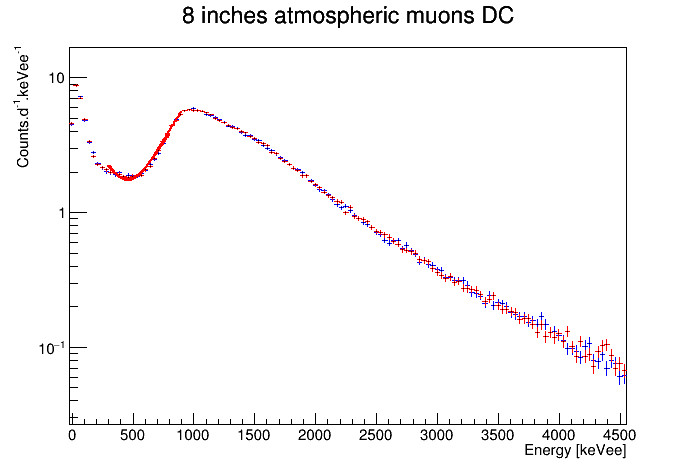

In [96]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
h_SimuMuons_8inch_DC->Draw();
h_SimuMuons_8inch_VNS->Draw("Same");

3- Muon queue

In [97]:
TF1* Muon_queue_8inch_DC_start = new TF1("Muon_queue_8inch_DC_start", "expo(0)", 1800, 4000); 
Muon_queue_8inch_DC_start->SetParameter(0, -10);
Muon_queue_8inch_DC_start->SetParameter(1, -0.003);
h_SimuMuons_8inch_DC->Fit("Muon_queue_8inch_DC_start", "R");

TF1* Muon_queue_8inch_DC_end = new TF1("Muon_queue_8inch_end_DC", "expo(0)", 4000, 5500); 
Muon_queue_8inch_DC_end->SetParameter(0, -10);
Muon_queue_8inch_DC_end->SetParameter(1, -0.003);
h_SimuMuons_8inch_DC->Fit("Muon_queue_8inch_end_DC", "R");

TF1* Muon_queue_8inch_DC = new TF1("Muon_queue_8inch_DC", "expo(0)+expo(2)", 1800, 5500); 
//Muon_queue_9inch->SetParNames("Norm", "slope", "Norm_NP", "mean_NP", "sigma_NP");
Muon_queue_8inch_DC->SetParameter(0, Muon_queue_8inch_DC_start->GetParameter(0));
Muon_queue_8inch_DC->SetParameter(1, Muon_queue_8inch_DC_start->GetParameter(1));
Muon_queue_8inch_DC->SetParameter(2, Muon_queue_8inch_DC_end->GetParameter(0));
Muon_queue_8inch_DC->SetParameter(3, Muon_queue_8inch_DC_end->GetParameter(1));

h_SimuMuons_8inch_DC->Fit("Muon_queue_8inch_DC", "R");

Muon_queue_8inch_DC->FixParameter(0, Muon_queue_8inch_DC->GetParameter(0));
Muon_queue_8inch_DC->FixParameter(1, Muon_queue_8inch_DC->GetParameter(1));
Muon_queue_8inch_DC->FixParameter(2, Muon_queue_8inch_DC->GetParameter(2));
Muon_queue_8inch_DC->FixParameter(3, Muon_queue_8inch_DC->GetParameter(3));

 FCN=215.844 FROM MIGRAD    STATUS=CONVERGED      52 CALLS          53 TOTAL
                     EDM=9.27688e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.22333e+00   2.45940e-02   3.46473e-05   6.20815e-02
   2  Slope       -1.38881e-03   9.98965e-06   1.40731e-08   1.80901e+02
 FCN=11.9736 FROM MIGRAD    STATUS=CONVERGED      55 CALLS          56 TOTAL
                     EDM=3.45653e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.82594e+00   8.20671e-01   4.71395e-05   3.04804e-04
   2  Slope       -1.00375e-03   1.92533e-04   1.10592e-08   1.16873e+00
 FCN=67.9034 FROM MIGRAD    STATUS=CONVERGED     422 CALLS         423 TOTAL
                     EDM=1.14

In [98]:
TF1* Muon_queue_8inch_VNS_start = new TF1("Muon_queue_8inch_VNS_start", "expo(0)", 1800, 4000); 
Muon_queue_8inch_VNS_start->SetParameter(0, -10);
Muon_queue_8inch_VNS_start->SetParameter(1, -0.003);
h_SimuMuons_8inch_VNS->Fit("Muon_queue_8inch_VNS_start", "R");

TF1* Muon_queue_8inch_VNS_end = new TF1("Muon_queue_8inch_end_VNS", "expo(0)", 4000, 5500); 
Muon_queue_8inch_VNS_end->SetParameter(0, -10);
Muon_queue_8inch_VNS_end->SetParameter(1, -0.003);
h_SimuMuons_8inch_VNS->Fit("Muon_queue_8inch_end_VNS", "R");

TF1* Muon_queue_8inch_VNS = new TF1("Muon_queue_8inch_VNS", "expo(0)+expo(2)", 1800, 5500); 
//Muon_queue_9inch->SetParNames("Norm", "slope", "Norm_NP", "mean_NP", "sigma_NP");
Muon_queue_8inch_VNS->SetParameter(0, Muon_queue_8inch_VNS_start->GetParameter(0));
Muon_queue_8inch_VNS->SetParameter(1, Muon_queue_8inch_VNS_start->GetParameter(1));
Muon_queue_8inch_VNS->SetParameter(2, Muon_queue_8inch_VNS_end->GetParameter(0));
Muon_queue_8inch_VNS->SetParameter(3, Muon_queue_8inch_VNS_end->GetParameter(1));

h_SimuMuons_8inch_VNS->Fit("Muon_queue_8inch_VNS", "R");

Muon_queue_8inch_VNS->FixParameter(0, Muon_queue_8inch_VNS->GetParameter(0));
Muon_queue_8inch_VNS->FixParameter(1, Muon_queue_8inch_VNS->GetParameter(1));
Muon_queue_8inch_VNS->FixParameter(2, Muon_queue_8inch_VNS->GetParameter(2));
Muon_queue_8inch_VNS->FixParameter(3, Muon_queue_8inch_VNS->GetParameter(3));

 FCN=144.044 FROM MIGRAD    STATUS=CONVERGED      53 CALLS          54 TOTAL
                     EDM=6.23857e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.25325e+00   2.42441e-02   2.83214e-05  -2.29005e-01
   2  Slope       -1.40085e-03   9.85538e-06   1.15129e-08  -5.34261e+02
 FCN=26.8786 FROM MIGRAD    STATUS=CONVERGED      53 CALLS          54 TOTAL
                     EDM=4.87773e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.16440e+00   8.74962e-01   6.69442e-05   5.04648e-03
   2  Slope       -8.33801e-04   2.05084e-04   1.56910e-08   2.01382e+01
 FCN=73.1438 FROM HESSE     STATUS=OK             23 CALLS         289 TOTAL
                     EDM=7.43

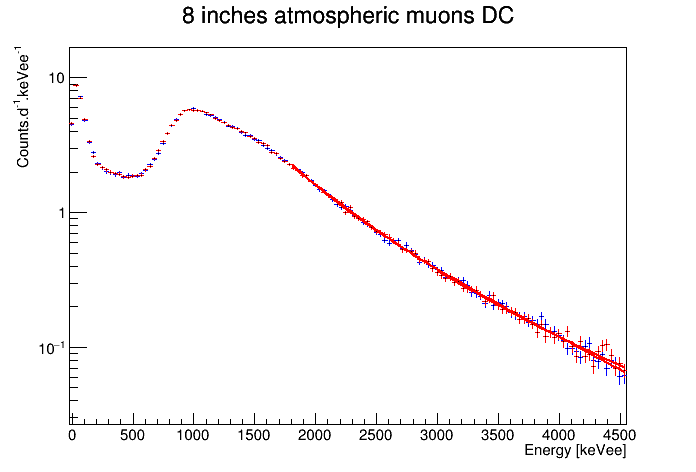

In [99]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
h_SimuMuons_8inch_DC->Draw("");
Muon_queue_8inch_DC_end->SetLineColor(kBlue);
//Muon_queue_8inch_DC_end->Draw("SAME");
Muon_queue_8inch_DC_start->SetLineColor(kBlue);
//Muon_queue_8inch_DC_start->Draw("SAME");
Muon_queue_8inch_DC->Draw("SAME");
h_SimuMuons_8inch_VNS->Draw("Same");
Muon_queue_8inch_VNS_end->SetLineColor(kBlue);
//Muon_queue_8inch_VNS_end->Draw("SAME");
Muon_queue_8inch_VNS_start->SetLineColor(kBlue);
//Muon_queue_8inch_VNS_start->Draw("SAME");
Muon_queue_8inch_VNS->Draw("SAME");

Total muon function

In [100]:
Double_t Muons_8inch_DC(Double_t* x, Double_t *par){
    Double_t par_cdf[2]= {par[3], par[4]};
    Double_t par_cdf2[2]= {par[5], par[6]};
    return (1-cdf(x, par_cdf))*par[0]*Muon_plateau_8inch_DC->Eval(x[0])+cdf(x, par_cdf)*(1-cdf(x, par_cdf2))*par[1]*Muon_peak_8inch_DC->Eval(x[0])+cdf(x, par_cdf2)*par[2]*Muon_queue_8inch_DC->Eval(x[0]);
}

In [101]:
Double_t Muons_8inch_VNS(Double_t* x, Double_t *par){
    Double_t par_cdf[2]= {par[3], par[4]};
    Double_t par_cdf2[2]= {par[5], par[6]};
    return (1-cdf(x, par_cdf))*par[0]*Muon_plateau_8inch_VNS->Eval(x[0])+cdf(x, par_cdf)*(1-cdf(x, par_cdf2))*par[1]*Muon_peak_8inch_VNS->Eval(x[0])+cdf(x, par_cdf2)*par[2]*Muon_queue_8inch_VNS->Eval(x[0]);
}

In [102]:
TF1* Muon_shape_8inch_DC = new TF1("Muon_shape_8inch_DC", Muons_8inch_DC, 200, 5500, 7);
Muon_shape_8inch_DC->SetParNames("Norm_plateau", "Norm_muonpeak", "Norm_muonplateau","pos cdf", "sigma cdf", "pos cdf2", "sigma cdf2");
Muon_shape_8inch_DC->SetParameter(0, 1);
Muon_shape_8inch_DC->SetParameter(1, 1);
Muon_shape_8inch_DC->SetParameter(2, 1);
Muon_shape_8inch_DC->SetParameter(3, 900);
Muon_shape_8inch_DC->SetParameter(4, 100);
Muon_shape_8inch_DC->SetParameter(5, 3250);
Muon_shape_8inch_DC->SetParameter(6, 100);
Muon_shape_8inch_DC->SetParLimits(3, 800, 1200);
Muon_shape_8inch_DC->SetParLimits(5, 3200, 3400);
h_SimuMuons_8inch_DC->Fit("Muon_shape_8inch_DC", "R");

 FCN=439.613 FROM MIGRAD    STATUS=CONVERGED     352 CALLS         353 TOTAL
                     EDM=3.31902e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Norm_plateau   8.16271e-01   1.55449e-02   1.41195e-06   2.91258e-02
   2  Norm_muonpeak   1.01363e+00   3.97531e-03  -2.11836e-06   6.01344e-03
   3  Norm_muonplateau   5.52485e-01   1.78254e-02   1.68507e-05   9.11114e-03
   4  pos cdf      8.00000e+02   7.39574e-01   3.23069e-05** at limit **
   5  sigma cdf    8.63646e+01   9.31932e+00  -3.43649e-03   1.46908e-05
   6  pos cdf2     3.20000e+03   9.24420e+00   1.03673e-05** at limit **
   7  sigma cdf2   1.17162e+03   2.07123e+01  -1.19035e-02   1.84828e-05


In [103]:
TF1* Muon_shape_8inch_VNS = new TF1("Muon_shape_8inch_VNS", Muons_8inch_VNS, 200, 5500, 7);
Muon_shape_8inch_VNS->SetParNames("Norm_plateau", "Norm_muonpeak", "Norm_muonplateau","pos cdf", "sigma cdf", "pos cdf2", "sigma cdf2");
Muon_shape_8inch_VNS->SetParameter(0, 1);
Muon_shape_8inch_VNS->SetParameter(1, 1);
Muon_shape_8inch_VNS->SetParameter(2, 1);
Muon_shape_8inch_VNS->SetParameter(3, 900);
Muon_shape_8inch_VNS->SetParameter(4, 100);
Muon_shape_8inch_VNS->SetParameter(5, 3250);
Muon_shape_8inch_VNS->SetParameter(6, 100);
Muon_shape_8inch_VNS->SetParLimits(3, 800, 1200);
Muon_shape_8inch_VNS->SetParLimits(5, 3200, 3400);
h_SimuMuons_8inch_VNS->Fit("Muon_shape_8inch_VNS", "R");

 FCN=497.282 FROM MIGRAD    STATUS=CONVERGED     335 CALLS         336 TOTAL
                     EDM=1.8611e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.0 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Norm_plateau   7.67308e-01   1.78511e-02  -1.98708e-06  -2.48760e-02
   2  Norm_muonpeak   1.04237e+00   5.87313e-03  -3.66445e-06   3.07279e-03
   3  Norm_muonplateau   5.30247e-01   1.92729e-02   2.10333e-06  -1.55232e-02
   4  pos cdf      8.00000e+02   1.03990e+00  -2.28906e-05** at limit **
   5  sigma cdf    1.07654e+02   9.18298e+00  -8.50296e-03   8.68131e-07
   6  pos cdf2     3.20000e+03   4.58459e+00  -3.36344e-04** at limit **
   7  sigma cdf2   1.43889e+03   3.58939e+01  -4.66906e-03  -1.55065e-05


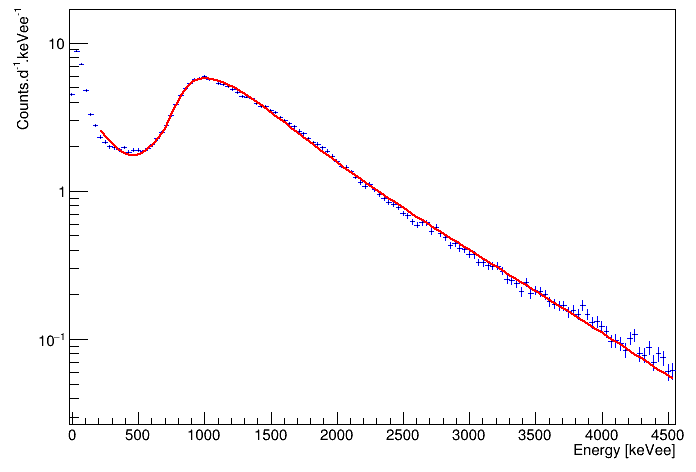

Info in <TCanvas::Print>: png file /Users/cg264002/research/Redaction_These/Figures/Chap3/Neutrons/Muons_8inch.png has been created


In [104]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
gPad->SetLeftMargin(0.1);
gPad->SetRightMargin(0.03);
gPad->SetBottomMargin(0.1);
gPad->SetTopMargin(0.02);

h_SimuMuons_8inch_DC->Draw();
h_SimuMuons_8inch_DC->SetTitle("");
//h_SimuMuons_8inch_VNS->Draw("Same");
C->SaveAs("/Users/cg264002/research/Redaction_These/Figures/Chap3/Neutrons/Muons_8inch.png");

In [105]:
Muon_shape_8inch_DC->FixParameter(0, 1);
Muon_shape_8inch_DC->FixParameter(0, Muon_shape_8inch_DC->GetParameter(0));
Muon_shape_8inch_DC->FixParameter(1, Muon_shape_8inch_DC->GetParameter(1));
Muon_shape_8inch_DC->FixParameter(2, Muon_shape_8inch_DC->GetParameter(2));
Muon_shape_8inch_DC->FixParameter(3, Muon_shape_8inch_DC->GetParameter(3));

Muon_shape_8inch_VNS->FixParameter(0, 1);
Muon_shape_8inch_VNS->FixParameter(0, Muon_shape_8inch_VNS->GetParameter(0));
Muon_shape_8inch_VNS->FixParameter(1, Muon_shape_8inch_VNS->GetParameter(1));
Muon_shape_8inch_VNS->FixParameter(2, Muon_shape_8inch_VNS->GetParameter(2));
Muon_shape_8inch_VNS->FixParameter(3, Muon_shape_8inch_VNS->GetParameter(3));

### Model background and signal

Background: Gammas + Muons with parameters their respective weights. <br>
Signal: Gammas + Muons + Gaussian

In [106]:
Double_t MuonsplusGammas_8inch_DC(Double_t* x, Double_t *par){
    return par[0]*Muon_shape_8inch_DC->Eval(x[0])+par[1]*Gamma_shape_8inch->Eval(x[0]);
}

In [107]:
Double_t MuonsplusGammas_8inch_VNS(Double_t* x, Double_t *par){
    return par[0]*Muon_shape_8inch_VNS->Eval(x[0])+par[1]*Gamma_shape_8inch->Eval(x[0]);
}

In [108]:
Double_t Muons_8inch_DC(Double_t* x, Double_t *par){
    return par[0]*Muon_shape_8inch_DC->Eval(x[0]);
}

In [109]:
Double_t Muons_8inch_VNS(Double_t* x, Double_t *par){
    return par[0]*Muon_shape_8inch_VNS->Eval(x[0]);
}

In [110]:
Double_t Gammas_8inch(Double_t* x, Double_t *par){
    return par[0]*Gamma_shape_8inch->Eval(x[0]);
}

In [111]:
Double_t SignalPlusBackground_8inch_DC(Double_t* x, Double_t *par){
    return par[0]*Muon_shape_8inch_DC->Eval(x[0])+par[1]*Gamma_shape_8inch->Eval(x[0])+par[2]*TMath::Gaus(x[0], par[3], par[4]);
}

In [112]:
Double_t SignalPlusBackground_8inch_VNS(Double_t* x, Double_t *par){
    return par[0]*Muon_shape_8inch_VNS->Eval(x[0])+par[1]*Gamma_shape_8inch->Eval(x[0])+par[2]*TMath::Gaus(x[0], par[3], par[4]);
}

In [113]:
Double_t Neutrons_8inch(Double_t* x, Double_t *par){
    Neutron_peak_Gaus->SetParameter(0, par[0]);
    Neutron_peak_Gaus->SetParameter(1, par[1]);
    Neutron_peak_Gaus->SetParameter(2, par[2]);
    return Neutron_peak_Gaus->Eval(x[0]);
}

In [114]:
TF1* Sum_background_8inch_DC = new TF1("Sum_background_8inch_DC", MuonsplusGammas_8inch_DC, Emin_fit, Emax_fit, 2);
Sum_background_8inch_DC->SetParNames("Norm_muons", "Norm_gammas");

TF1* Sum_background_8inch_VNS = new TF1("Sum_background_8inch_VNS", MuonsplusGammas_8inch_VNS, Emin_fit, Emax_fit, 2);
Sum_background_8inch_VNS->SetParNames("Norm_muons", "Norm_gammas");

In [115]:
TF1* Muon_background_8inch_DC = new TF1("Muon_background_8inch_DC", Muons_8inch_DC, Emin_fit, Emax_fit, 1);
Muon_background_8inch_DC->SetParNames("Norm_muons");

TF1* Muon_background_8inch_VNS = new TF1("Muon_background_8inch_VNS", Muons_8inch_VNS, Emin_fit, Emax_fit, 1);
Muon_background_8inch_VNS->SetParNames("Norm_muons");

In [116]:
TF1* Gamma_background_8inch = new TF1("Gamma_background_8inch", Gammas_8inch, Emin_fit, Emax_fit, 1);
Gamma_background_8inch->SetParNames("Norm_gammas");

In [117]:
TF1* SignalandBackground_8inch_DC = new TF1("SignalandBackground_8inch_DC", SignalPlusBackground_8inch_DC, Emin_fit, Emax_fit, 5);
SignalandBackground_8inch_DC->SetParNames("Norm_muons", "Norm_gammas", "Norm_Neutr", "Mean_gauss", "Sigma_gauss");

TF1* SignalandBackground_8inch_VNS = new TF1("SignalandBackground_8inch_VNS", SignalPlusBackground_8inch_VNS, Emin_fit, Emax_fit, 5);
SignalandBackground_8inch_VNS->SetParNames("Norm_muons", "Norm_gammas", "Norm_Neutr", "Mean_gauss", "Sigma_gauss");

In [118]:
TF1* Neutrons_8inch_DC = new TF1("Neutrons_8inch_DC", Neutrons_8inch, Emin_fit, Emax_fit, 3);
Neutrons_8inch_DC->SetParNames("Norm_Neutr", "Mean_gauss", "Sigma_gauss");

TF1* Neutrons_8inch_VNS = new TF1("Neutrons_8inch_VNS", Neutrons_8inch, Emin_fit, Emax_fit, 3);
Neutrons_8inch_VNS->SetParNames("Norm_Neutr", "Mean_gauss", "Sigma_gauss");

## Fit

### DCHut

In [119]:
TH1D* h_DC_8inch = Put_data_in_histo("Measures@DCHut/2022-09-14_BS-A-06_RT_1733984.75_LV_1733461.01.dat", 1733984, "8inch at DChut");
h_DC_8inch->Rebin(4);
h_DC_8inch->Scale(1/4.);


*******************************************************
Measures@DCHut/2022-09-14_BS-A-06_RT_1733984.75_LV_1733461.01.dat


In [120]:
TH1D* hCal_DC_8inch = Calibrate_histo(h_DC_8inch, Gain, Form("%s_keVee", h_DC_8inch->GetTitle()), Offset);

In [121]:
SignalandBackground_8inch_DC->SetParameter(3, 3000);
SignalandBackground_8inch_DC->SetParLimits(3, 2800, 3500);
SignalandBackground_8inch_DC->SetParameter(2, 1);
SignalandBackground_8inch_DC->SetParameter(4, Resol_NP);

TFitResultPtr r_8_DC = hCal_DC_8inch->Fit(SignalandBackground_8inch_DC, "SR0", "", Emin_fit, Emax_fit);

TMatrixD CovMat_8_DC = r_8_DC->GetCovarianceMatrix();

//CovMat_8_DC.Print();

Double_t err_norm_NP_8_DC = sqrt(CovMat_8_DC(2,2));
Double_t norm_NP_8_DC = SignalandBackground_8inch_DC->GetParameter(2);

Double_t err_norm_Bkg_8_DC = sqrt(CovMat_8_DC(0,0)+CovMat_8_DC(1,1)+2*CovMat_8_DC(0,1));
Double_t norm_Bckg_8_DC = SignalandBackground_8inch_DC->GetParameter(0)+SignalandBackground_8inch_DC->GetParameter(1);

Double_t Norm_mu_8_DC = SignalandBackground_8inch_DC->GetParameter(0);
Double_t err_Norm_mu_8_DC = SignalandBackground_8inch_DC->GetParError(0);

Sum_background_8inch_DC->SetParameter(0, SignalandBackground_8inch_DC->GetParameter(0));
Sum_background_8inch_DC->SetParameter(1, SignalandBackground_8inch_DC->GetParameter(1));

Muon_background_8inch_DC->SetParameter(0, SignalandBackground_8inch_DC->GetParameter(0));
Gamma_background_8inch->SetParameter(0, SignalandBackground_8inch_DC->GetParameter(1));

Neutrons_8inch_DC->SetParameter(0, SignalandBackground_8inch_DC->GetParameter(2));
Neutrons_8inch_DC->SetParameter(1, SignalandBackground_8inch_DC->GetParameter(3));
Neutrons_8inch_DC->SetParameter(2, SignalandBackground_8inch_DC->GetParameter(4));

Double_t N_ev_tot_8_DC = SignalandBackground_8inch_DC->Integral(Emin, Emax);
Double_t N_ev_NP_8_DC = Neutrons_8inch_DC->Integral(Emin, Emax);
Double_t err_N_ev_NP_8_DC = (err_norm_NP_8_DC/norm_NP_8_DC)*Neutrons_8inch_DC->Integral(Emin, Emax);
Double_t N_ev_BKG_8_DC = Sum_background_8inch_DC->Integral(Emin, Emax);
Double_t err_N_ev_BKG_8_DC = (err_norm_Bkg_8_DC/norm_Bckg_8_DC)*Sum_background_8inch_DC->Integral(Emin, Emax);

Double_t err_N_ev_data_8_DC;
Double_t N_ev_data_8_DC = hCal_DC_8inch->IntegralAndError(hCal_DC_8inch->FindBin(Emin), hCal_DC_8inch->FindBin(Emax), err_N_ev_data_8_DC, "width");

Double_t err_N_ev_data_NP_8_DC = sqrt(err_N_ev_data_8_DC*err_N_ev_data_8_DC + err_N_ev_BKG_8_DC*err_N_ev_BKG_8_DC);
Double_t N_ev_data_NP_8_DC = N_ev_data_8_DC-N_ev_BKG_8_DC;

cout<<"\nChi2/ndf = "<<SignalandBackground_8inch_DC->GetChisquare()<<"/"<<SignalandBackground_8inch_DC->GetNDF()<<" = "<<SignalandBackground_8inch_DC->GetChisquare()/SignalandBackground_8inch_DC->GetNDF()<<endl;
cout<<"\nTotal N_ev in peak region = "<<N_ev_data_8_DC<<" ev/d +- "<<err_N_ev_data_8_DC<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from fit = "<<N_ev_NP_8_DC<<" ev/d +- "<<err_N_ev_NP_8_DC<<" ev/d (error from normalization error only!)"<<endl;
cout<<"N_ev in background = "<<N_ev_BKG_8_DC<<" ev/d +- "<<err_N_ev_BKG_8_DC<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from data - bckg = "<<N_ev_data_NP_8_DC<<" ev/d +- "<<err_N_ev_data_NP_8_DC<<" ev/d"<<endl;

SignalandBackground_8inch_VNS->FixParameter(4, SignalandBackground_8inch_DC->GetParameter(4)); //Fix the sigma value of the neutron peak

 FCN=232.027 FROM MIGRAD    STATUS=CONVERGED     175 CALLS         176 TOTAL
                     EDM=2.67033e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.5 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Norm_muons   2.03989e-01   2.21948e-03  -2.90186e-06  -3.82126e-02
   2  Norm_gammas   8.82925e-01   1.80623e-02   1.92748e-05  -1.11443e-02
   3  Norm_Neutr   1.71571e-01   6.52919e-03  -1.18266e-05   4.14633e-03
   4  Mean_gauss   3.07734e+03   8.26449e+00  -2.78887e-05  -1.02077e-02
   5  Sigma_gauss   2.23200e+02   8.14142e+00   7.82264e-03   1.24941e-05

Chi2/ndf = 232.027/102 = 2.27478

Total N_ev in peak region = 205.488 ev/d +- 3.19984 ev/d
N_ev in neutron peak from fit = 95.5141 ev/d +- 3.63483 ev/d (error from normalization error only!)
N_ev in background = 102.675 ev/d +- 1.56569 ev/d
N_ev in neutron peak from data - bckg = 102.813 ev/d +- 3.56235 ev/d


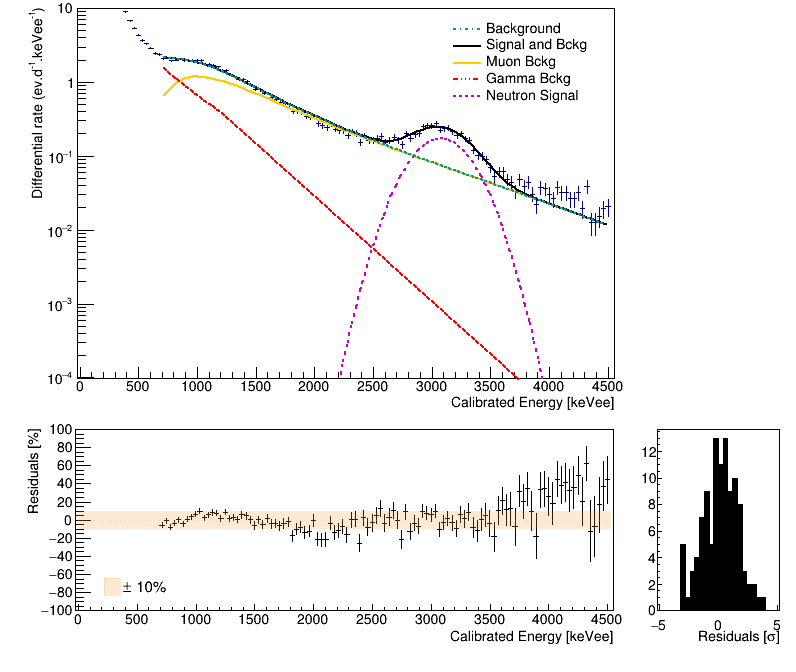

Info in <TCanvas::Print>: pdf file Figs/Finals/Fit_DC_8inch.pdf has been created


In [122]:
TCanvas* C = new TCanvas("cDC_8inch", "cDC_8inch", 800, 700);
C->Draw();
TPad *p0 = new TPad("p0","p0",0.02,0.375,0.795,1.);
p0->Draw();
p0->cd();
p0->SetLeftMargin(0.1);
p0->SetRightMargin(0.03);
p0->SetBottomMargin(0.1);
p0->SetTopMargin(0.02);

p0->SetLogy();
hCal_DC_8inch->Draw("");
hCal_DC_8inch->GetXaxis()->SetTitleOffset(1.1);
hCal_DC_8inch->GetYaxis()->SetTitleOffset(1.2);
hCal_DC_8inch->SetTitle(0);
hCal_DC_8inch->GetYaxis()->SetRangeUser(1e-4, 10);
SignalandBackground_8inch_DC->SetLineColor(kBlack);
Sum_background_8inch_DC->SetLineColor(kBlue);
Sum_background_8inch_DC->Draw("SAME");
Muon_background_8inch_DC->SetLineColor(kOrange);
Gamma_background_8inch->SetLineColor(kRed);
Muon_background_8inch_DC->Draw("SAME");
Gamma_background_8inch->Draw("SAME");
Gamma_background_8inch->SetLineStyle(6);
Sum_background_8inch_DC->Draw("SAME");
SignalandBackground_8inch_DC->Draw("SAME");
Neutrons_8inch_DC->SetLineColor(kMagenta+1);
Neutrons_8inch_DC->SetLineStyle(2);
Neutrons_8inch_DC->Draw("SAME");
Sum_background_8inch_DC->SetLineStyle(4);
Sum_background_8inch_DC->SetLineColor(kCyan+2);
Sum_background_8inch_DC->Draw("SAME");

TLegend* leg0 = new TLegend(0.7, 0.75, 0.95, 0.95);
leg0->AddEntry(Sum_background_8inch_DC, "Background", "l");
leg0->AddEntry(SignalandBackground_8inch_DC, "Signal and Bckg", "l");
leg0->AddEntry(Muon_background_8inch_DC, "Muon Bckg", "l");
leg0->AddEntry(Gamma_background_8inch, "Gamma Bckg", "l");
leg0->AddEntry(Neutrons_8inch_DC, "Neutron Signal", "l");
leg0->Draw("SAME");

leg0->SetLineWidth(0);


C->cd();
TPad *p1 = new TPad("p1","p1",0.,0.02,0.795,0.375);
p1->Draw();
p1->cd();
p1->SetLeftMargin(0.12);
p1->SetRightMargin(0.03);
p1->SetBottomMargin(0.2);
p1->SetTopMargin(0.04);

histosRes_DC_8inch = Residuals_vec(hCal_DC_8inch, SignalandBackground_8inch_DC, Emin_fit, Emax_fit, true);
hRes_DC_8inch=histosRes_DC_8inch[0];
hRes_DC_8inch->GetYaxis()->SetTitle("Residuals [%]");
hRes_DC_8inch->GetYaxis()->SetTitleOffset(0.65);
hRes_DC_8inch->GetYaxis()->SetTitleSize(1.8*hCal_DC_8inch->GetYaxis()->GetTitleSize());
hRes_DC_8inch->GetXaxis()->SetTitleSize(1.8*hCal_DC_8inch->GetXaxis()->GetTitleSize());
hRes_DC_8inch->GetYaxis()->SetLabelSize(1.8*hCal_DC_8inch->GetYaxis()->GetLabelSize());
hRes_DC_8inch->GetXaxis()->SetLabelSize(1.8*hCal_DC_8inch->GetXaxis()->GetLabelSize());
hRes_DC_8inch->Draw("");

h_10pc->Draw("E3SAME");

TLegend* leg = new TLegend(0.16, 0.25, 0.3, 0.35);
leg->AddEntry(h_10pc, "#pm 10%", "f");
leg->Draw("SAME");
leg->SetLineWidth(0);


C->cd();
TPad *p2 = new TPad("p2","p2",0.795,0.02,1.,0.375);
p2->Draw();
p2->cd();
p2->SetLeftMargin(0.15);
p2->SetBottomMargin(0.2);
p2->SetTopMargin(0.04);

hRedRes_DC_8inch=histosRes_DC_8inch[1];
hRedRes_DC_8inch->Draw("");
hRedRes_DC_8inch->GetXaxis()->SetTitle("Residuals [#sigma]");
hRedRes_DC_8inch->GetYaxis()->SetTitleSize(3.*hCal_DC_8inch->GetYaxis()->GetTitleSize());
hRedRes_DC_8inch->GetXaxis()->SetTitleSize(2.7*hCal_DC_8inch->GetXaxis()->GetTitleSize());
hRedRes_DC_8inch->GetXaxis()->SetTitleOffset(0.7);
hRedRes_DC_8inch->GetYaxis()->SetLabelSize(2.7*hCal_DC_8inch->GetYaxis()->GetLabelSize());
hRedRes_DC_8inch->GetXaxis()->SetLabelSize(2.7*hCal_DC_8inch->GetXaxis()->GetLabelSize());
hRedRes_DC_8inch->GetXaxis()->SetNdivisions(5);

C->SaveAs("Figs/Finals/Fit_DC_8inch.pdf");

The low energy part is less well fitted: the gamma background chosen is limited + neutron contribution? At high energy, the background seems a bit underestimated: problem of model or only stat. effect ?

### VNS

In [123]:
TH1D* h_VNS_8inch_1 = Put_data_in_histo("Measures@VNS/2022-05-10_BS-A-06_RT_1133460.81_LV_1133048.44.dat", 1133460.81, "8inch at VNS - 1");
h_VNS_8inch_1->Rebin(4);
h_VNS_8inch_1->Scale(1/4.);

TH1D* h_VNS_8inch_2 = Put_data_in_histo("Measures@VNS/2022-05-25_BS-A-06_RT_1268564.89_LV_1268171.79.dat", 1268564.89, "8inch at VNS - 2");
h_VNS_8inch_2->Rebin(4);
h_VNS_8inch_2->Scale(1/4.);

TH1D* h_VNS_8inch_3 = Put_data_in_histo("Measures@VNS/2022-06-23_BS-A-06_RT_1374109.40_LV_1373731.67.dat", 1374109.40, "8inch at VNS - 3");
h_VNS_8inch_3->Rebin(4);
h_VNS_8inch_3->Scale(1/4.);

TH1D* h_VNS_8inch_4 = Put_data_in_histo("Measures@VNS/2022-07-27_BS-A-06_RT_674093.29_LV_673979.29.dat", 674093.29, "8inch at VNS - 4");
h_VNS_8inch_4->Rebin(4);
h_VNS_8inch_4->Scale(1/4.);


*******************************************************
Measures@VNS/2022-05-10_BS-A-06_RT_1133460.81_LV_1133048.44.dat

*******************************************************
Measures@VNS/2022-05-25_BS-A-06_RT_1268564.89_LV_1268171.79.dat

*******************************************************
Measures@VNS/2022-06-23_BS-A-06_RT_1374109.40_LV_1373731.67.dat

*******************************************************
Measures@VNS/2022-07-27_BS-A-06_RT_674093.29_LV_673979.29.dat


In [124]:
TH1D* h_VNS_8inch_sum = (TH1D*) h_VNS_8inch_1->Clone();
h_VNS_8inch_sum->Add(h_VNS_8inch_sum, h_VNS_8inch_2, 1/4., 1/4.); 
h_VNS_8inch_sum->Add(h_VNS_8inch_sum, h_VNS_8inch_3, 1, 1/4.);
h_VNS_8inch_sum->Add(h_VNS_8inch_sum, h_VNS_8inch_4, 1, 1/4.);
h_VNS_8inch_sum->SetTitle("8inch at VNS - sum");

In [125]:
TH1D* hCal_VNS_8inch = Calibrate_histo(h_VNS_8inch_sum, Gain, Form("%s_keVee", h_VNS_8inch_sum->GetTitle()), Offset);

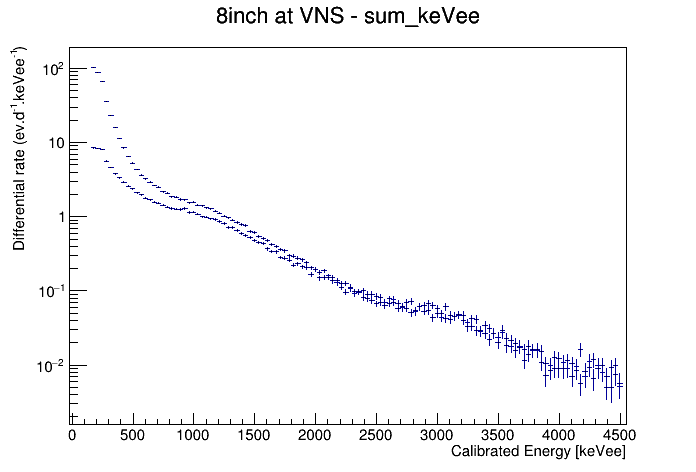

In [126]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
hCal_VNS_8inch->Draw();
hCal_VNS_9inch->Draw("SAME");

In [127]:
SignalandBackground_8inch_VNS->SetParameter(3, 3000);
SignalandBackground_8inch_VNS->SetParLimits(3, 2800, 3500);
SignalandBackground_8inch_VNS->SetParameter(2, 1);
SignalandBackground_8inch_VNS->SetParLimits(2, 0, 10);

TFitResultPtr r_8_VNS = hCal_VNS_8inch->Fit(SignalandBackground_8inch_VNS, "SR0", "", Emin_fit, Emax_fit);
r_8_VNS = hCal_VNS_8inch->Fit(SignalandBackground_8inch_VNS, "SR0", "", Emin_fit, Emax_fit);

TMatrixD CovMat_8_VNS = r_8_VNS->GetCovarianceMatrix();

//CovMat_8_VNS.Print();

Double_t err_norm_NP_8_VNS = sqrt(CovMat_8_VNS(2,2));
Double_t norm_NP_8_VNS = SignalandBackground_8inch_VNS->GetParameter(2);

Double_t err_norm_Bkg_8_VNS = sqrt(CovMat_8_VNS(0,0)+CovMat_8_VNS(1,1)+2*CovMat_8_VNS(0,1));
Double_t norm_Bckg_8_VNS = SignalandBackground_8inch_VNS->GetParameter(0)+SignalandBackground_8inch_VNS->GetParameter(1);

Double_t Norm_mu_8_VNS = SignalandBackground_8inch_VNS->GetParameter(0);
Double_t err_Norm_mu_8_VNS = SignalandBackground_8inch_VNS->GetParError(0);

Sum_background_8inch_VNS->SetParameter(0, Norm_mu_8_VNS);
Sum_background_8inch_VNS->SetParameter(1, SignalandBackground_8inch_VNS->GetParameter(1));

Muon_background_8inch_VNS->SetParameter(0, SignalandBackground_8inch_VNS->GetParameter(0));
Gamma_background_8inch->SetParameter(0, SignalandBackground_8inch_VNS->GetParameter(1));

Neutrons_8inch_VNS->SetParameter(0, SignalandBackground_8inch_VNS->GetParameter(2));
Neutrons_8inch_VNS->SetParameter(1, SignalandBackground_8inch_VNS->GetParameter(3));
Neutrons_8inch_VNS->SetParameter(2, SignalandBackground_8inch_VNS->GetParameter(4));

Double_t N_ev_tot_8_VNS = SignalandBackground_8inch_VNS->Integral(Emin, Emax);
Double_t N_ev_NP_8_VNS = Neutrons_8inch_VNS->Integral(Emin, Emax);
Double_t err_N_ev_NP_8_VNS = (err_norm_NP_8_VNS/norm_NP_8_VNS)*Neutrons_8inch_VNS->Integral(Emin, Emax);
Double_t N_ev_BKG_8_VNS = Sum_background_8inch_VNS->Integral(Emin, Emax);
Double_t err_N_ev_BKG_8_VNS = (err_norm_Bkg_8_VNS/norm_Bckg_8_VNS)*Sum_background_8inch_VNS->Integral(Emin, Emax);

Double_t err_N_ev_data_8_VNS;
Double_t N_ev_data_8_VNS = hCal_VNS_8inch->IntegralAndError(hCal_VNS_8inch->FindBin(Emin), hCal_VNS_8inch->FindBin(Emax), err_N_ev_data_8_VNS, "width");

Double_t err_N_ev_data_NP_8_VNS = sqrt(err_N_ev_data_8_VNS*err_N_ev_data_8_VNS + err_N_ev_BKG_8_VNS*err_N_ev_BKG_8_VNS);
Double_t N_ev_data_NP_8_VNS = N_ev_data_8_VNS-N_ev_BKG_8_VNS;

cout<<"\nChi2/ndf = "<<SignalandBackground_8inch_VNS->GetChisquare()<<"/"<<SignalandBackground_8inch_VNS->GetNDF()<<" = "<<SignalandBackground_8inch_VNS->GetChisquare()/SignalandBackground_8inch_VNS->GetNDF()<<endl;
cout<<"\nTotal N_ev in peak region = "<<N_ev_data_8_VNS<<" ev/d +- "<<err_N_ev_data_8_VNS<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from fit = "<<N_ev_NP_8_VNS<<" ev/d +- "<<err_N_ev_NP_8_VNS<<" ev/d (error from normalization error only!)"<<endl;
cout<<"N_ev in background = "<<N_ev_BKG_8_VNS<<" ev/d +- "<<err_N_ev_BKG_8_VNS<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from data - bckg = "<<N_ev_data_NP_8_VNS<<" ev/d +- "<<err_N_ev_data_NP_8_VNS<<" ev/d"<<endl;

 FCN=297.691 FROM MIGRAD    STATUS=CONVERGED     210 CALLS         211 TOTAL
                     EDM=3.49121e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Norm_muons   1.10697e-01   1.06416e-03   6.75212e-06   1.02190e-01
   2  Norm_gammas   1.15086e+00   1.05864e-02   6.71724e-05   7.68553e-03
   3  Norm_Neutr   6.49480e-14   1.30092e-03   1.92644e-04** at limit **
   4  Mean_gauss   2.80417e+03   5.22569e+02   5.00000e-01   6.02540e-11
   5  Sigma_gauss   2.23200e+02     fixed    
 FCN=289.202 FROM MIGRAD    STATUS=CONVERGED     128 CALLS         129 TOTAL
                     EDM=1.18798e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Norm_muons   1.09587e-01   1.13138e-03   6.65548e-06 

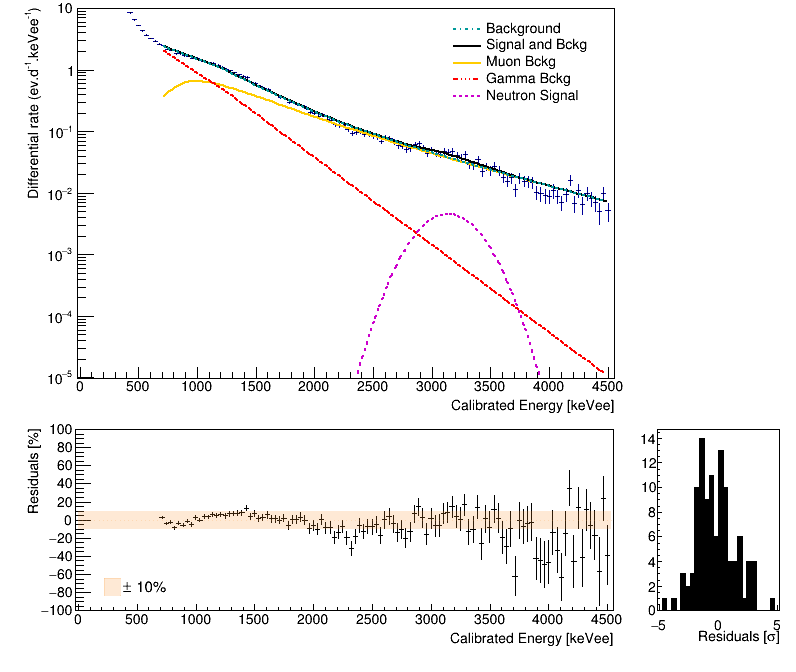

Warning in <TFile::Append>: Replacing existing TH1: Reduced_res_ (Potential memory leak).
Info in <TCanvas::Print>: pdf file Figs/Finals/Fit_VNS_8inch.pdf has been created


In [128]:
TCanvas* C = new TCanvas("cVNS_8inch", "cVNS_8inch", 800, 700);
C->Draw();
TPad *p0 = new TPad("p0","p0",0.02,0.375,0.795,1.);
p0->Draw();
p0->cd();
p0->SetLeftMargin(0.1);
p0->SetRightMargin(0.03);
p0->SetBottomMargin(0.1);
p0->SetTopMargin(0.02);

p0->SetLogy();
hCal_VNS_8inch->Draw("");
hCal_VNS_8inch->GetXaxis()->SetTitleOffset(1.1);
hCal_VNS_8inch->GetXaxis()->SetTitleOffset(1.2);
hCal_VNS_8inch->SetTitle(0);
hCal_VNS_8inch->GetYaxis()->SetRangeUser(1e-5, 10);
SignalandBackground_8inch_VNS->SetLineColor(kBlack);
Sum_background_8inch_VNS->SetLineColor(kBlue);
Sum_background_8inch_VNS->Draw("SAME");
Muon_background_8inch_VNS->SetLineColor(kOrange);
Gamma_background_8inch->SetLineColor(kRed);
Muon_background_8inch_VNS->Draw("SAME");
Gamma_background_8inch->Draw("SAME");
Gamma_background_8inch->SetLineStyle(6);
Sum_background_8inch_VNS->Draw("SAME");
SignalandBackground_8inch_VNS->Draw("SAME");
Neutrons_8inch_VNS->SetLineColor(kMagenta+1);
Neutrons_8inch_VNS->SetLineStyle(2);
Neutrons_8inch_VNS->Draw("SAME");
Sum_background_8inch_VNS->SetLineStyle(4);
Sum_background_8inch_VNS->SetLineColor(kCyan+2);
Sum_background_8inch_VNS->Draw("SAME");

TLegend* leg0 = new TLegend(0.7, 0.75, 0.95, 0.95);
leg0->AddEntry(Sum_background_8inch_VNS, "Background", "l");
leg0->AddEntry(SignalandBackground_8inch_VNS, "Signal and Bckg", "l");
leg0->AddEntry(Muon_background_8inch_VNS, "Muon Bckg", "l");
leg0->AddEntry(Gamma_background_8inch, "Gamma Bckg", "l");
leg0->AddEntry(Neutrons_8inch_VNS, "Neutron Signal", "l");
leg0->SetLineWidth(0);
leg0->Draw("SAME");

C->cd();
TPad *p1 = new TPad("p1","p1",0.,0.02,0.795,0.375);
p1->Draw();
p1->cd();
p1->SetLeftMargin(0.12);
p1->SetRightMargin(0.03);
p1->SetBottomMargin(0.2);
p1->SetTopMargin(0.04);

histosRes_VNS_8inch = Residuals_vec(hCal_VNS_8inch, SignalandBackground_8inch_VNS, Emin_fit, Emax_fit, true);
hRes_VNS_8inch=histosRes_VNS_8inch[0];
hRes_VNS_8inch->GetYaxis()->SetTitle("Residuals [%]");
hRes_VNS_8inch->GetYaxis()->SetTitleOffset(0.65);
hRes_VNS_8inch->GetYaxis()->SetTitleSize(1.8*hCal_VNS_8inch->GetYaxis()->GetTitleSize());
hRes_VNS_8inch->GetXaxis()->SetTitleSize(1.8*hCal_VNS_8inch->GetXaxis()->GetTitleSize());
hRes_VNS_8inch->GetYaxis()->SetLabelSize(1.8*hCal_VNS_8inch->GetYaxis()->GetLabelSize());
hRes_VNS_8inch->GetXaxis()->SetLabelSize(1.8*hCal_VNS_8inch->GetXaxis()->GetLabelSize());
hRes_VNS_8inch->Draw("");

h_10pc->Draw("E3SAME");


TLegend* leg = new TLegend(0.16, 0.25, 0.3, 0.35);
leg->AddEntry(h_10pc, "#pm 10%", "f");
leg->Draw("SAME");
leg->SetLineWidth(0);


C->cd();
TPad *p2 = new TPad("p2","p2",0.795,0.02,1.,0.375);
p2->Draw();
p2->cd();
p2->SetLeftMargin(0.15);
p2->SetBottomMargin(0.2);
p2->SetTopMargin(0.04);

hRedRes_VNS_8inch=histosRes_VNS_8inch[1];
hRedRes_VNS_8inch->Draw("");
hRedRes_VNS_8inch->GetXaxis()->SetTitle("Residuals [#sigma]");
hRedRes_VNS_8inch->GetYaxis()->SetTitleSize(3.*hCal_VNS_8inch->GetYaxis()->GetTitleSize());
hRedRes_VNS_8inch->GetXaxis()->SetTitleSize(2.7*hCal_VNS_8inch->GetXaxis()->GetTitleSize());
hRedRes_VNS_8inch->GetXaxis()->SetTitleOffset(0.7);
hRedRes_VNS_8inch->GetYaxis()->SetLabelSize(2.7*hCal_VNS_8inch->GetYaxis()->GetLabelSize());
hRedRes_VNS_8inch->GetXaxis()->SetLabelSize(2.7*hCal_VNS_8inch->GetXaxis()->GetLabelSize());
hRedRes_VNS_8inch->GetXaxis()->SetNdivisions(5);

C->SaveAs("Figs/Finals/Fit_VNS_8inch.pdf");

# Plot muon and gamma functions

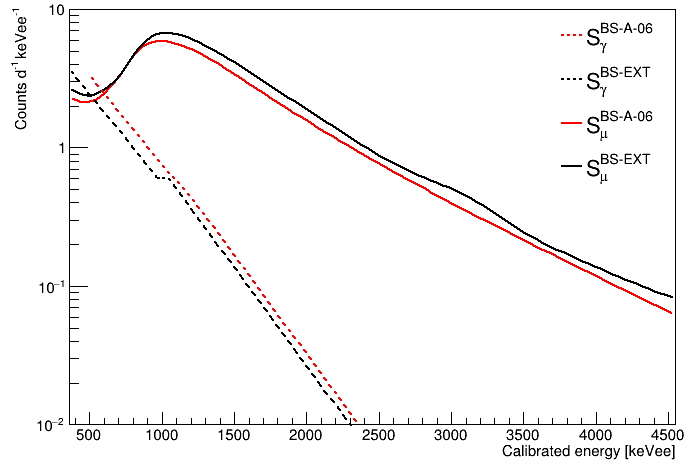

Info in <TCanvas::Print>: png file /Users/cg264002/research/Redaction_These/Figures/Chap3/Neutrons/ModelSpectra_BS.png has been created


In [129]:
TCanvas* C = new TCanvas();
C->Draw();
gPad->SetLeftMargin(0.1);
gPad->SetRightMargin(0.03);
gPad->SetBottomMargin(0.1);
gPad->SetTopMargin(0.02);
gPad->SetLogy();

Muon_shape_8inch_VNS->SetTitle("");
Muon_shape_9inch_VNS->SetLineColor(kBlack);
Muon_shape_8inch_VNS->SetLineColor(kRed);
Muon_shape_8inch_VNS->SetLineStyle(1);
Muon_shape_8inch_VNS->GetXaxis()->SetRangeUser(400, 4500);
Muon_shape_8inch_VNS->GetYaxis()->SetRangeUser(0.01, 10);

Muon_shape_8inch_VNS->Draw("L");
Muon_shape_9inch_VNS->Draw("L SAME");
Muon_shape_9inch_VNS->SetLineStyle(1);

Gamma_shape_8inch->SetTitle("");
Gamma_shape_9inch->SetLineColor(kBlack);
Gamma_shape_8inch->SetLineColor(kRed);
Gamma_shape_8inch->SetLineStyle(2);

Gamma_shape_8inch->Draw("RL SAME");
Gamma_shape_9inch->Draw("RL SAME");
Gamma_shape_9inch->SetLineStyle(2);

Muon_shape_8inch_VNS->GetYaxis()->SetTitle("Counts d^{-1} keVee^{-1}");
Muon_shape_8inch_VNS->GetXaxis()->SetTitle("Calibrated energy [keVee]");

TLegend* leg0 = new TLegend(0.8, 0.6, 0.97, 0.97);
leg0->SetTextSize(0.05);
leg0->AddEntry(Gamma_shape_8inch, "S_{#gamma}^{BS-A-06}", "l");
leg0->AddEntry(Gamma_shape_9inch, "S_{#gamma}^{BS-EXT}", "l");
leg0->AddEntry(Muon_shape_8inch_VNS, "S_{#mu}^{BS-A-06}", "l");
leg0->AddEntry(Muon_shape_9inch_VNS, "S_{#mu}^{BS-EXT}", "l");
leg0->SetLineWidth(0);
leg0->Draw("SAME");

C->SaveAs("/Users/cg264002/research/Redaction_These/Figures/Chap3/Neutrons/ModelSpectra_BS.png");

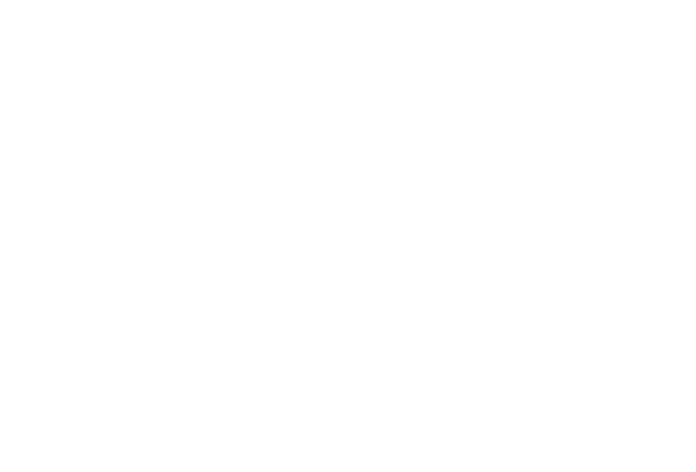

In [130]:
TCanvas* C = new TCanvas();
C->Draw();
gPad->SetLeftMargin(0.1);
gPad->SetRightMargin(0.03);
gPad->SetBottomMargin(0.1);
gPad->SetTopMargin(0.02);
gPad->SetLogy();


Muon_shape_8inch_VNS->GetYaxis()->SetTitle("Arbitrary scale []");
Muon_shape_8inch_VNS->GetXaxis()->SetTitle("Calibrated energy [keVee]");

# Attenuation from VNS


The >10 MeV neutron contribution is expected to be extracted from the difference between the number of events with the 9inch and the 8inch spheres. 

## First "naive" calculation of the attenuation

In [131]:
cout<<"------------------------------ VNS -------------------------------"<<endl;
cout<<" 9inch: "<< N_ev_NP_VNS << " +- " << err_N_ev_NP_VNS<<" (stat.) "<<endl;
cout<<" 8inch: "<< N_ev_NP_8_VNS << " +- " << err_N_ev_NP_8_VNS<<" (stat.) "<<endl;

cout<<"\n------------------------ Surface (DCHut) -----------------------"<<endl;
cout<<" 9inch: "<< N_ev_NP_DC << " +- " << err_N_ev_NP_DC<<" (stat.) "<<endl;
cout<<" 8inch: "<< N_ev_NP_8_DC << " +- " << err_N_ev_NP_8_DC<<" (stat.) "<<endl;

------------------------------ VNS -------------------------------
 9inch: 9.27149 +- 1.055 (stat.) 
 8inch: 2.55429 +- 0.883768 (stat.) 

------------------------ Surface (DCHut) -----------------------
 9inch: 142.821 +- 3.33645 (stat.) 
 8inch: 95.5141 +- 3.63483 (stat.) 


In [132]:
//FastNeutrons_Surface = N_ev_NP_DC-N_ev_NP_8_DC;
//err_FastNeutrons_Surface = sqrt(err_N_ev_NP_DC*err_N_ev_NP_DC+err_N_ev_NP_8_DC*err_N_ev_NP_8_DC);

//FastNeutrons_VNS = N_ev_NP_VNS-N_ev_NP_8_VNS;
//err_FastNeutrons_VNS = sqrt(err_N_ev_NP_VNS*err_N_ev_NP_VNS+err_N_ev_NP_8_VNS*err_N_ev_NP_8_VNS);

mean_Surface = 143.65-98.62;
mean_VNS = 8.76-3.08;

mean_err_stat_Surface = sqrt(3.32*3.32+3.67+3.67);
mean_err_stat_VNS = sqrt(1.07*1.07+0.89*0.98);

errSyst_FastNeutrons_Surface = sqrt(0.67*0.67+3.16*3.16);
errSyst_FastNeutrons_VNS = sqrt(0.67*0.67+1.06*1.06);

cout<< ">10MeV Neutron contribution"<<endl;
cout<< "----------------------------"<<endl;
cout<<"Surface: "<<mean_Surface<<" +- "<<mean_err_stat_Surface<<" (stat.)" <<" +- "<< errSyst_FastNeutrons_Surface <<" (syst. ) ev/d"<<endl;
cout<<"VNS: "<<mean_VNS<<" +- "<<mean_err_stat_VNS<<" (stat.)"<< " +- " <<errSyst_FastNeutrons_VNS <<" (syst. ) ev/d"<<endl;


>10MeV Neutron contribution
----------------------------
Surface: 45.03 +- 4.28514 (stat.) +- 3.23025 (syst. ) ev/d
VNS: 5.68 +- 1.42025 (stat.) +- 1.25399 (syst. ) ev/d


In [133]:
Ratio = mean_Surface/mean_VNS;
err_Ratio = Ratio*sqrt((mean_err_stat_VNS/mean_VNS)*(mean_err_stat_Surface/mean_Surface)*(mean_err_stat_Surface/mean_Surface));

cout<<"Ratio = "<<Ratio<<" +- "<<err_Ratio<< " (stat. only)" << endl; 

Ratio = 7.92782 +- 0.377246 (stat. only)


<b>Aside</b>: Let's check the consistency of the attenuation observed for muons

In [134]:
cout<<"Muons attenuation in 8inch = "<<Norm_mu_8_DC/Norm_mu_8_VNS<<" +- "<<(Norm_mu_8_DC/Norm_mu_8_VNS)*sqrt((err_Norm_mu_8_DC/Norm_mu_8_DC)*(err_Norm_mu_8_DC/Norm_mu_8_DC)+(err_Norm_mu_8_VNS/Norm_mu_8_VNS)*(err_Norm_mu_8_VNS/Norm_mu_8_VNS))<<endl;
cout<<"Muons attenuation in 9inch = "<<Norm_mu_9_DC/Norm_mu_9_VNS<<" +- "<<(Norm_mu_9_DC/Norm_mu_9_VNS)*sqrt((err_Norm_mu_9_DC/Norm_mu_9_DC)*(err_Norm_mu_9_DC/Norm_mu_9_DC)+(err_Norm_mu_9_VNS/Norm_mu_9_VNS)*(err_Norm_mu_9_VNS/Norm_mu_9_VNS))<<endl;

Muons attenuation in 8inch = 1.86143 +- 0.0279195
Muons attenuation in 9inch = 2.17739 +- 0.0289059


The attenuation value is close to the one expected (1.4) but they are not compatible with each other at 1 sigma. This can be due to simplificity of the neutron contribution in the DC data? Gamma/Muon backgrounds not correctly modelled? 

## Estimate of the attenuation from a Toy MonteCarlo

### Considering stat. errors only

In [135]:
TF1* Gaus_ev_DC = new TF1("Gauss_ev_DC", "TMath::Gaus(x, [0], [1], true)", 0, mean_Surface+5*mean_err_stat_Surface);
Gaus_ev_DC->FixParameter(0, mean_Surface);
Gaus_ev_DC->FixParameter(1, mean_err_stat_Surface);

TF1* Gaus_ev_VNS = new TF1("Gauss_ev_VNS", "TMath::Gaus(x, [0], [1], true)", 0, mean_VNS+5*mean_err_stat_VNS);
Gaus_ev_VNS->FixParameter(0, mean_VNS);
Gaus_ev_VNS->FixParameter(1, mean_err_stat_VNS);

TF1* Gaus_ev_DC_syst = new TF1("Gaus_ev_DC_syst", "TMath::Gaus(x, [0], [1], true)", 0, mean_Surface+5*errSyst_FastNeutrons_Surface);
Gaus_ev_DC_syst->FixParameter(0, mean_Surface);
Gaus_ev_DC_syst->FixParameter(1, errSyst_FastNeutrons_Surface);

TF1* Gaus_ev_VNS_syst = new TF1("Gaus_ev_VNS_syst", "TMath::Gaus(x, [0], [1], true)", 0, mean_VNS+5*errSyst_FastNeutrons_VNS);
Gaus_ev_VNS_syst->FixParameter(0, mean_VNS);
Gaus_ev_VNS_syst->FixParameter(1, errSyst_FastNeutrons_VNS);

TF1* NumEv = new TF1("NumEv", "TMath::Gaus(x, [0], [1], true)", 0, 117.7+5*3.5);
NumEv->FixParameter(0, 117.7);
NumEv->FixParameter(1, 3.5);

In [136]:
TH1D* hRatio = new TH1D("Attenuation factor from Toy MC", "Attenuation factor from Toy MC", 10000, 0, 500);
Double_t Ev_out, Ev_VNS;   
for (int i=0; i<100000; i++){
    Ev_out = Gaus_ev_DC->GetRandom();
    Ev_VNS = Gaus_ev_VNS->GetRandom();
    if ((Ev_VNS>0)&&(Ev_out>0)) {hRatio->Fill(Ev_out/Ev_VNS);}
}

hRatio->GetXaxis()->SetRangeUser(0, 40);
hRatio->GetXaxis()->SetTitle("R^{Surface}/R_{VNS}");
hRatio->GetYaxis()->SetTitle("Probability");
hRatio->Scale(1./hRatio->Integral());

In [137]:
TH1D* hRatio_syststat = new TH1D("Attenuation factor from Toy MC syst stat", "Attenuation factor from Toy MC syst stat", 10000, 0, 500);
TH1D* hNewNumEv = new TH1D("hNewNumEv", "hNewNumEv", 1000, 0, 300);
Double_t Ev_out_1, Ev_VNS_1, Ev_out, Ev_VNS, NumEv_i;   
for (int i=0; i<100; i++){
    Ev_out_1 = Gaus_ev_DC_syst->GetRandom();
    Gaus_ev_DC->SetParameter(0, Ev_out_1);
    Ev_out = Gaus_ev_DC->GetRandom();
    
    Ev_VNS_1 = Gaus_ev_VNS_syst->GetRandom();
    Gaus_ev_VNS->SetParameter(0, Ev_VNS_1);
    Ev_VNS = Gaus_ev_VNS->GetRandom();
    
    NumEv_i = NumEv->GetRandom();
    if ((Ev_VNS>0)&&(Ev_out>0)) {hRatio_syststat->Fill(Ev_out/Ev_VNS);}
    if ((Ev_VNS>0)&&(Ev_out>0)) {hNewNumEv->Fill(NumEv_i/(Ev_out/Ev_VNS));}
}

hRatio_syststat->SetLineColor(kRed);
hRatio_syststat->GetXaxis()->SetRangeUser(0, 100);
hRatio_syststat->GetXaxis()->SetTitle("R^{Surface}/R_{VNS}");
hRatio_syststat->GetYaxis()->SetTitle("Probability");
hRatio_syststat->Scale(1./hRatio_syststat->Integral());

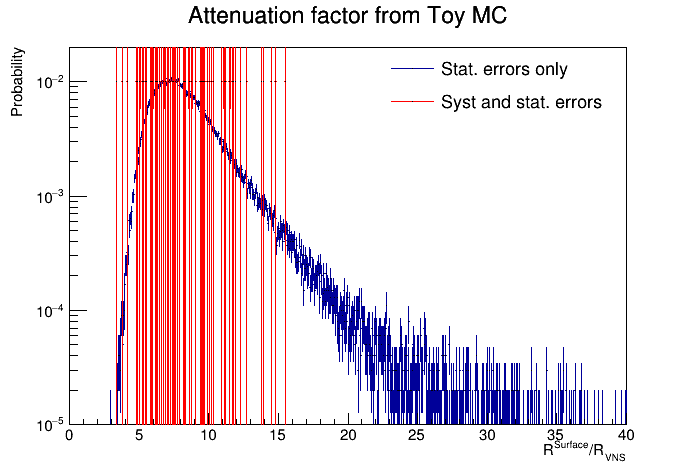

In [138]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
hRatio->Draw("");
hRatio->GetYaxis()->SetRangeUser(1e-5, 2e-2);
hRatio_syststat->Draw("SAME");

TLegend* leg = new TLegend(0.55, 0.75, 0.89, 0.89);
leg->AddEntry(hRatio, "Stat. errors only");
leg->AddEntry(hRatio_syststat, "Syst and stat. errors");
leg->Draw("SAME");
leg->SetLineWidth(0);

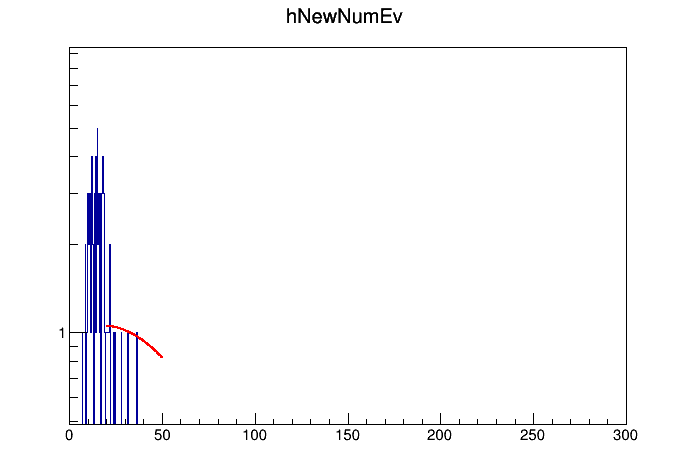

 FCN=0.474335 FROM MIGRAD    STATUS=CONVERGED     205 CALLS         206 TOTAL
                     EDM=1.59516e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.05678e+00   5.00428e-01   1.70491e-04  -2.58099e-03
   2  Mean         1.77058e+01   1.23722e+02   4.11168e-02  -1.17197e-05
   3  Sigma        4.55059e+01   2.60989e+01   2.12077e-02   4.40917e-05


In [139]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
hNewNumEv->Draw("");

hNewNumEv->Fit("gaus", "", "", 20, 50);

In [140]:
Double_t Rmin=0;
Double_t Pas=0.02;
Double_t int_below_min=0;
while (int_below_min<0.05){
    Rmin+= Pas;
    int_below_min = hRatio->Integral(0, hRatio->FindBin(Rmin));
}
Rmin -= Pas;
int_below_min = hRatio->Integral(0, hRatio->FindBin(Rmin));

cout<<"Attenuation factor > "<< Rmin<<" at "<<(1-int_below_min)*100 << " % confidence level"<<endl;

Attenuation factor > 5.4 at 95.0074 % confidence level


In [141]:
Double_t Rmin=0;
Double_t Pas=0.02;
Double_t int_below_min=0;
while (int_below_min<0.05){
    Rmin+= Pas;
    int_below_min = hRatio_syststat->Integral(0, hRatio_syststat->FindBin(Rmin));
}
Rmin -= Pas;
int_below_min = hRatio_syststat->Integral(0, hRatio_syststat->FindBin(Rmin));

cout<<"Attenuation factor > "<< Rmin<<" at "<<(1-int_below_min)*100 << " % confidence level"<<endl;

Attenuation factor > 4.84 at 96 % confidence level


In [142]:
MPV = hRatio->GetBinCenter(hRatio->GetMaximumBin());

Double_t maximum = hRatio->GetBinContent(hRatio->GetMaximumBin());
cout<<maximum<<endl;
Double_t y_value=0;
Double_t indexRmin, indexRmax;
Double_t Pas=0.00001;
Double_t int_between_min_max=0;
while (int_between_min_max<0.65){
    y_value += Pas;
    indexRmin = hRatio->FindFirstBinAbove (maximum-y_value, 1);
    indexRmax = hRatio->FindLastBinAbove (maximum-y_value, 1);
    int_between_min_max = hRatio->Integral(indexRmin, indexRmax);
}

cout<<"MPV = "<< MPV <<" + "<<hRatio->GetBinCenter(indexRmax)-MPV<<" - "<<MPV-hRatio->GetBinCenter(indexRmin) << " with a probability of "<<int_between_min_max*100<<" %" <<endl;

0.0109079
MPV = 7.475 + 1.95 - 1.85 with a probability of 66.1006 %


In [143]:
MPV = hRatio_syststat->GetBinCenter(hRatio_syststat->GetMaximumBin());

Double_t maximum = hRatio_syststat->GetBinContent(hRatio_syststat->GetMaximumBin());
cout<<maximum<<endl;
Double_t y_value=0;
Double_t indexRmin, indexRmax;
Double_t Pas=0.00001;
Double_t int_between_min_max=0;
while (int_between_min_max<0.65){
    y_value += Pas;
    indexRmin = hRatio_syststat->FindFirstBinAbove (maximum-y_value, 1);
    indexRmax = hRatio_syststat->FindLastBinAbove (maximum-y_value, 1);
    int_between_min_max = hRatio_syststat->Integral(indexRmin, indexRmax);
}

cout<<"MPV = "<< MPV <<" + "<<hRatio_syststat->GetBinCenter(indexRmax)-MPV<<" - "<<MPV-hRatio_syststat->GetBinCenter(indexRmin) << " with a probability of "<<int_between_min_max*100<<" %" <<endl;

0.03
MPV = 6.425 + 5.1 - 1.35 with a probability of 83 %


### With previous fits (linear and exponential)

#### Linear

In [144]:
TF1* Gaus_ev_DC_lin = new TF1("Gaus_ev_DC_lin", "TMath::Gaus(x, [0], [1], true)", 0, 22+5*6.2);
Gaus_ev_DC_lin->FixParameter(0, 21.7);
Gaus_ev_DC_lin->FixParameter(1, 6.2);

TF1* Gaus_ev_VNS_lin = new TF1("Gaus_ev_VNS_lin", "TMath::Gaus(x, [0], [1], true)", 0, 4.8+5*7);
Gaus_ev_VNS_lin->FixParameter(0, 4.8);
Gaus_ev_VNS_lin->FixParameter(1, 6.9);

In [145]:
TH1D* hRatio_lin = new TH1D("Attenuation factor from Toy MC with linear fit", "Attenuation factor from Toy MC with linear fit", 10000, 0, 500);
Double_t Ev_out, Ev_VNS;   
for (int i=0; i<100000; i++){
    Ev_out = Gaus_ev_DC_lin->GetRandom();
    Ev_VNS = Gaus_ev_VNS_lin->GetRandom();
    if ((Ev_VNS>0)&&(Ev_out>0)) {hRatio_lin->Fill(Ev_out/Ev_VNS);}
}

hRatio_lin->GetXaxis()->SetRangeUser(0, 20);
hRatio_lin->GetXaxis()->SetTitle("R^{Out}/R_{VNS}");
hRatio_lin->GetYaxis()->SetTitle("Probability");
hRatio_lin->Scale(1./hRatio_lin->Integral());

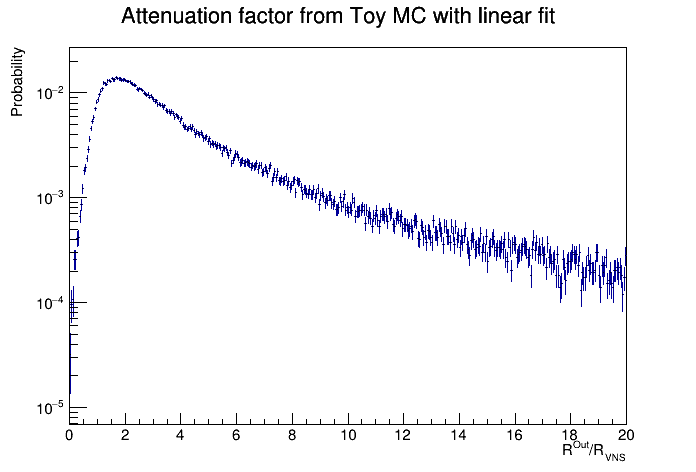

In [146]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
hRatio_lin->Draw("");

In [147]:
Double_t Rmin=0;
Double_t Pas=0.02;
Double_t int_below_min=0;
while (int_below_min<0.05){
    Rmin+= Pas;
    int_below_min = hRatio_lin->Integral(0, hRatio_lin->FindBin(Rmin));
}
Rmin -= Pas;
int_below_min = hRatio_lin->Integral(0, hRatio_lin->FindBin(Rmin));

cout<<"Attenuation factor > "<< Rmin<<" at "<<(1-int_below_min)*100 << " % confidence level"<<endl;

Attenuation factor > 0.98 at 95.1994 % confidence level


#### Exponential fit

In [148]:
TF1* Gaus_ev_DC_expo = new TF1("Gaus_ev_DC_expo", "TMath::Gaus(x, [0], [1], true)", 0, 39+5*9.2);
Gaus_ev_DC_expo->FixParameter(0, 39);
Gaus_ev_DC_expo->FixParameter(1, 9.2);

TF1* Gaus_ev_VNS_expo = new TF1("Gaus_ev_VNS_lin", "TMath::Gaus(x, [0], [1], true)", 0, 7.5+5*6.9);
Gaus_ev_VNS_expo->FixParameter(0, 7.5);
Gaus_ev_VNS_expo->FixParameter(1, 6.9);

In [149]:
TH1D* hRatio_expo = new TH1D("Attenuation factor from Toy MC with exponential fit", "Attenuation factor from Toy MC with exponential fit", 10000, 0, 500);
Double_t Ev_out, Ev_VNS;   
for (int i=0; i<100000; i++){
    Ev_out = Gaus_ev_DC_expo->GetRandom();
    Ev_VNS = Gaus_ev_VNS_expo->GetRandom();
    if ((Ev_VNS>0)&&(Ev_out>0)) {hRatio_expo->Fill(Ev_out/Ev_VNS);}
}

hRatio_expo->GetXaxis()->SetRangeUser(0, 20);
hRatio_expo->GetXaxis()->SetTitle("R^{Out}/R_{VNS}");
hRatio_expo->GetYaxis()->SetTitle("Probability");
hRatio_expo->Scale(1./hRatio_expo->Integral());

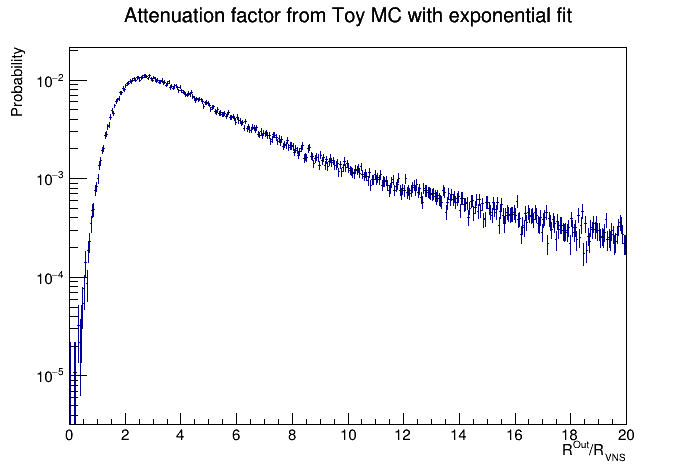

In [150]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
hRatio_expo->Draw("");

In [151]:
Double_t Rmin=0;
Double_t Pas=0.02;
Double_t int_below_min=0;
while (int_below_min<0.05){
    Rmin+= Pas;
    int_below_min = hRatio_expo->Integral(0, hRatio_expo->FindBin(Rmin));
}
Rmin -= Pas;
int_below_min = hRatio_expo->Integral(0, hRatio_expo->FindBin(Rmin));

cout<<"Attenuation factor > "<< Rmin<<" at "<<(1-int_below_min)*100 << " % confidence level"<<endl;

Attenuation factor > 1.68 at 95.0564 % confidence level


# Other fitting methods

## Local linear background

In [152]:
TF1* Model_linear = new TF1("Model_linear", "gaus(0)+pol1(3)", 3000, 4700);

In [153]:
TF1* Linear_bckg = new TF1("Linear_bckg", "pol1", 3000, 4700);

### 9inch

In [154]:
Int_start = 3000;
Int_stop = 4500;

Model_linear->SetParameter(1, 3500);
if (Model_linear->GetParameter(2)==0) Model_linear->SetParameter(2, Resol_NP*3500);

TFitResultPtr r = hCal_DC_9inch->Fit(Model_linear, "S0", "", 3000, 5100);

TMatrixD CovMat_9_lin_DC = r->GetCovarianceMatrix();

//CovMat_DC.Print();

Double_t err_norm_NP_DC_lin = sqrt(CovMat_9_lin_DC(0,0));
Double_t norm_NP_DC_lin = Model_linear->GetParameter(0);

Linear_bckg->SetParameter(0, Model_linear->GetParameter(3));
Linear_bckg->SetParameter(1, Model_linear->GetParameter(4));

Neutron_signal_9inch->SetParameter(0, Model_linear->GetParameter(0));
Neutron_signal_9inch->SetParameter(1, Model_linear->GetParameter(1));
Neutron_signal_9inch->SetParameter(2, Model_linear->GetParameter(2));

Double_t N_ev_tot_DC_lin = Model_linear->Integral(Int_start, Int_stop);
Double_t N_ev_NP_DC_lin = Neutron_signal_9inch->Integral(Int_start, Int_stop);
Double_t err_N_ev_NP_DC_lin = (err_norm_NP_DC_lin/norm_NP_DC_lin)*Neutron_signal_9inch->Integral(Int_start, Int_stop);
Double_t N_ev_BKG_DC_lin = Linear_bckg->Integral(Int_start, Int_stop);
Double_t err_N_ev_BKG_DC_lin = sqrt((Int_stop-Int_start)*(Int_stop-Int_start)*CovMat_9_lin_DC(3,3)+(Int_stop-Int_start)*(Int_stop*Int_stop-Int_start*Int_start)*CovMat_9_lin_DC(3, 4)+(Int_stop*Int_stop-Int_start*Int_start)*(Int_stop*Int_stop-Int_start*Int_start)*CovMat_9_lin_DC(4,4)/4);

Double_t err_N_ev_data_DC_lin;
Double_t N_ev_data_DC_lin = hCal_DC_9inch->IntegralAndError(hCal_DC_9inch->FindBin(Int_start), hCal_DC_9inch->FindBin(Int_stop), err_N_ev_data_DC_lin, "width");

Double_t err_N_ev_data_NP_DC_lin = sqrt(err_N_ev_data_DC_lin*err_N_ev_data_DC_lin + err_N_ev_BKG_DC_lin*err_N_ev_BKG_DC_lin);
Double_t N_ev_data_NP_DC_lin = N_ev_data_DC_lin-N_ev_BKG_DC_lin;

cout<<"\nChi2/ndf = "<<Model_linear->GetChisquare()<<"/"<<Model_linear->GetNDF()<<" = "<<Model_linear->GetChisquare()/Model_linear->GetNDF()<<endl;
cout<<"\nTotal N_ev in peak region = "<<N_ev_data_DC_lin<<" ev/d +- "<<err_N_ev_data_DC_lin<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from fit = "<<N_ev_NP_DC_lin<<" ev/d +- "<<err_N_ev_NP_DC_lin<<" ev/d "<<endl;
cout<<"N_ev in background = "<<N_ev_BKG_DC_lin<<" ev/d +- "<<err_N_ev_BKG_DC_lin<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from data - bckg = "<<N_ev_data_NP_DC_lin<<" ev/d +- "<<err_N_ev_data_NP_DC_lin<<" ev/d"<<endl;

Model_linear->FixParameter(2, Model_linear->GetParameter(2)); //Fix the sigma value of the neutron peak  

 FCN=1178.93 FROM HESSE     STATUS=NOT POSDEF     39 CALLS         386 TOTAL
                     EDM=3.18667e-07    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.45019e-01   1.31724e-02   3.21738e-06   8.24468e-01
   2  p1           6.97572e+03   1.41210e+00   1.98200e+03  -3.34192e-11
   3  p2           4.17615e+06   1.41210e+00   2.02164e+05  -2.89727e-11
   4  p3           2.45022e-01   1.31723e-02   3.21738e-06   8.24222e-01
   5  p4          -1.09786e-04   2.20448e-06   7.94578e-10   3.37311e+03

Chi2/ndf = 1178.93/37 = 31.8629

Total N_ev in peak region = 160.277 ev/d +- 2.16677 ev/d
N_ev in neutron peak from fit = 192.024 ev/d +- 10.3233 ev/d 
N_ev in background = -250.013 ev/d +- 19.8338 ev/d
N_ev in neutron peak from data - bckg = 410.291 ev/d +- 19.9518 ev/d


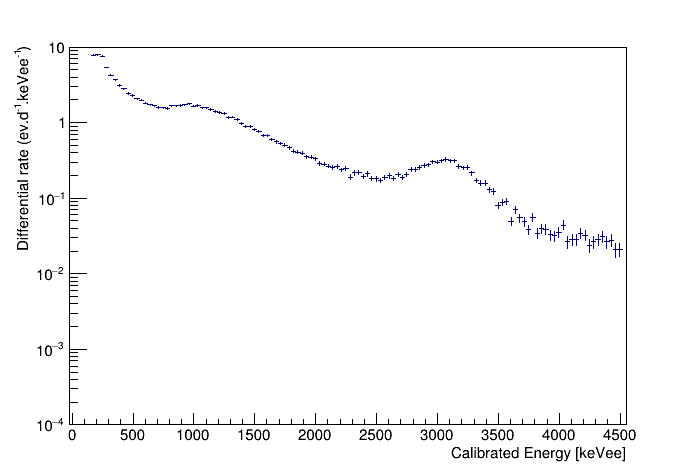

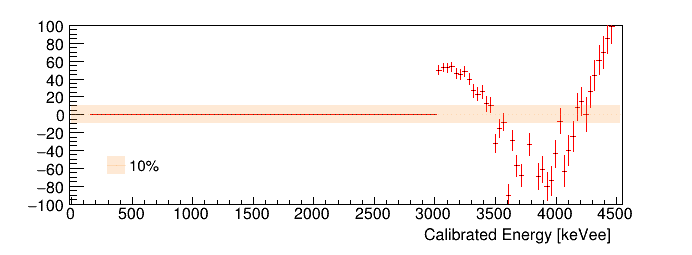

In [155]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
hCal_DC_9inch->Draw("");
hCal_DC_9inch->GetYaxis()->SetRangeUser(1e-4, 10);
Linear_bckg->SetLineColor(kBlue);
Linear_bckg->Draw("RSAME");
Model_linear->Draw("RSAME");

TCanvas* C2 = new TCanvas("cRes_DC_9inch_lin", "cRes_DC_9inch_lin", C->GetWw(), 0.6*C->GetWh());
C2->Draw();
gPad->SetMargin(0.1,0.1,0.2,0.1);

hRes_DC_9inch_lin=Residuals(hCal_DC_9inch, Model_linear, 3000, 4700, true);
hRes_DC_9inch_lin->GetYaxis()->SetTitle("Residuals [%]");
hRes_DC_9inch_lin->GetYaxis()->SetTitleSize(2*hCal_DC_9inch->GetYaxis()->GetTitleSize());
hRes_DC_9inch_lin->GetXaxis()->SetTitleSize(2*hCal_DC_9inch->GetXaxis()->GetTitleSize());
hRes_DC_9inch_lin->GetYaxis()->SetLabelSize(2*hCal_DC_9inch->GetYaxis()->GetLabelSize());
hRes_DC_9inch_lin->GetXaxis()->SetLabelSize(2*hCal_DC_9inch->GetXaxis()->GetLabelSize());
hRes_DC_9inch_lin->Draw("");

h_10pc->SetLineColorAlpha(kOrange+1, 0.2);
h_10pc->SetMarkerColorAlpha(kOrange+1, 0.2);
h_10pc->SetFillColorAlpha(kOrange+1, 0.2);
h_10pc->Draw("E3SAME");

TLegend* leg = new TLegend(0.15, 0.3, 0.30, 0.4);
leg->AddEntry(h_10pc, "10%");
leg->Draw("SAME");
leg->SetLineWidth(0);

In [156]:
Int_start = 3000;
Int_stop = 4500;

Model_linear->SetParLimits(0, 0, 10);

TFitResultPtr r = hCal_VNS_9inch->Fit(Model_linear, "S0", "", 3000, 4700);

TMatrixD CovMat_9_lin_VNS = r->GetCovarianceMatrix();

//CovMat_DC.Print();

Double_t err_norm_NP_VNS_lin = sqrt(CovMat_9_lin_VNS(0,0));
Double_t norm_NP_VNS_lin = Model_linear->GetParameter(0);

Linear_bckg->SetParameter(0, Model_linear->GetParameter(3));
Linear_bckg->SetParameter(1, Model_linear->GetParameter(4));

Neutron_signal_9inch->SetParameter(0, Model_linear->GetParameter(0));
Neutron_signal_9inch->SetParameter(1, Model_linear->GetParameter(1));
Neutron_signal_9inch->SetParameter(2, Model_linear->GetParameter(2));

Double_t N_ev_tot_VNS_lin = Model_linear->Integral(Int_start, Int_stop);
Double_t N_ev_NP_VNS_lin = Neutron_signal_9inch->Integral(Int_start, Int_stop);
Double_t err_N_ev_NP_VNS_lin = (err_norm_NP_VNS_lin/norm_NP_VNS_lin)*Neutron_signal_9inch->Integral(Int_start, Int_stop);
Double_t N_ev_BKG_VNS_lin = Linear_bckg->Integral(Int_start, Int_stop);
Double_t err_N_ev_BKG_VNS_lin = sqrt((Int_stop-Int_start)*(Int_stop-Int_start)*CovMat_9_lin_VNS(3,3)+(Int_stop-Int_start)*(Int_stop*Int_stop-Int_start*Int_start)*CovMat_9_lin_VNS(3, 4)+(Int_stop*Int_stop-Int_start*Int_start)*(Int_stop*Int_stop-Int_start*Int_start)*CovMat_9_lin_VNS(4,4)/4);

Double_t err_N_ev_data_VNS_lin;
Double_t N_ev_data_VNS_lin = hCal_VNS_9inch->IntegralAndError(hCal_VNS_9inch->FindBin(Int_start), hCal_VNS_9inch->FindBin(Int_stop), err_N_ev_data_VNS_lin, "width");

Double_t err_N_ev_data_NP_VNS_lin = sqrt(err_N_ev_data_VNS_lin*err_N_ev_data_VNS_lin + err_N_ev_BKG_VNS_lin*err_N_ev_BKG_VNS_lin);
Double_t N_ev_data_NP_VNS_lin = N_ev_data_VNS_lin-N_ev_BKG_VNS_lin;

cout<<"\nChi2/ndf = "<<Model_linear->GetChisquare()<<"/"<<Model_linear->GetNDF()<<" = "<<Model_linear->GetChisquare()/Model_linear->GetNDF()<<endl;
cout<<"\nTotal N_ev in peak region = "<<N_ev_data_VNS_lin<<" ev/d +- "<<err_N_ev_data_VNS_lin<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from fit = "<<N_ev_NP_VNS_lin<<" ev/d +- "<<err_N_ev_NP_VNS_lin<<" ev/d "<<endl;
cout<<"N_ev in background = "<<N_ev_BKG_VNS_lin<<" ev/d +- "<<err_N_ev_BKG_VNS_lin<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from data - bckg = "<<N_ev_data_NP_VNS_lin<<" ev/d +- "<<err_N_ev_data_NP_VNS_lin<<" ev/d"<<endl;

 FCN=141.631 FROM HESSE     STATUS=NOT POSDEF     23 CALLS         346 TOTAL
                     EDM=9.41751e-09    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.32617e-01   1.10659e+00   6.18030e-05   2.26983e-03
   2  p1           1.35173e+07   5.70091e+06   6.75529e+00  -2.71797e-10
   3  p2           4.17615e+06     fixed    
   4  p3           1.05179e-01   5.28147e-03   4.96363e-07   2.84705e-01
   5  p4          -2.32614e-05   8.82653e-07   1.23517e-10   1.05948e+03

Chi2/ndf = 141.631/38 = 3.72712

Total N_ev in peak region = 33.3166 ev/d +- 0.827373 ev/d
N_ev in neutron peak from fit = 1.08991 ev/d +- 4.91033 ev/d 
N_ev in background = 26.9237 ev/d +- 7.94299 ev/d
N_ev in neutron peak from data - bckg = 6.3929 ev/d +- 7.98596 ev/d


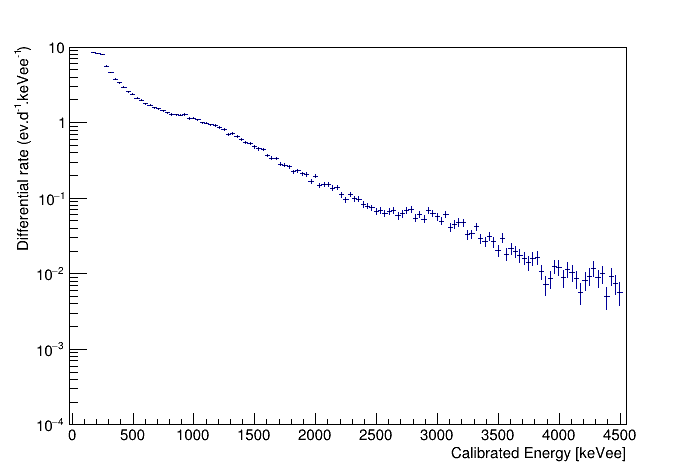

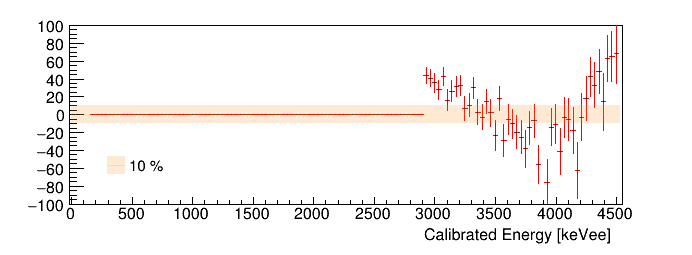

In [157]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
hCal_VNS_9inch->Draw("");
hCal_VNS_9inch->GetYaxis()->SetRangeUser(1e-4, 10);
Linear_bckg->SetLineColor(kBlue);
Linear_bckg->Draw("RSAME");
Model_linear->Draw("RSAME");

TCanvas* C2 = new TCanvas("cRes_VNS_9inch_lin", "cRes_VNS_9inch_lin", C->GetWw(), 0.6*C->GetWh());
C2->Draw();
gPad->SetMargin(0.1,0.1,0.2,0.1);

hRes_VNS_9inch_lin=Residuals(hCal_VNS_9inch, Model_linear, 2900, 4700, true);
hRes_VNS_9inch_lin->GetYaxis()->SetTitle("Residuals [%]");
hRes_VNS_9inch_lin->GetYaxis()->SetTitleSize(2*hCal_VNS_9inch->GetYaxis()->GetTitleSize());
hRes_VNS_9inch_lin->GetXaxis()->SetTitleSize(2*hCal_VNS_9inch->GetXaxis()->GetTitleSize());
hRes_VNS_9inch_lin->GetYaxis()->SetLabelSize(2*hCal_VNS_9inch->GetYaxis()->GetLabelSize());
hRes_VNS_9inch_lin->GetXaxis()->SetLabelSize(2*hCal_VNS_9inch->GetXaxis()->GetLabelSize());
hRes_VNS_9inch_lin->Draw("");

h_10pc->Draw("E3SAME");

TLegend* leg = new TLegend(0.15, 0.3, 0.30, 0.4);
leg->AddEntry(h_10pc, "10 %");
leg->Draw("SAME");
leg->SetLineWidth(0);

### 8inch

In [158]:
Int_start = 3000;
Int_stop = 4500;

Model_linear->SetParameter(1, 3500);
if (Model_linear->GetParameter(2)==0) Model_linear->SetParameter(2, Resol_NP*3500);

TFitResultPtr r = hCal_DC_8inch->Fit(Model_linear, "S0", "", 2800, 5100);

TMatrixD CovMat_8_lin_DC = r->GetCovarianceMatrix();

//CovMat_DC.Print();

Double_t err_norm_8_NP_DC_lin = sqrt(CovMat_8_lin_DC(0,0));
Double_t norm_8_NP_DC_lin = Model_linear->GetParameter(0);

Linear_bckg->SetParameter(0, Model_linear->GetParameter(3));
Linear_bckg->SetParameter(1, Model_linear->GetParameter(4));

Neutron_peak_Gaus->SetParameter(0, Model_linear->GetParameter(0));
Neutron_peak_Gaus->SetParameter(1, Model_linear->GetParameter(1));
Neutron_peak_Gaus->SetParameter(2, Model_linear->GetParameter(2));

Double_t N_ev_tot_8_DC_lin = Model_linear->Integral(Int_start, Int_stop);
Double_t N_ev_NP_8_DC_lin = Neutron_peak_Gaus->Integral(Int_start, Int_stop);
Double_t err_N_ev_NP_8_DC_lin = (err_norm_8_NP_DC_lin/norm_8_NP_DC_lin)*Neutron_peak_Gaus->Integral(Int_start, Int_stop);
Double_t N_ev_BKG_8_DC_lin = Linear_bckg->Integral(Int_start, Int_stop);
Double_t err_N_ev_BKG_8_DC_lin = sqrt((Int_stop-Int_start)*(Int_stop-Int_start)*CovMat_8_lin_DC(3,3)+(Int_stop-Int_start)*(Int_stop*Int_stop-Int_start*Int_start)*CovMat_8_lin_DC(3, 4)+(Int_stop*Int_stop-Int_start*Int_start)*(Int_stop*Int_stop-Int_start*Int_start)*CovMat_8_lin_DC(4,4)/4);

Double_t err_N_ev_data_8_DC_lin;
Double_t N_ev_data_8_DC_lin = hCal_DC_8inch->IntegralAndError(hCal_DC_8inch->FindBin(Int_start), hCal_DC_8inch->FindBin(Int_stop), err_N_ev_data_8_DC_lin, "width");

Double_t err_N_ev_data_8_NP_DC_lin = sqrt(err_N_ev_data_8_DC_lin*err_N_ev_data_8_DC_lin + err_N_ev_BKG_8_DC_lin*err_N_ev_BKG_8_DC_lin);
Double_t N_ev_data_NP_8_DC_lin = N_ev_data_8_DC_lin-N_ev_BKG_8_DC_lin;

cout<<"\nChi2/ndf = "<<Model_linear->GetChisquare()<<"/"<<Model_linear->GetNDF()<<" = "<<Model_linear->GetChisquare()/Model_linear->GetNDF()<<endl;
cout<<"\nTotal N_ev in peak region = "<<N_ev_data_8_DC_lin<<" ev/d +- "<<err_N_ev_data_8_DC_lin<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from fit = "<<N_ev_NP_8_DC_lin<<" ev/d +- "<<err_N_ev_NP_8_DC_lin<<" ev/d "<<endl;
cout<<"N_ev in background = "<<N_ev_BKG_8_DC_lin<<" ev/d +- "<<err_N_ev_BKG_8_DC_lin<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from data - bckg = "<<N_ev_data_NP_8_DC_lin<<" ev/d +- "<<err_N_ev_data_8_NP_DC_lin<<" ev/d"<<endl;

Model_linear->FixParameter(2, Model_linear->GetParameter(2)); //Fix the sigma value of the neutron peak 
Model_linear->FixParameter(1, Model_linear->GetParameter(1)); //Fix the positio. of the neutron peak  

 FCN=610.894 FROM HESSE     STATUS=NOT POSDEF     23 CALLS         183 TOTAL
                     EDM=2.98102e-07    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.70004e-01   2.36752e-02   2.29449e-06   9.09596e-02
   2  p1          -4.05371e+06   2.75000e+05   1.34814e+01   4.17249e-09
   3  p2           4.17615e+06     fixed    
   4  p3           2.20881e-01   1.47414e-02   2.70216e-06   7.73248e-02
   5  p4          -1.01659e-04   2.28357e-06   6.69122e-10   6.46793e+02

Chi2/ndf = 610.894/44 = 13.8839

Total N_ev in peak region = 128.605 ev/d +- 2.53141 ev/d
N_ev in neutron peak from fit = 346.193 ev/d +- 22.1522 ev/d 
N_ev in background = -240.51 ev/d +- 22.1603 ev/d
N_ev in neutron peak from data - bckg = 369.115 ev/d +- 22.3045 ev/d


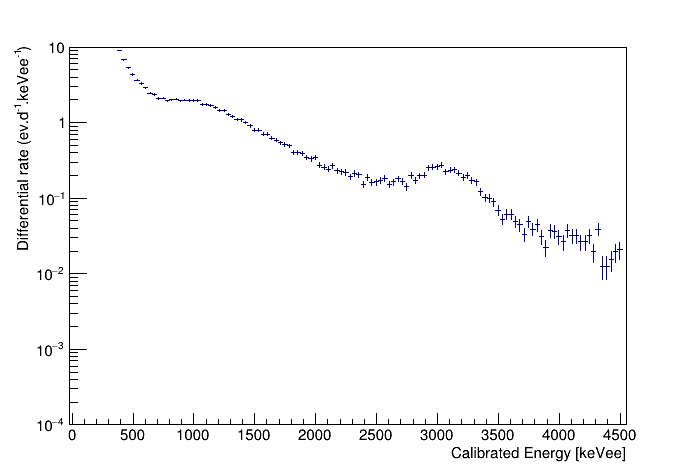

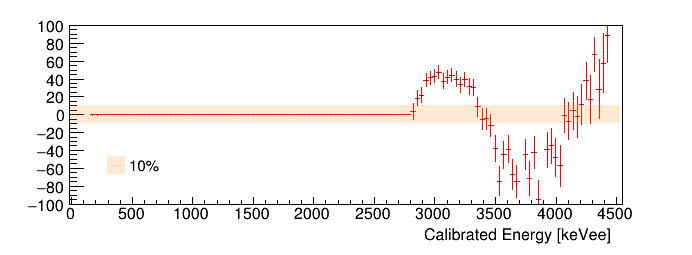

In [159]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
hCal_DC_8inch->Draw("");
hCal_DC_8inch->GetYaxis()->SetRangeUser(1e-4, 10);
Linear_bckg->SetLineColor(kBlue);
Linear_bckg->Draw("RSAME");
Model_linear->Draw("RSAME");

TCanvas* C2 = new TCanvas("cRes_DC_8inch_lin", "cRes_DC_8inch_lin", C->GetWw(), 0.6*C->GetWh());
C2->Draw();
gPad->SetMargin(0.1,0.1,0.2,0.1);

hRes_DC_8inch_lin=Residuals(hCal_DC_8inch, Model_linear, 2800, 4700, true);
hRes_DC_8inch_lin->GetYaxis()->SetTitle("Residuals [%]");
hRes_DC_8inch_lin->GetYaxis()->SetTitleSize(2*hCal_DC_8inch->GetYaxis()->GetTitleSize());
hRes_DC_8inch_lin->GetXaxis()->SetTitleSize(2*hCal_DC_8inch->GetXaxis()->GetTitleSize());
hRes_DC_8inch_lin->GetYaxis()->SetLabelSize(2*hCal_DC_8inch->GetYaxis()->GetLabelSize());
hRes_DC_8inch_lin->GetXaxis()->SetLabelSize(2*hCal_DC_8inch->GetXaxis()->GetLabelSize());
hRes_DC_8inch_lin->Draw("");

h_10pc->SetLineColorAlpha(kOrange+1, 0.2);
h_10pc->SetMarkerColorAlpha(kOrange+1, 0.2);
h_10pc->SetFillColorAlpha(kOrange+1, 0.2);
h_10pc->Draw("E3SAME");

TLegend* leg = new TLegend(0.15, 0.3, 0.30, 0.4);
leg->AddEntry(h_10pc, "10%");
leg->Draw("SAME");
leg->SetLineWidth(0);

In [160]:
Int_start = 3000;
Int_stop = 4500;

Model_linear->SetParameter(1, 3500);
if (Model_linear->GetParameter(2)==0) Model_linear->SetParameter(2, Resol_NP*3500);

TFitResultPtr r = hCal_VNS_8inch->Fit(Model_linear, "S0", "", 3000, 5100);

TMatrixD CovMat_8_lin_VNS = r->GetCovarianceMatrix();

//CovMat_DC.Print();

Double_t err_norm_8_NP_VNS_lin = sqrt(CovMat_8_lin_VNS(0,0));
Double_t norm_8_NP_VNS_lin = Model_linear->GetParameter(0);

Linear_bckg->SetParameter(0, Model_linear->GetParameter(3));
Linear_bckg->SetParameter(1, Model_linear->GetParameter(4));

Neutron_peak_Gaus->SetParameter(0, Model_linear->GetParameter(0));
Neutron_peak_Gaus->SetParameter(1, Model_linear->GetParameter(1));
Neutron_peak_Gaus->SetParameter(2, Model_linear->GetParameter(2));

Double_t N_ev_tot_8_VNS_lin = Model_linear->Integral(Int_start, Int_stop);
Double_t N_ev_NP_8_VNS_lin = Neutron_peak_Gaus->Integral(Int_start, Int_stop);
Double_t err_N_ev_NP_8_VNS_lin = (err_norm_8_NP_VNS_lin/norm_8_NP_VNS_lin)*Neutron_peak_Gaus->Integral(Int_start, Int_stop);
Double_t N_ev_BKG_8_VNS_lin = Linear_bckg->Integral(Int_start, Int_stop);
Double_t err_N_ev_BKG_8_VNS_lin = sqrt((Int_stop-Int_start)*(Int_stop-Int_start)*CovMat_8_lin_VNS(3,3)+(Int_stop-Int_start)*(Int_stop*Int_stop-Int_start*Int_start)*CovMat_8_lin_VNS(3, 4)+(Int_stop*Int_stop-Int_start*Int_start)*(Int_stop*Int_stop-Int_start*Int_start)*CovMat_8_lin_VNS(4,4)/4);

Double_t err_N_ev_data_8_VNS_lin;
Double_t N_ev_data_8_VNS_lin = hCal_VNS_8inch->IntegralAndError(hCal_VNS_8inch->FindBin(Int_start), hCal_VNS_8inch->FindBin(Int_stop), err_N_ev_data_8_VNS_lin, "width");

Double_t err_N_ev_data_8_NP_VNS_lin = sqrt(err_N_ev_data_8_VNS_lin*err_N_ev_data_8_VNS_lin + err_N_ev_BKG_8_VNS_lin*err_N_ev_BKG_8_VNS_lin);
Double_t N_ev_data_NP_8_VNS_lin = N_ev_data_8_VNS_lin-N_ev_BKG_8_VNS_lin;

cout<<"\nChi2/ndf = "<<Model_linear->GetChisquare()<<"/"<<Model_linear->GetNDF()<<" = "<<Model_linear->GetChisquare()/Model_linear->GetNDF()<<endl;
cout<<"\nTotal N_ev in peak region = "<<N_ev_data_8_VNS_lin<<" ev/d +- "<<err_N_ev_data_8_VNS_lin<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from fit = "<<N_ev_NP_8_VNS_lin<<" ev/d +- "<<err_N_ev_NP_8_VNS_lin<<" ev/d "<<endl;
cout<<"N_ev in background = "<<N_ev_BKG_8_VNS_lin<<" ev/d +- "<<err_N_ev_BKG_8_VNS_lin<<" ev/d"<<endl;
cout<<"N_ev in neutron peak from data - bckg = "<<N_ev_data_NP_8_VNS_lin<<" ev/d +- "<<err_N_ev_data_8_NP_VNS_lin<<" ev/d"<<endl;

Model_linear->FixParameter(2, Model_linear->GetParameter(2)); //Fix the sigma value of the neutron peak  

 FCN=114.947 FROM MIGRAD    STATUS=CONVERGED      81 CALLS          82 TOTAL
                     EDM=2.95167e-11    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.8 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.77989e-01   1.56835e-03   4.27199e-07   1.63889e-02
   2  p1           3.50000e+03     fixed    
   3  p2           4.17615e+06     fixed    
   4  p3          -7.48193e-02   3.05405e-03   8.48228e-07   1.21409e-02
   5  p4          -2.24634e-05   1.14108e-06  -5.60118e-10   4.12149e+01

Chi2/ndf = 114.947/39 = 2.94736

Total N_ev in peak region = 32.1108 ev/d +- 0.822646 ev/d
N_ev in neutron peak from fit = 266.983 ev/d +- 2.35253 ev/d 
N_ev in background = -238.586 ev/d +- 4.69459 ev/d
N_ev in neutron peak from data - bckg = 270.696 ev/d +- 4.76613 ev/d


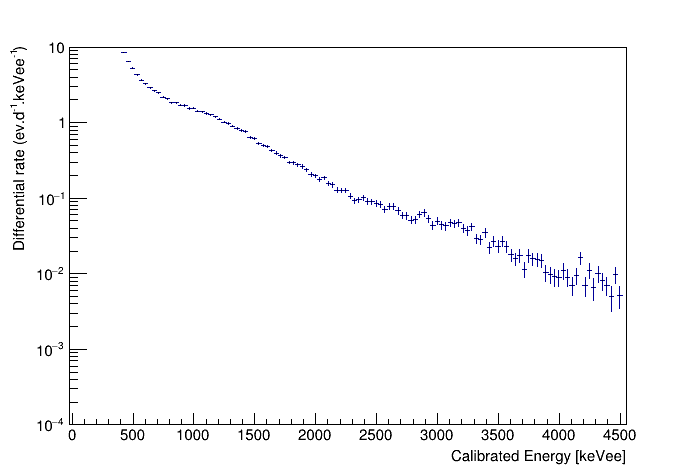

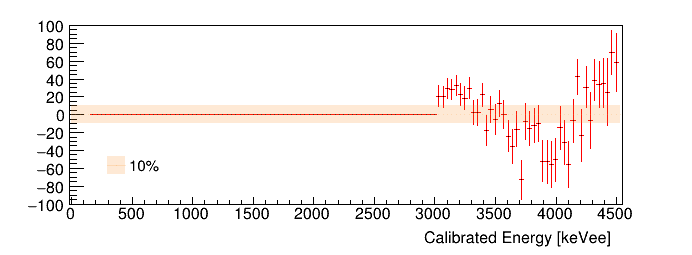

In [161]:
TCanvas* C = new TCanvas();
C->Draw();
C->SetLogy();
hCal_VNS_8inch->Draw("");
hCal_VNS_8inch->GetYaxis()->SetRangeUser(1e-4, 10);
Linear_bckg->SetLineColor(kBlue);
Linear_bckg->Draw("RSAME");
Model_linear->Draw("RSAME");

TCanvas* C2 = new TCanvas("cRes_VNS_8inch_lin", "cRes_VNS_8inch_lin", C->GetWw(), 0.6*C->GetWh());
C2->Draw();
gPad->SetMargin(0.1,0.1,0.2,0.1);

hRes_VNS_8inch_lin=Residuals(hCal_VNS_8inch, Model_linear, 3000, 4700, true);
hRes_VNS_8inch_lin->GetYaxis()->SetTitle("Residuals [%]");
hRes_VNS_8inch_lin->GetYaxis()->SetTitleSize(2*hCal_VNS_8inch->GetYaxis()->GetTitleSize());
hRes_VNS_8inch_lin->GetXaxis()->SetTitleSize(2*hCal_VNS_8inch->GetXaxis()->GetTitleSize());
hRes_VNS_8inch_lin->GetYaxis()->SetLabelSize(2*hCal_VNS_8inch->GetYaxis()->GetLabelSize());
hRes_VNS_8inch_lin->GetXaxis()->SetLabelSize(2*hCal_VNS_8inch->GetXaxis()->GetLabelSize());
hRes_VNS_8inch_lin->Draw("");

h_10pc->SetLineColorAlpha(kOrange+1, 0.2);
h_10pc->SetMarkerColorAlpha(kOrange+1, 0.2);
h_10pc->SetFillColorAlpha(kOrange+1, 0.2);
h_10pc->Draw("E3SAME");

TLegend* leg = new TLegend(0.15, 0.3, 0.30, 0.4);
leg->AddEntry(h_10pc, "10%");
leg->Draw("SAME");
leg->SetLineWidth(0);